# **WiDS2022 Project**
Team: Eco Geeks

*   Soujanya Madabhushi
*   Taher Kayamkhani
*   Anusha Vikas
*   Seema Maheshgauri

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use.

According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.

#### **Goal**
The goal of this competition is to predict the energy consumption using building characteristics and climate and weather variables .

#### **Data**
The WiDS Datathon 2022 focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.



### **EDA (Exploratory Data Analysis)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial, update_wrapper
from collections import defaultdict
from scipy.stats import multivariate_normal, norm, uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

import ipywidgets as widgets
from ipywidgets import interact, interactive

**1. Read data**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_solution.csv to sample_solution.csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample = pd.read_csv('sample_solution.csv')
print("Number of train samples are",train_df.shape)
print("Number of test samples are",test_df.shape)
print("Number of sample solutions are",sample.shape)

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)
Number of sample solutions are (9705, 2)


**2. Exploratory data analysis**

In [ ]:
len(train_df)

75757

In [ ]:
len(test_df)

9705

In [ ]:
nnull_frame= pd.DataFrame(train_df.isnull().sum())
null_frame.tail(20)

0
cooling_degree_days            0
heating_degree_days            0
precipitation_inches           0
snowfall_inches                0
snowdepth_inches               0
avg_temp                       0
days_below_30F                 0
days_below_20F                 0
days_below_10F                 0
days_below_0F                  0
days_above_80F                 0
days_above_90F                 0
days_above_100F                0
days_above_110F                0
direction_max_wind_speed   41082
direction_peak_wind_speed  41811
max_wind_speed             41082
days_with_fog              45796
site_eui                       0
id                             0

In [ ]:
train_df.isnull().mean()

Year_Factor                  0.000000
State_Factor                 0.000000
building_class               0.000000
facility_type                0.000000
floor_area                   0.000000
                               ...   
direction_peak_wind_speed    0.551909
max_wind_speed               0.542287
days_with_fog                0.604512
site_eui                     0.000000
id                           0.000000
Length: 64, dtype: float64

In [ ]:
test_df.isnull().mean()

Year_Factor                  0.000000
State_Factor                 0.000000
building_class               0.000000
facility_type                0.000000
floor_area                   0.000000
                               ...   
direction_max_wind_speed     0.883565
direction_peak_wind_speed    0.883565
max_wind_speed               0.883565
days_with_fog                0.939413
id                           0.000000
Length: 63, dtype: float64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [ ]:
train_df.head(5)

Year_Factor State_Factor building_class  ... days_with_fog    site_eui  id
0            1      State_1     Commercial  ...           NaN  248.682615   0
1            1      State_1     Commercial  ...          12.0   26.500150   1
2            1      State_1     Commercial  ...          12.0   24.693619   2
3            1      State_1     Commercial  ...          12.0   48.406926   3
4            1      State_1     Commercial  ...           NaN    3.899395   4

[5 rows x 64 columns]

In [ ]:
train_df.describe()

Year_Factor    floor_area  ...      site_eui            id
count  75757.000000  7.575700e+04  ...  75757.000000  75757.000000
mean       4.367755  1.659839e+05  ...     82.584693  37878.000000
std        1.471441  2.468758e+05  ...     58.255403  21869.306509
min        1.000000  9.430000e+02  ...      1.001169      0.000000
25%        3.000000  6.237900e+04  ...     54.528601  18939.000000
50%        5.000000  9.136700e+04  ...     75.293716  37878.000000
75%        6.000000  1.660000e+05  ...     97.277534  56817.000000
max        6.000000  6.385382e+06  ...    997.866120  75756.000000

[8 rows x 61 columns]

In [ ]:
test_df.describe()

Year_Factor    floor_area  ...  days_with_fog            id
count       9705.0  9.705000e+03  ...     588.000000   9705.000000
mean           7.0  1.632143e+05  ...     150.755102  80609.000000
std            0.0  2.624759e+05  ...      58.760576   2801.736515
min            7.0  5.982000e+03  ...      34.000000  75757.000000
25%            7.0  4.802000e+04  ...     129.000000  78183.000000
50%            7.0  8.248600e+04  ...     129.000000  80609.000000
75%            7.0  1.775200e+05  ...     138.000000  83035.000000
max            7.0  6.353396e+06  ...     250.000000  85461.000000

[8 rows x 60 columns]

**2.0 Site eui**

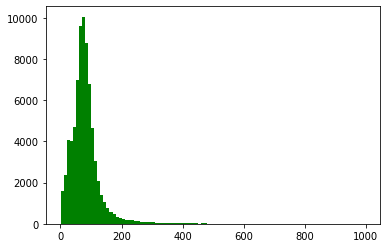

In [ ]:
n, bins, patches = plt.hist(train_df['site_eui'], 100, density=False, facecolor='g')

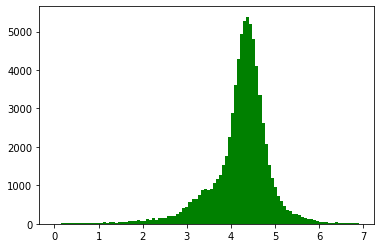

In [ ]:
n, bins, patches = plt.hist(np.log(train_df['site_eui']), 100, density=False, facecolor='g')

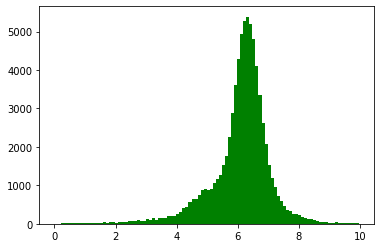

In [ ]:
n, bins, patches = plt.hist(np.log2(train_df['site_eui']), 100, density=False, facecolor='g')

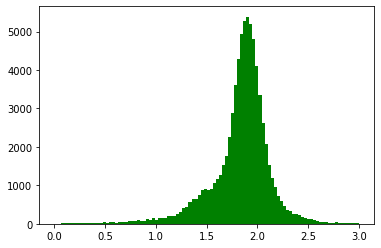

In [ ]:
n, bins, patches = plt.hist(np.log10(train_df['site_eui']), 100, density=False, facecolor='g')

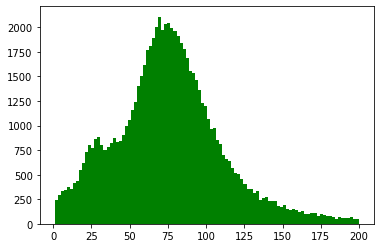

In [ ]:
n, bins, patches = plt.hist(train_df.loc[train_df['site_eui'] < 200]['site_eui'], 100, density=False, facecolor='g')

**Numerical Features VS Target**

In [ ]:
#scatter plot
# floor_area vs site_eui
def scatter_plot(feature,color):
    fig = plt.figure(figsize=(12,7))
    fig.set_facecolor("#fff")
    sns.scatterplot(data=train_df, x=feature, y="site_eui",color =color,s=200, alpha = 0.8,ec='white')
    plt.title(' Floor Area vs site EUI')
    plt.show()

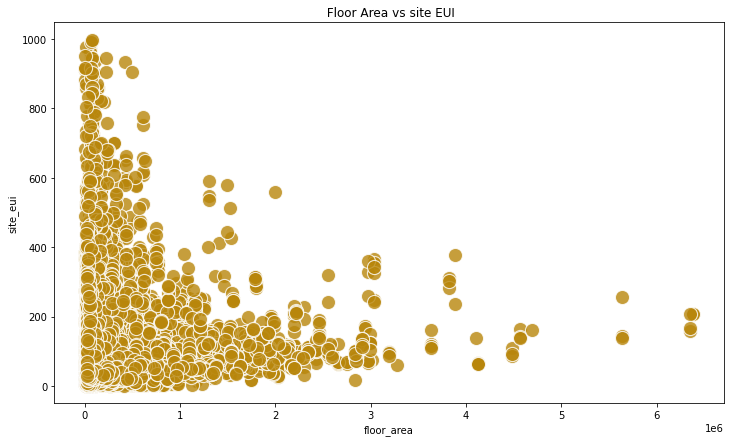

In [ ]:
scatter_plot("floor_area","darkgoldenrod")

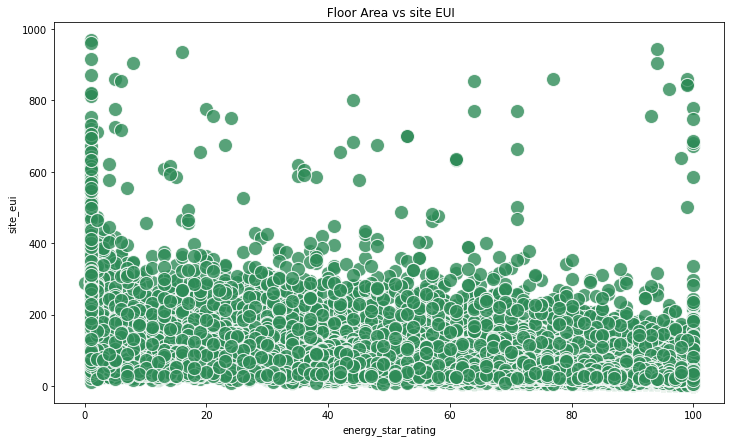

In [ ]:
# energy_star_rating vs site_eui
scatter_plot("energy_star_rating","seagreen")

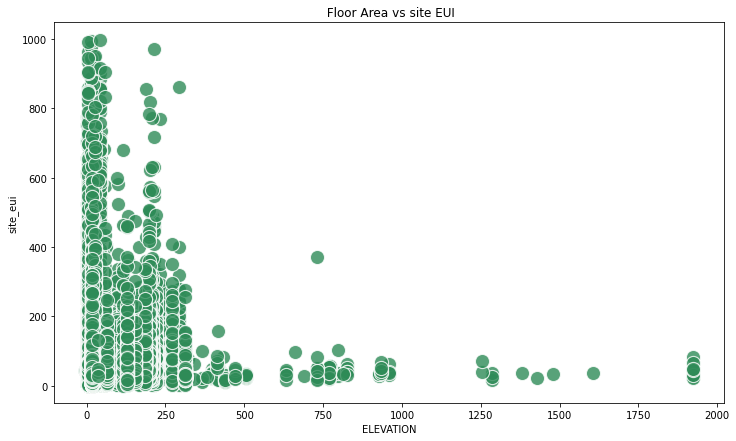

In [ ]:
# ELEVATION vs site_eui
scatter_plot("ELEVATION","seagreen")

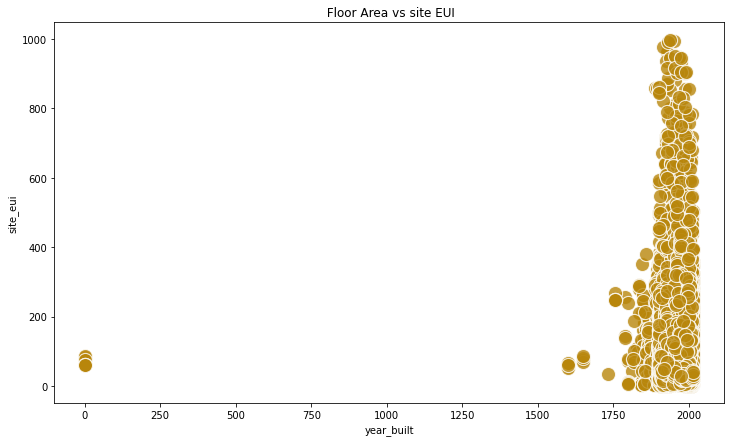

In [ ]:
# year_built vs site_eui
scatter_plot("year_built","darkgoldenrod")

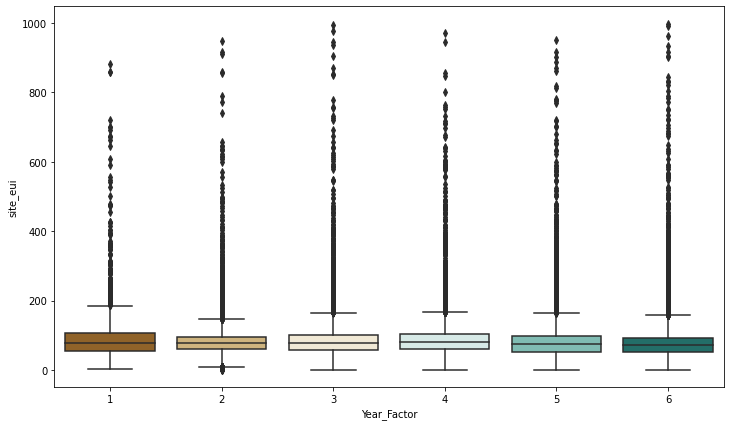

In [ ]:
# Year_Factor vs site_eui
fig = plt.figure(figsize=(12,7))
sns.boxplot(x="Year_Factor", y="site_eui", data=train_df,palette=sns.color_palette("BrBG"))

**2.1 Year factor**

In [ ]:
train_df['Year_Factor'].value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

In [ ]:
train_df['Year_Factor'].describe()

count    75757.000000
mean         4.367755
std          1.471441
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          6.000000
Name: Year_Factor, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


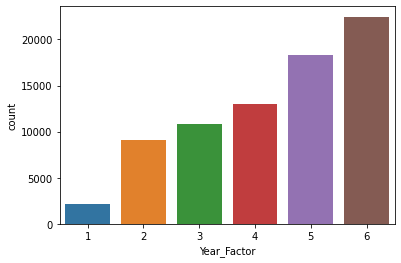

In [ ]:
sns.countplot(train_df['Year_Factor'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


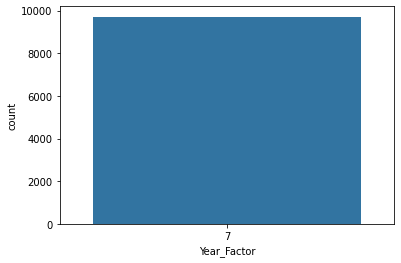

In [ ]:
sns.countplot(test_df['Year_Factor'])

In [ ]:
test_df['Year_Factor'].value_counts()

7    9705
Name: Year_Factor, dtype: int64

In [ ]:
test_df['Year_Factor'].value_counts()

7    9705
Name: Year_Factor, dtype: int64

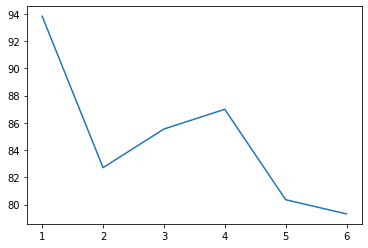

In [ ]:
plt.plot(train_df.groupby('Year_Factor')['site_eui'].agg('mean'))

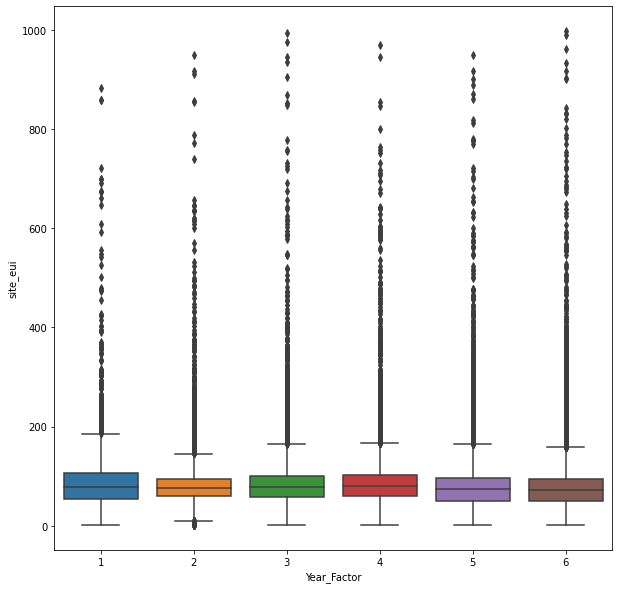

In [ ]:
plt.figure(figsize= (10, 10))
sns.boxplot(x= 'Year_Factor', y= 'site_eui', data= train_df)

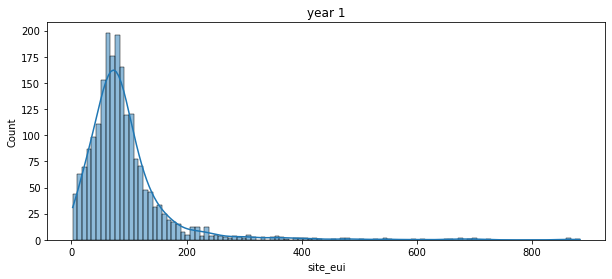

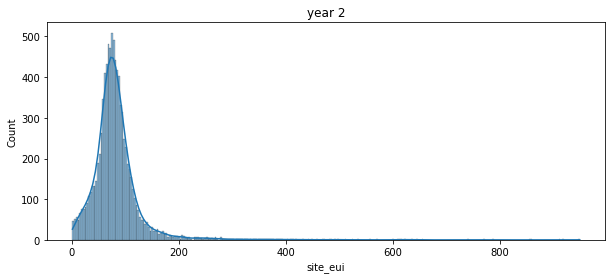

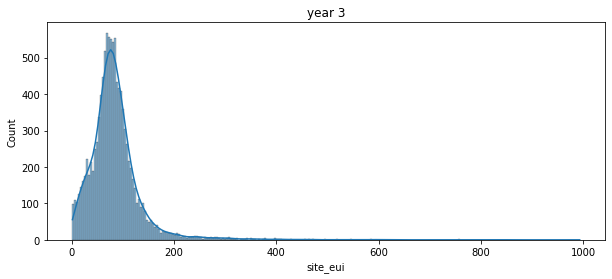

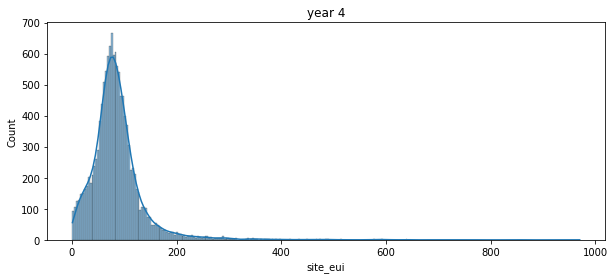

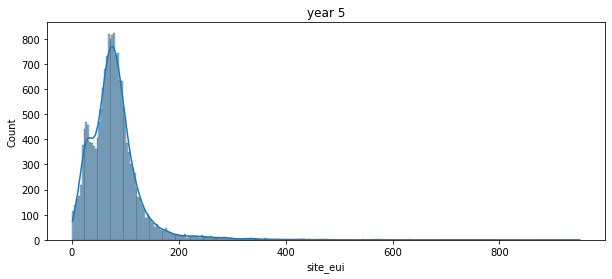

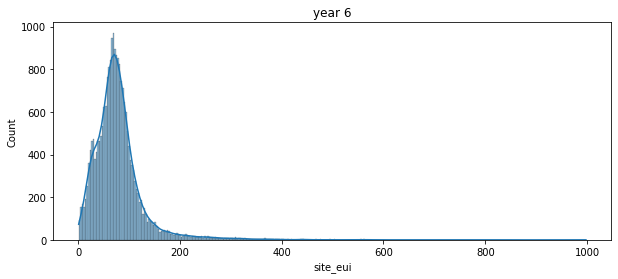

In [ ]:
for y in range(1, 7):
    df= train_df[train_df['Year_Factor']== y]
    plt.figure(figsize= (10, 4))
    sns.histplot(df['site_eui'], kde= True)
    plt.title(f'year {y}')
    plt.show()  

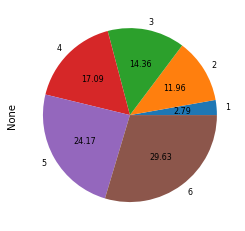

In [ ]:
# year factor piechart
train_df.groupby('Year_Factor').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 8})

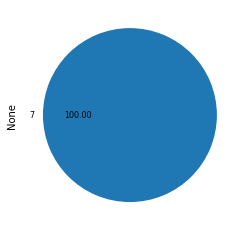

In [ ]:
test_df.groupby('Year_Factor').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 8})

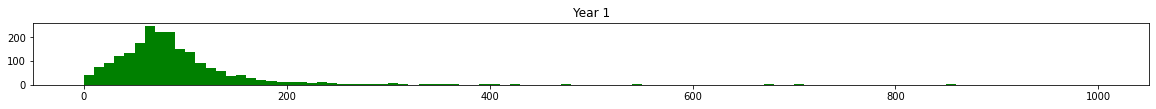

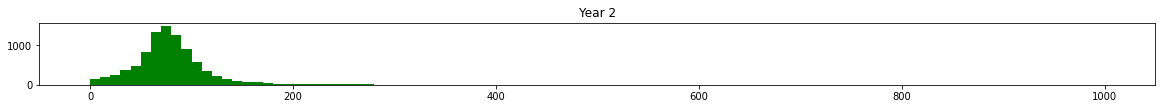

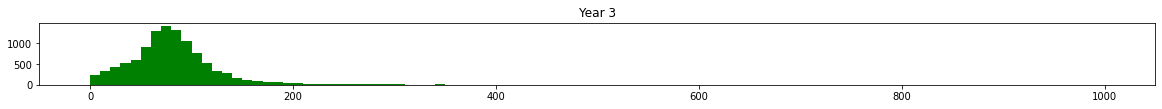

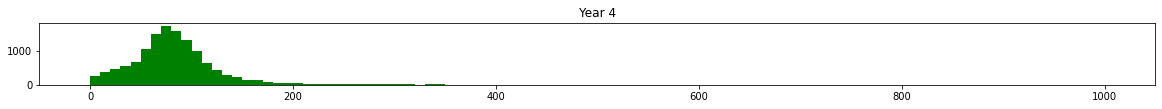

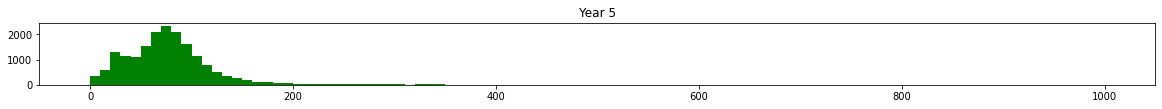

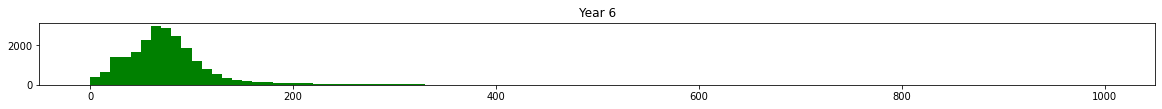

In [ ]:
for i in range(1, 7):
    plt.figure(figsize=(20,8))
    plt.subplot(6, 1, i)
    plt.title(f'Year {i}')
    n, bins, patches = plt.hist(train_df.loc[train_df['Year_Factor'] == i, 'site_eui'], 100,range=(0, 1000), density=False, facecolor='g')

**2.2 State factor**

In [ ]:
train_df['State_Factor'].describe()

count       75757
unique          7
top       State_6
freq        50840
Name: State_Factor, dtype: object

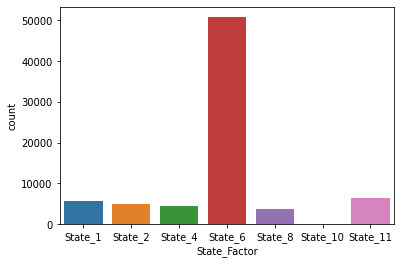

In [ ]:
sns.countplot(x= 'State_Factor', data= train_df)

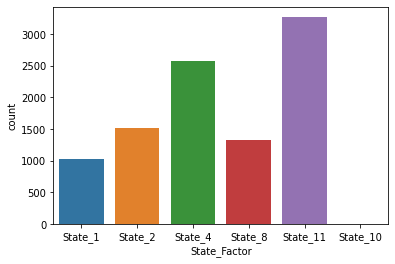

In [ ]:
sns.countplot(x= 'State_Factor', data= test_df)

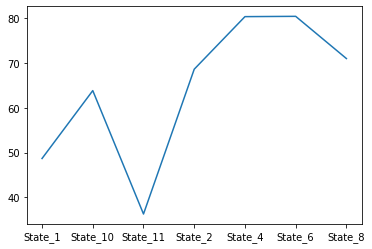

In [ ]:
plt.plot(train_df.groupby('State_Factor')['site_eui'].agg('median'))

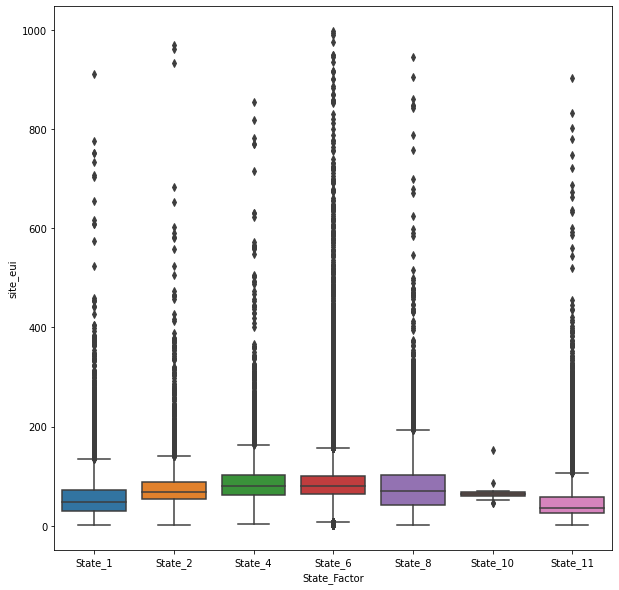

In [ ]:
plt.figure(figsize= (10, 10))
sns.boxplot(x= 'State_Factor', y= 'site_eui', data= train_df)

In [ ]:
print(set(train_df['State_Factor']))

{'State_1', 'State_2', 'State_6', 'State_8', 'State_11', 'State_4', 'State_10'}


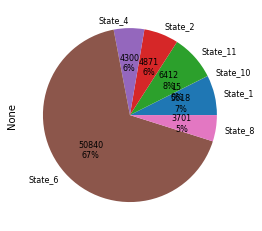

In [ ]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'

train_df.groupby('State_Factor').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8})

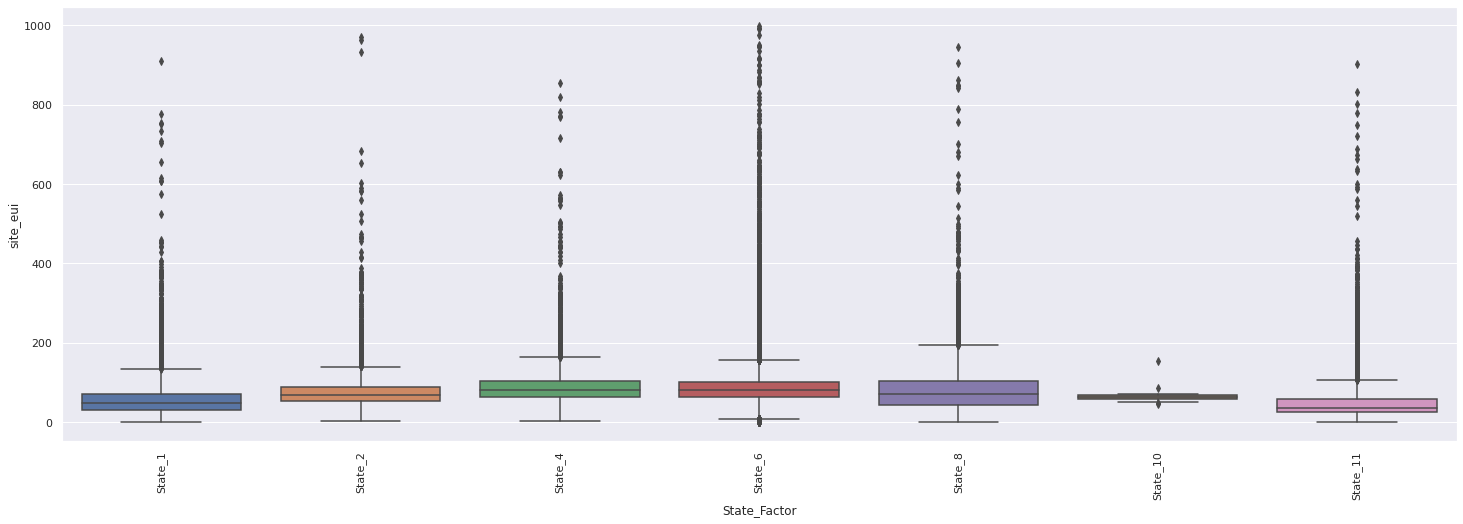

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='State_Factor', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
train_df.groupby('State_Factor').size()

State_Factor
State_1      5618
State_10       15
State_11     6412
State_2      4871
State_4      4300
State_6     50840
State_8      3701
dtype: int64

**2.3 Building class**

In [ ]:
train_df['building_class'].describe()

count           75757
unique              2
top       Residential
freq            43558
Name: building_class, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


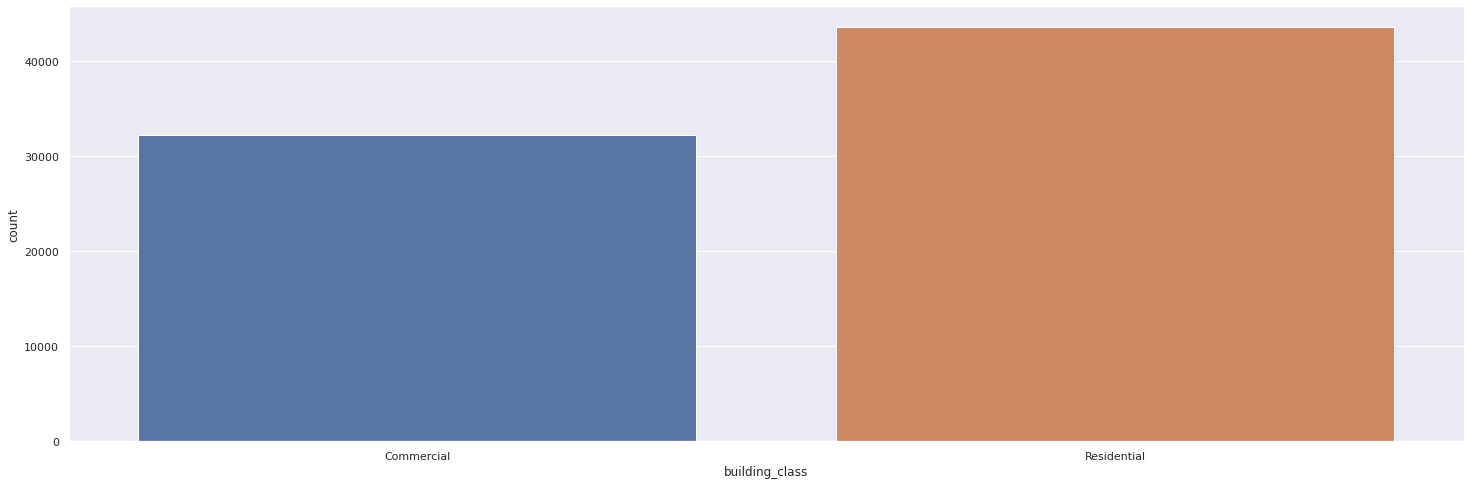

In [ ]:
sns.countplot(train_df['building_class'])

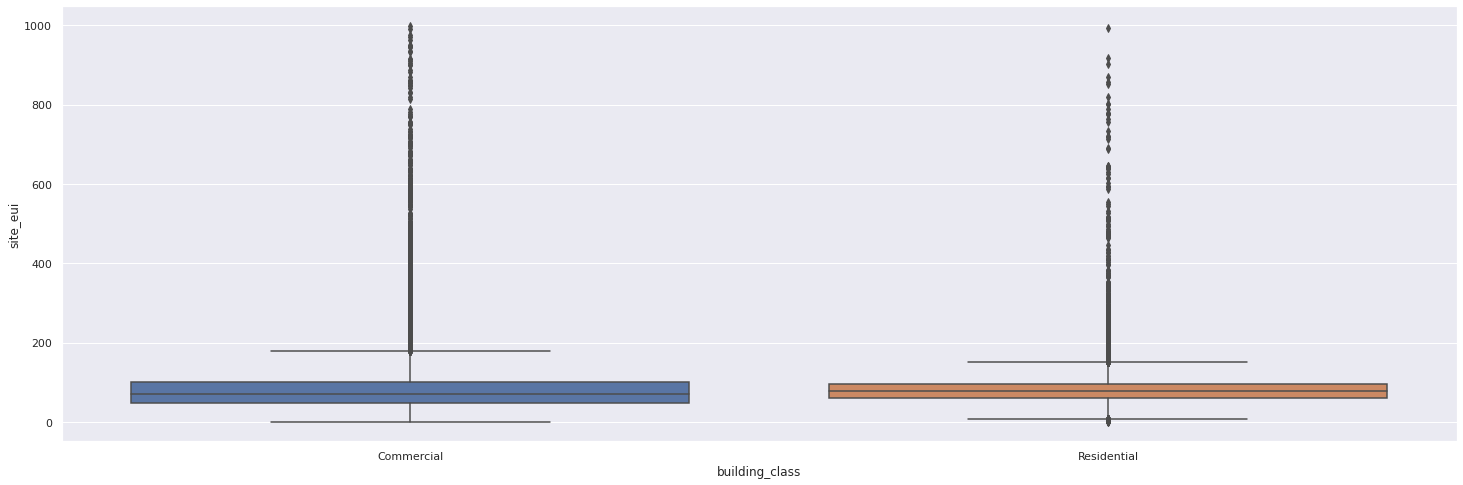

In [ ]:
sns.boxplot(x= 'building_class', y= 'site_eui', data= train_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


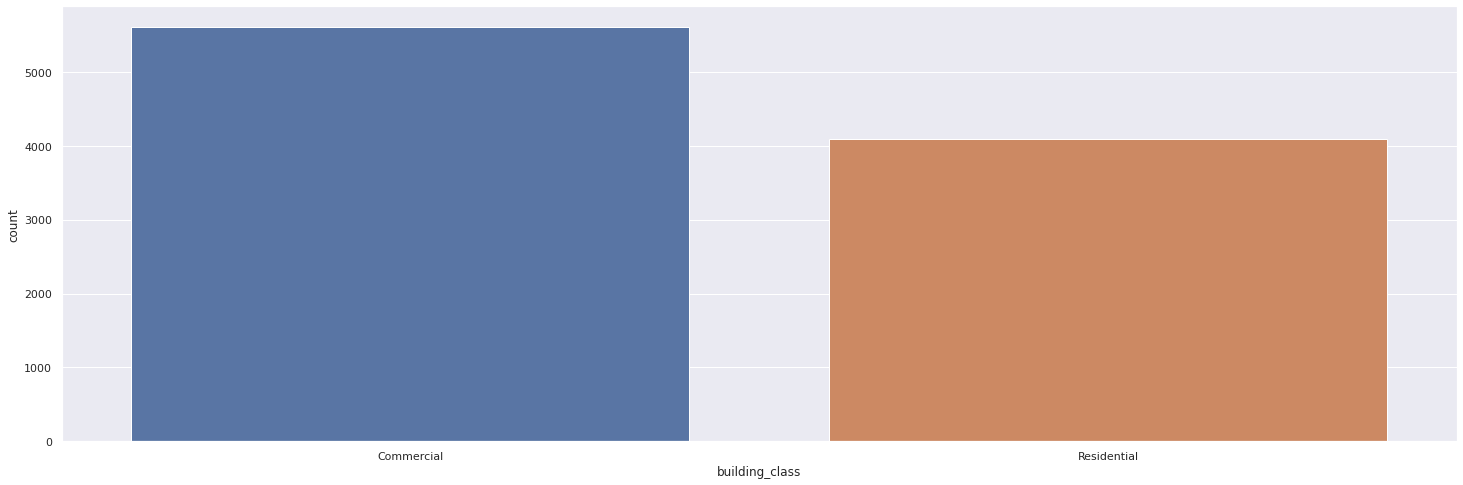

In [ ]:
sns.countplot(test_df['building_class'])

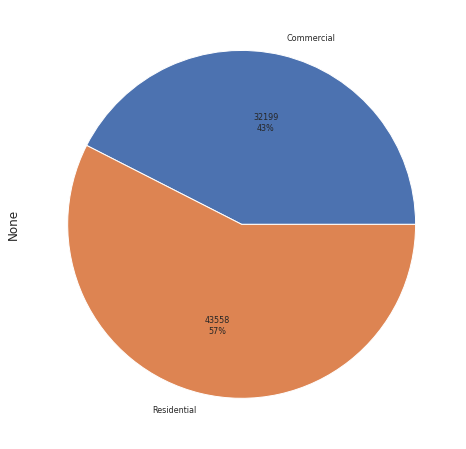

In [ ]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'

train_df.groupby('building_class').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8})

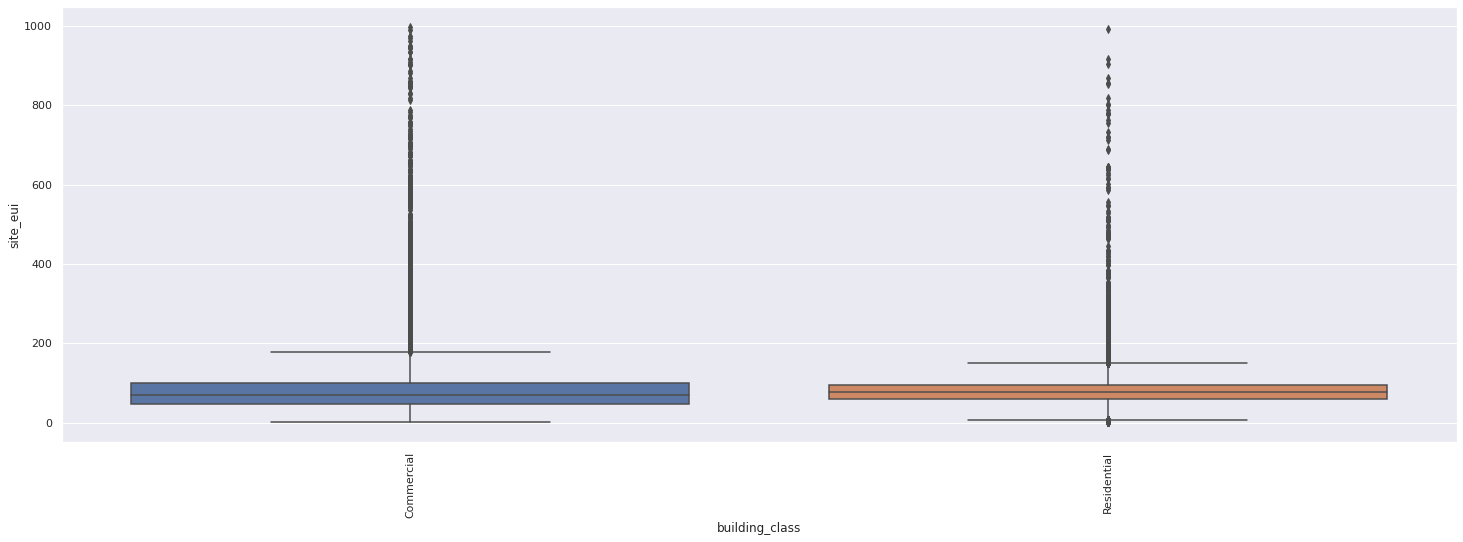

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='building_class', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

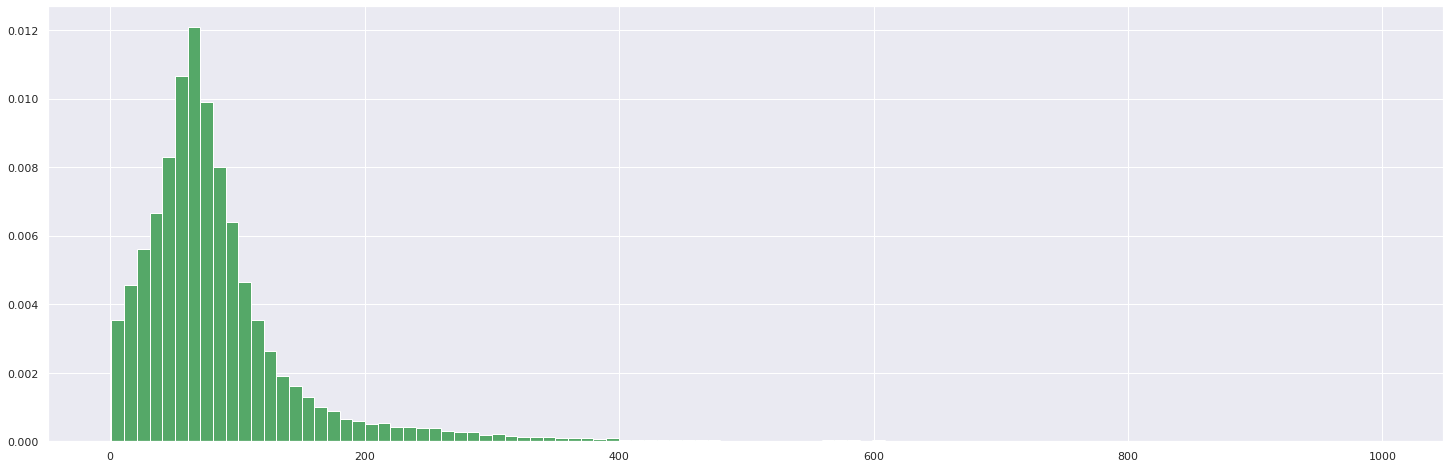

In [ ]:
n, bins, patches = plt.hist(train_df.loc[train_df['building_class'] == 'Commercial', 'site_eui'], 100, density=True, facecolor='g')

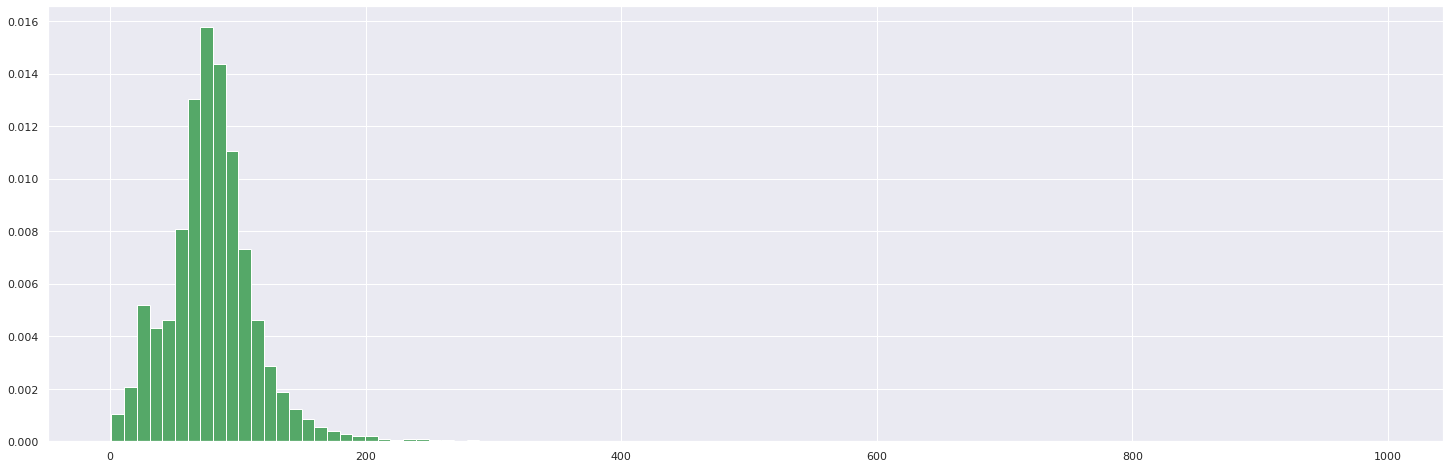

In [ ]:
n, bins, patches = plt.hist(train_df.loc[train_df['building_class'] == 'Residential', 'site_eui'], 100, density=True, facecolor='g')


**2.4 Facility Type**

In [ ]:
train_df['facility_type'].describe()

count                         75757
unique                           60
top       Multifamily_Uncategorized
freq                          39455
Name: facility_type, dtype: object

In [ ]:
train_df['facility_type'].unique().sort()== test_df['facility_type'].unique().sort()

True

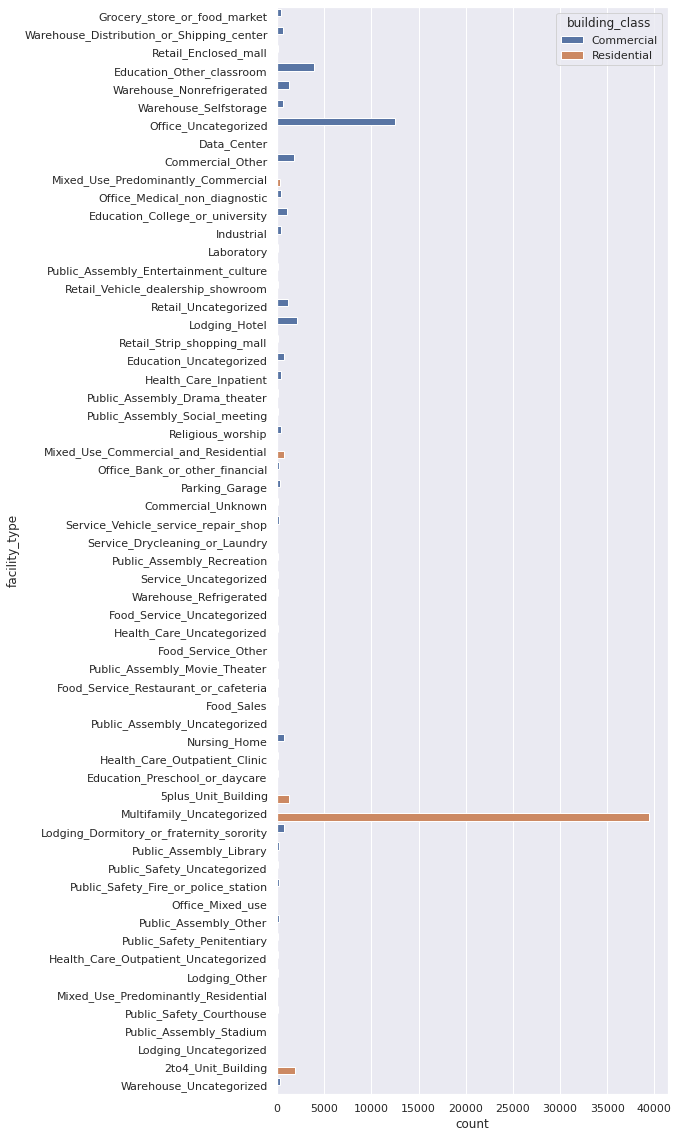

In [ ]:
plt.figure(figsize= (7, 20))
sns.countplot(y= 'facility_type', hue= 'building_class', data= train_df)

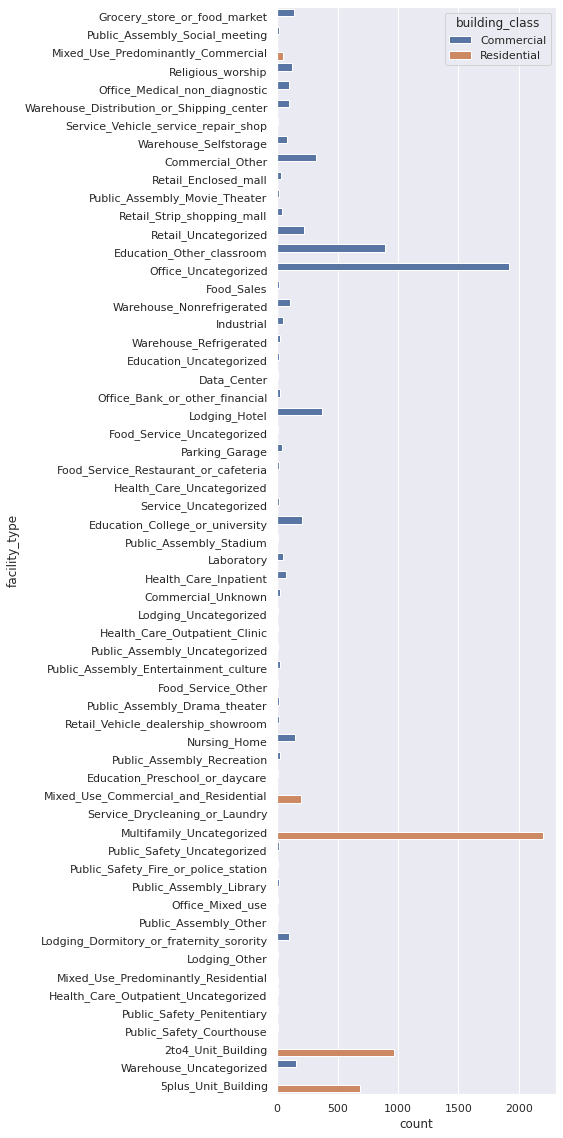

In [ ]:
plt.figure(figsize= (5, 20))
sns.countplot(y= 'facility_type', hue= 'building_class', data= test_df)

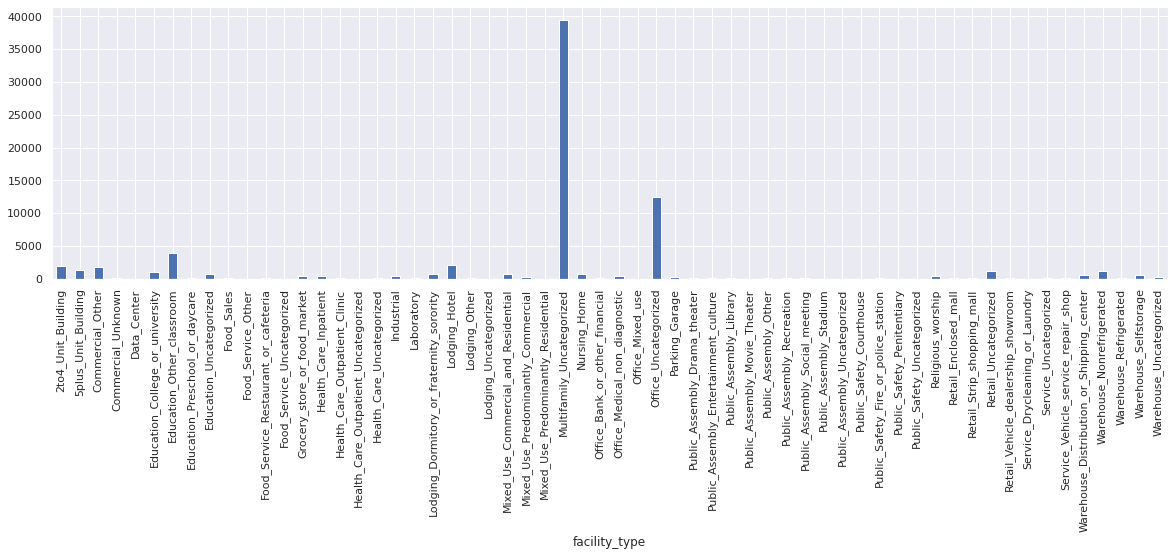

In [ ]:
# state factor piechart
def label_function(val):
    return f'{val / 100 * len(train_df):.0f}\n{val:.0f}%'
train_df.groupby('facility_type').size().plot(kind='bar', figsize=(20, 5))

In [ ]:
train_facility_type_group = train_df.groupby('facility_type')['id'].count().reset_index()
test_facility_type_group = test_df.groupby('facility_type')['id'].count().reset_index()
train_facility_type_group.rename(columns={'id': 'train_count'}, inplace=True)
test_facility_type_group.rename(columns={'id': 'test_count'}, inplace=True)

facility_type_group = train_facility_type_group.merge(test_facility_type_group, on='facility_type', how='outer')
facility_type_group['ratio'] = facility_type_group['test_count'] / facility_type_group['train_count'] 

In [ ]:
facility_type_group

facility_type  ...     ratio
0                          2to4_Unit_Building  ...  0.510301
1                         5plus_Unit_Building  ...  0.538099
2                            Commercial_Other  ...  0.186353
3                          Commercial_Unknown  ...  0.242105
4                                 Data_Center  ...  0.148148
5             Education_College_or_university  ...  0.191288
6                   Education_Other_classroom  ...  0.230570
7              Education_Preschool_or_daycare  ...  0.027778
8                     Education_Uncategorized  ...  0.016925
9                                  Food_Sales  ...  0.271429
10                         Food_Service_Other  ...  0.176471
11       Food_Service_Restaurant_or_cafeteria  ...  0.265625
12                 Food_Service_Uncategorized  ...  0.222222
13               Grocery_store_or_food_market  ...  0.301339
14                      Health_Care_Inpatient  ...  0.185819
15              Health_Care_Outpatient_Clinic  ...  0.089286
16       Health_Care_Outpatient_Uncategorized  ...  0.111111
17                  Health_Care_Uncategorized  ...  0.039216
18                                 Industrial  ...  0.122396
19                                 Laboratory  ...  0.411215
20   Lodging_Dormitory_or_fraternity_sorority  ...  0.147982
21                              Lodging_Hotel  ...  0.174929
22                              Lodging_Other  ...  0.106667
23                      Lodging_Uncategorized  ...  1.000000
24       Mixed_Use_Commercial_and_Residential  ...  0.287202
25         Mixed_Use_Predominantly_Commercial  ...  0.195312
26        Mixed_Use_Predominantly_Residential  ...  0.555556
27                  Multifamily_Uncategorized  ...  0.055734
28                               Nursing_Home  ...  0.195596
29             Office_Bank_or_other_financial  ...  0.132948
30              Office_Medical_non_diagnostic  ...  0.223714
31                           Office_Mixed_use  ...  0.222222
32                       Office_Uncategorized  ...  0.153373
33                             Parking_Garage  ...  0.147410
34              Public_Assembly_Drama_theater  ...  0.200000
35      Public_Assembly_Entertainment_culture  ...  0.181818
36                    Public_Assembly_Library  ...  0.106250
37              Public_Assembly_Movie_Theater  ...  0.333333
38                      Public_Assembly_Other  ...  0.049296
39                 Public_Assembly_Recreation  ...  0.361111
40             Public_Assembly_Social_meeting  ...  0.159091
41                    Public_Assembly_Stadium  ...  0.333333
42              Public_Assembly_Uncategorized  ...  0.320000
43                   Public_Safety_Courthouse  ...  0.131579
44       Public_Safety_Fire_or_police_station  ...  0.050955
45                 Public_Safety_Penitentiary  ...  0.216216
46                Public_Safety_Uncategorized  ...  0.372093
47                          Religious_worship  ...  0.313283
48                       Retail_Enclosed_mall  ...  0.275000
49                 Retail_Strip_shopping_mall  ...  0.327434
50                       Retail_Uncategorized  ...  0.199115
51         Retail_Vehicle_dealership_showroom  ...  0.162162
52             Service_Drycleaning_or_Laundry  ...  0.222222
53                      Service_Uncategorized  ...  0.220588
54        Service_Vehicle_service_repair_shop  ...  0.065217
55  Warehouse_Distribution_or_Shipping_center  ...  0.155629
56                  Warehouse_Nonrefrigerated  ...  0.087649
57                     Warehouse_Refrigerated  ...  0.185841
58                      Warehouse_Selfstorage  ...  0.138648
59                    Warehouse_Uncategorized  ...  0.475758

[60 rows x 4 columns]

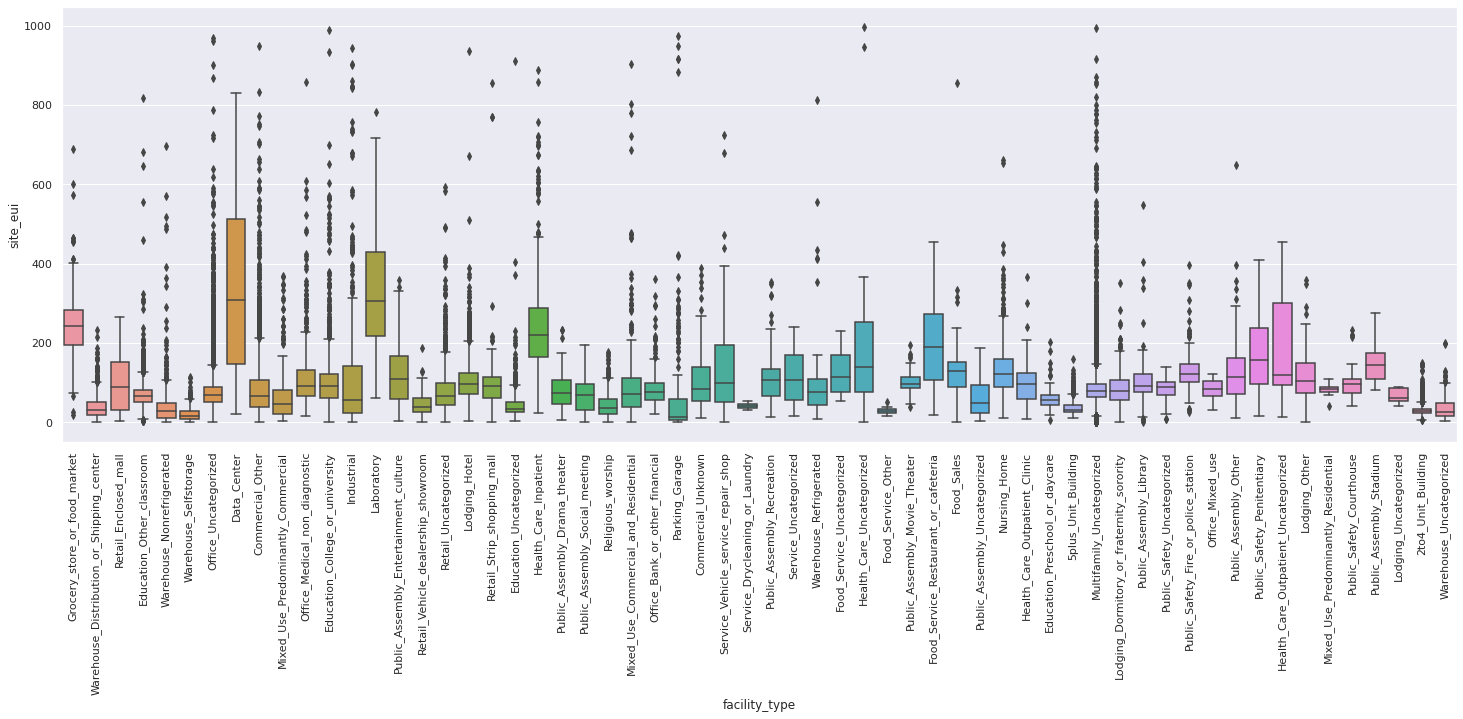

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
def scatter_plot_site_eui_by_facility(df, cat):
    cat_df = df.loc[df['facility_type'].str.startswith(cat)]
    sns.set(rc={'figure.figsize':(25,8)})
    ax = sns.boxplot(data=cat_df, x='facility_type', y='site_eui')
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
cat_list = ['Commercial', 'Education', 'Food_Service', 'Health_Care', 'Lodging', 'Office', 'Public_Assembly', 'Public_Safety', 'Retail', 'Service', 'Warehouse']
v = interactive(lambda cat: scatter_plot_site_eui_by_facility(train_df, cat), cat=cat_list)
display(v)

interactive(children=(Dropdown(description='cat', options=('Commercial', 'Education', 'Food_Service', 'Health_…

In [ ]:
def reduce_facility_types(x):
    if x.endswith('Unit_Building'):
        return 'Unit_Building'
    if x.startswith('Commercial'):
        return 'Commercial'
    if x.startswith('Education') and x != 'Education_College_or_university':
        return 'Education_others'
    if x.startswith('Lodging') and x != 'Lodging_Hotel':
        return 'Lodging_others'
    if x.startswith('Office') and x != 'Office_Uncategorized':
        return 'Office_others'
    if x.startswith('Warehouse') and x != 'Warehouse_Refrigerated':
        return 'Warehouse_others'
    if x.startswith('Mixed_Use'):
        return 'Mixed_Use'
    if x.startswith('Health_Care'):
        return 'Health_Care'
    if x.startswith('Public_Assembly'):
        return 'Public_Assembly'
    return x

In [ ]:
train_df['facility_type_reduced'] = [ reduce_facility_types(x) for x in train_df['facility_type']]

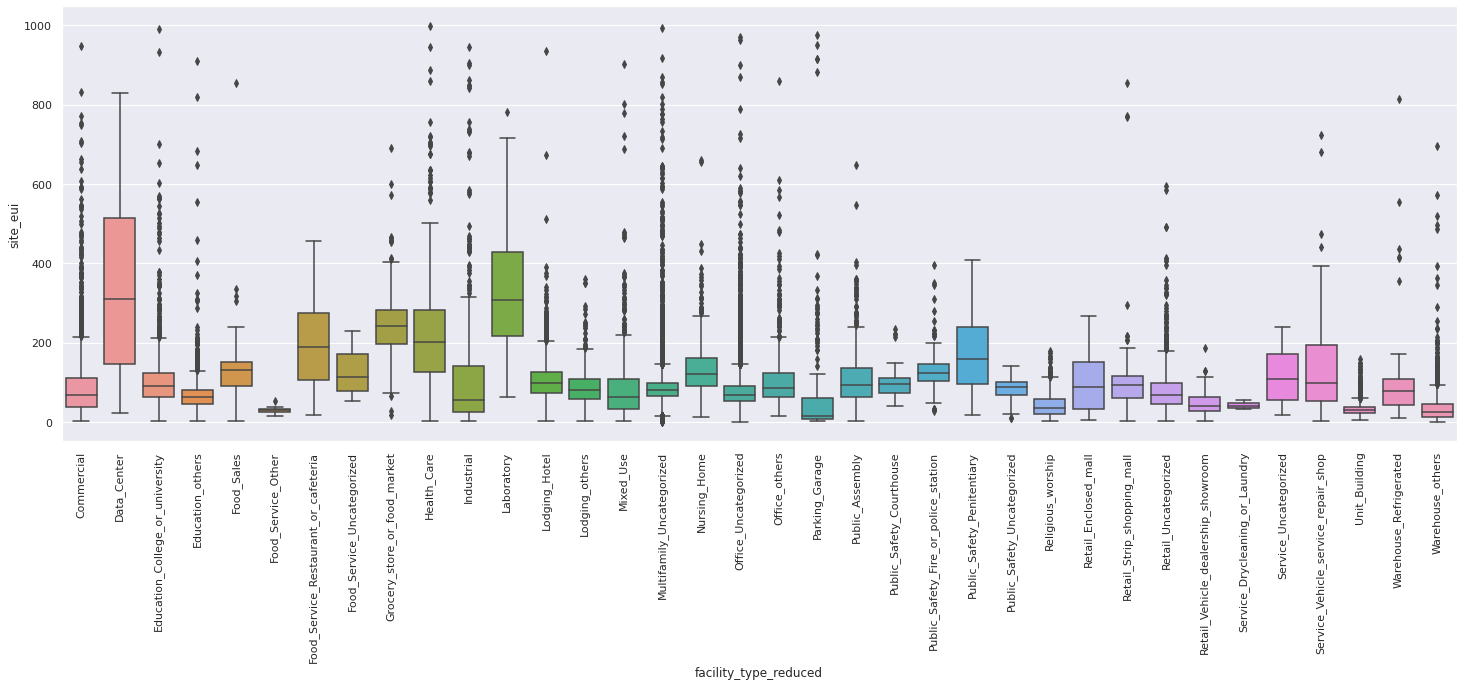

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type_reduced', y='site_eui', order=sorted(list(set(train_df['facility_type_reduced']))))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
train_df.groupby('facility_type_reduced')['id'].count().reset_index().sort_values('id', ascending=False).head(100)

facility_type_reduced     id
15             Multifamily_Uncategorized  39455
17                  Office_Uncategorized  12512
3                       Education_others   4677
33                         Unit_Building   3166
35                      Warehouse_others   2766
12                         Lodging_Hotel   2098
0                             Commercial   1839
28                  Retail_Uncategorized   1130
2        Education_College_or_university   1056
14                             Mixed_Use    937
16                          Nursing_Home    772
13                        Lodging_others    749
20                       Public_Assembly    715
18                         Office_others    638
9                            Health_Care    552
8           Grocery_store_or_food_market    448
25                     Religious_worship    399
10                            Industrial    384
19                        Parking_Garage    251
22  Public_Safety_Fire_or_police_station    157
32   Service_Vehicle_service_repair_shop    138
26                  Retail_Enclosed_mall    120
34                Warehouse_Refrigerated    113
27            Retail_Strip_shopping_mall    113
11                            Laboratory    107
29    Retail_Vehicle_dealership_showroom     74
4                             Food_Sales     70
31                 Service_Uncategorized     68
6   Food_Service_Restaurant_or_cafeteria     64
24           Public_Safety_Uncategorized     43
21              Public_Safety_Courthouse     38
23            Public_Safety_Penitentiary     37
1                            Data_Center     27
7             Food_Service_Uncategorized     18
5                     Food_Service_Other     17
30        Service_Drycleaning_or_Laundry      9

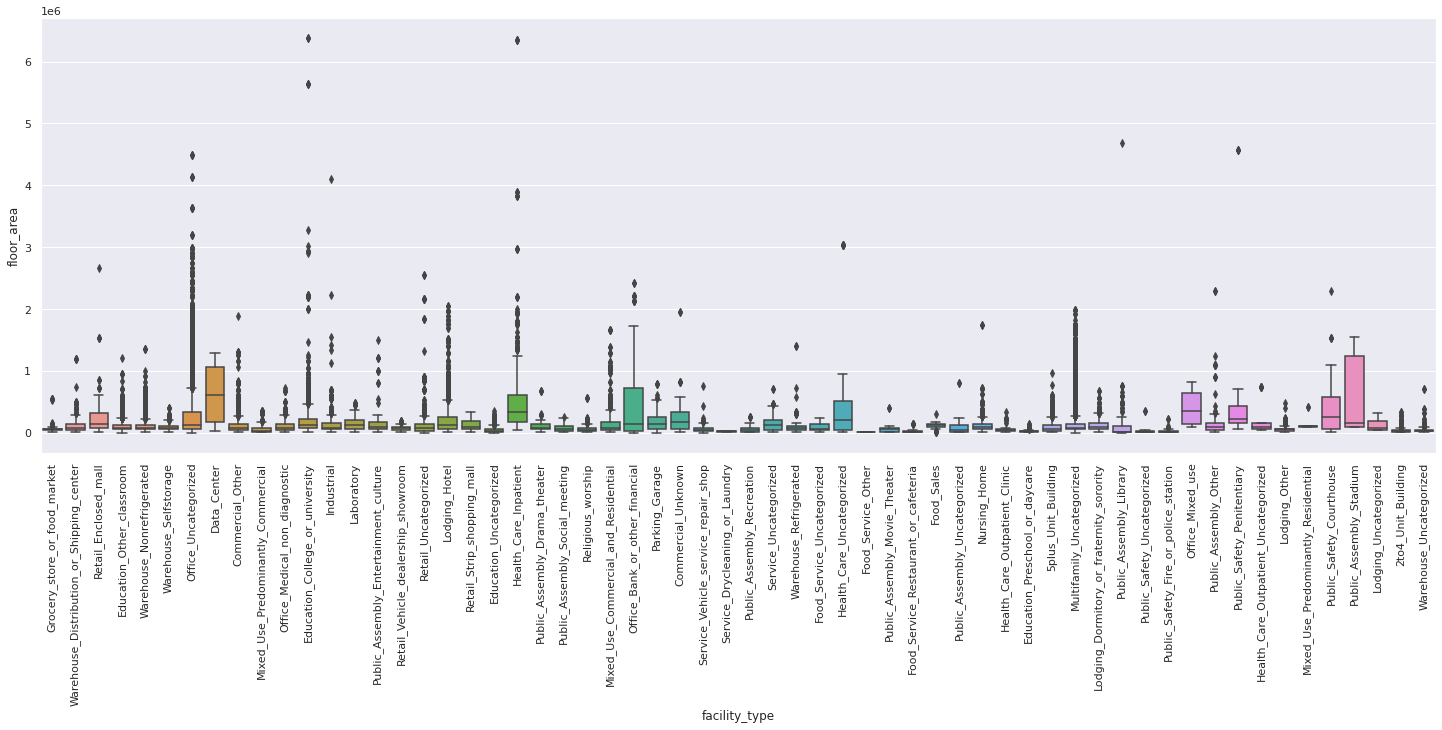

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='floor_area')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
facility_type_df = train_df.groupby(['facility_type'])['building_class'].apply(set)

In [ ]:
facility_type_df.head(100)

facility_type
2to4_Unit_Building                           {Residential}
5plus_Unit_Building                          {Residential}
Commercial_Other                              {Commercial}
Commercial_Unknown                            {Commercial}
Data_Center                                   {Commercial}
Education_College_or_university               {Commercial}
Education_Other_classroom                     {Commercial}
Education_Preschool_or_daycare                {Commercial}
Education_Uncategorized                       {Commercial}
Food_Sales                                    {Commercial}
Food_Service_Other                            {Commercial}
Food_Service_Restaurant_or_cafeteria          {Commercial}
Food_Service_Uncategorized                    {Commercial}
Grocery_store_or_food_market                  {Commercial}
Health_Care_Inpatient                         {Commercial}
Health_Care_Outpatient_Clinic                 {Commercial}
Health_Care_Outpatient_Uncategorized      

**2.5 Floor area**

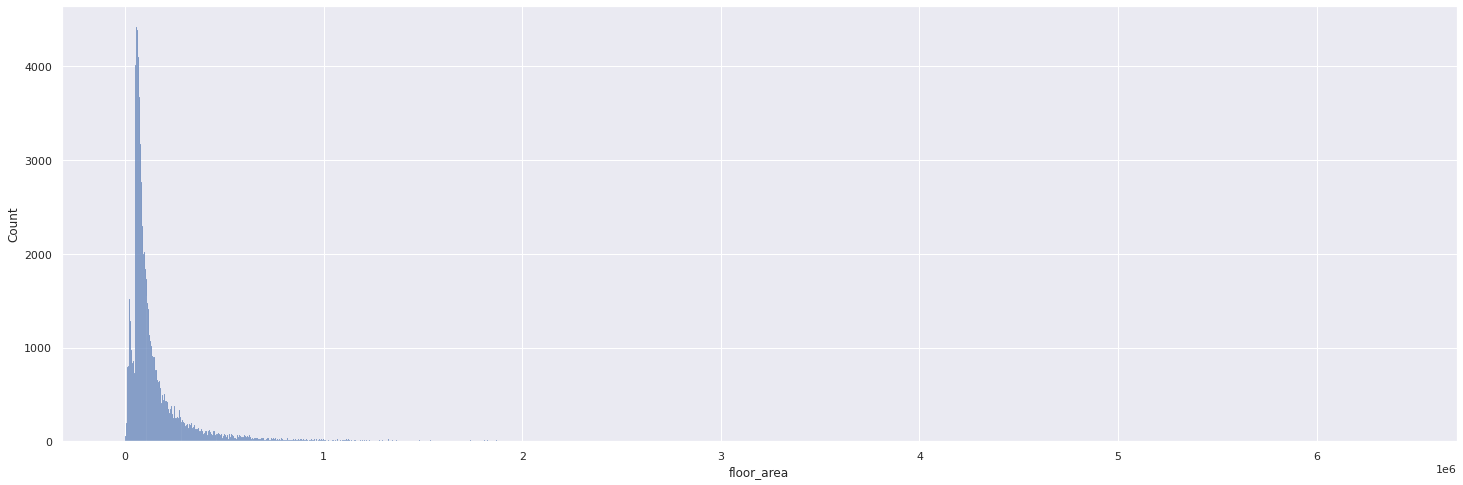

In [ ]:
sns.histplot(train_df['floor_area'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


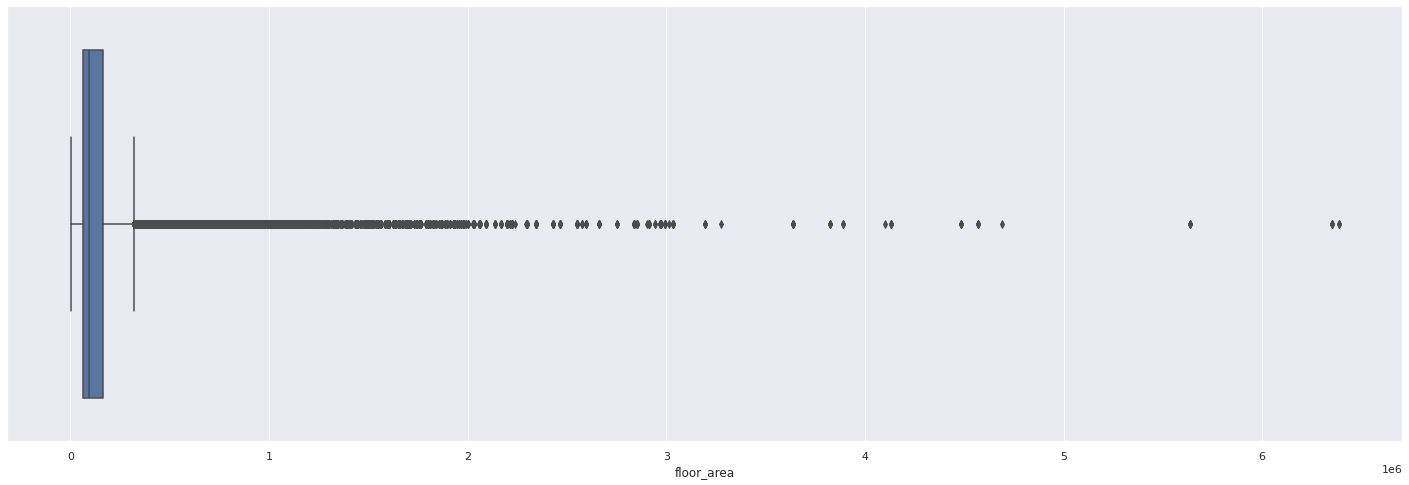

In [ ]:
sns.boxplot(train_df['floor_area'])

In [ ]:
train_df[train_df['floor_area']> 3e6]

Year_Factor State_Factor  ...     id            facility_type_reduced
5853             3      State_2  ...   5853  Education_College_or_university
6931             4      State_2  ...   6931  Education_College_or_university
8411             5      State_2  ...   8411  Education_College_or_university
8419             5      State_2  ...   8419  Education_College_or_university
9122             6      State_2  ...   9122                       Industrial
9907             6      State_2  ...   9907  Education_College_or_university
10522            4      State_4  ...  10522       Public_Safety_Penitentiary
10572            4      State_4  ...  10572                      Health_Care
10608            4      State_4  ...  10608             Office_Uncategorized
10646            4      State_4  ...  10646             Office_Uncategorized
10670            4      State_4  ...  10670             Office_Uncategorized
11077            5      State_4  ...  11077       Public_Safety_Penitentiary
11309            5      State_4  ...  11309                      Health_Care
11385            5      State_4  ...  11385             Office_Uncategorized
11477            5      State_4  ...  11477             Office_Uncategorized
11542            5      State_4  ...  11542             Office_Uncategorized
12791            6      State_4  ...  12791       Public_Safety_Penitentiary
13151            6      State_4  ...  13151                      Health_Care
13251            6      State_4  ...  13251             Office_Uncategorized
13378            6      State_4  ...  13378             Office_Uncategorized
13459            6      State_4  ...  13459             Office_Uncategorized
16350            1      State_6  ...  16350                      Health_Care
16374            1      State_6  ...  16374  Education_College_or_university
16412            1      State_6  ...  16412  Education_College_or_university
19416            2      State_6  ...  19416                      Health_Care
20072            2      State_6  ...  20072             Office_Uncategorized
30709            3      State_6  ...  30709                      Health_Care
32477            3      State_6  ...  32477             Office_Uncategorized
35611            4      State_6  ...  35611                  Public_Assembly
39757            4      State_6  ...  39757                      Health_Care
41188            4      State_6  ...  41188                      Health_Care
41774            4      State_6  ...  41774             Office_Uncategorized
49655            5      State_6  ...  49655                      Health_Care
51149            5      State_6  ...  51149                      Health_Care
51800            5      State_6  ...  51800             Office_Uncategorized
61899            6      State_6  ...  61899                      Health_Care
64696            6      State_6  ...  64696             Office_Uncategorized
65900            3      State_8  ...  65900                      Health_Care
66710            4      State_8  ...  66710                      Health_Care
68585            6      State_8  ...  68585                      Health_Care

[40 rows x 65 columns]

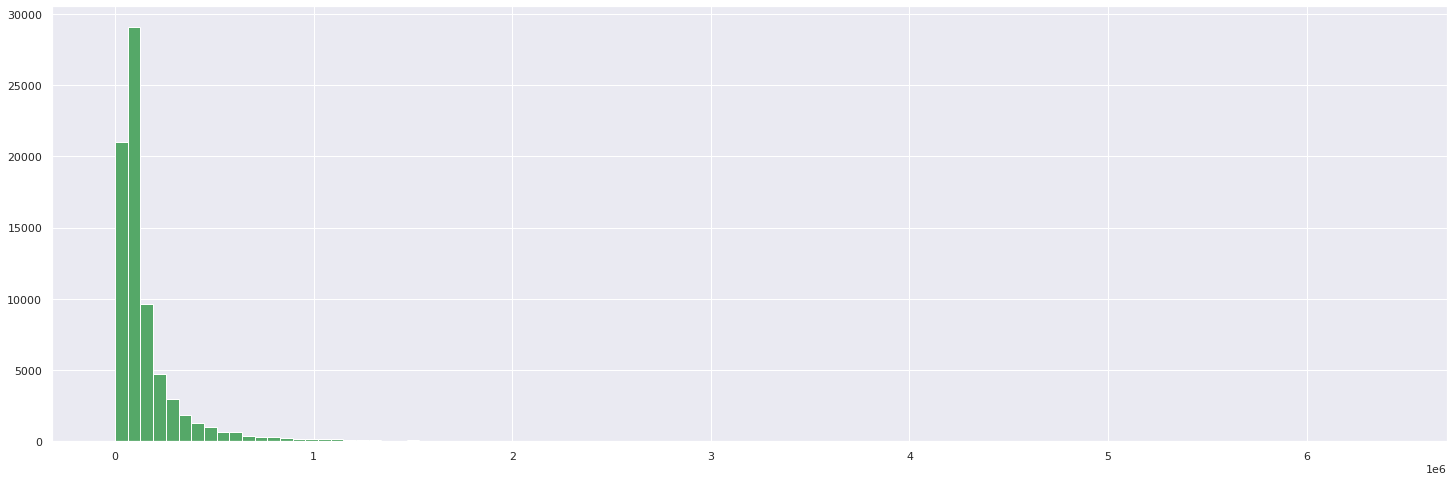

In [ ]:
# histogram of floor area
n, bins, patches = plt.hist(train_df['floor_area'], 100, density=False, facecolor='g')

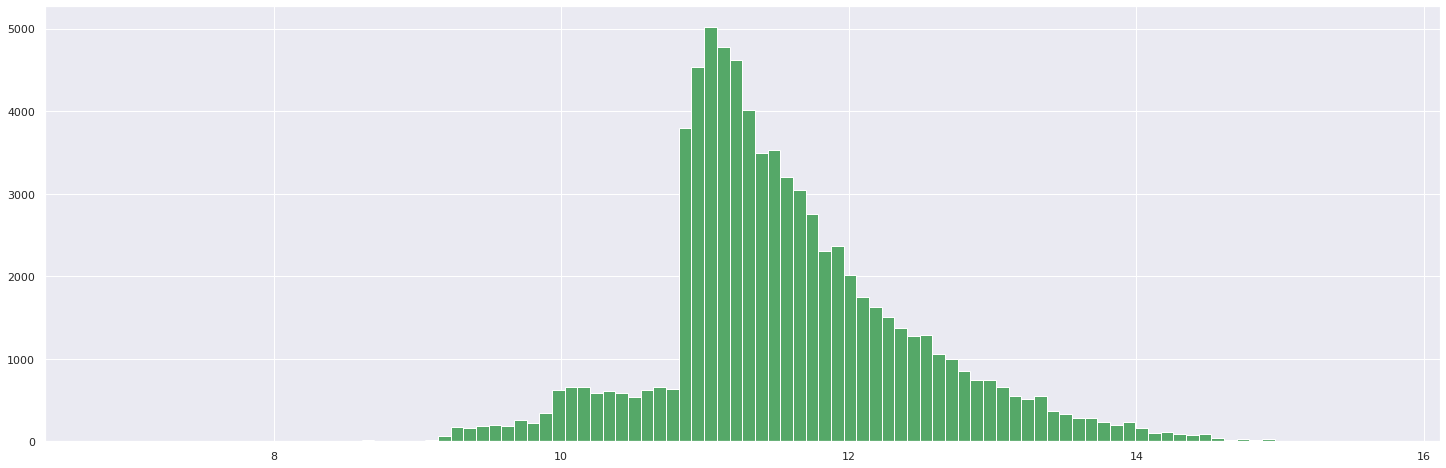

In [ ]:
# histogram of log of floor area
n, bins, patches = plt.hist(np.log(train_df['floor_area']), 100, density=False, facecolor='g')

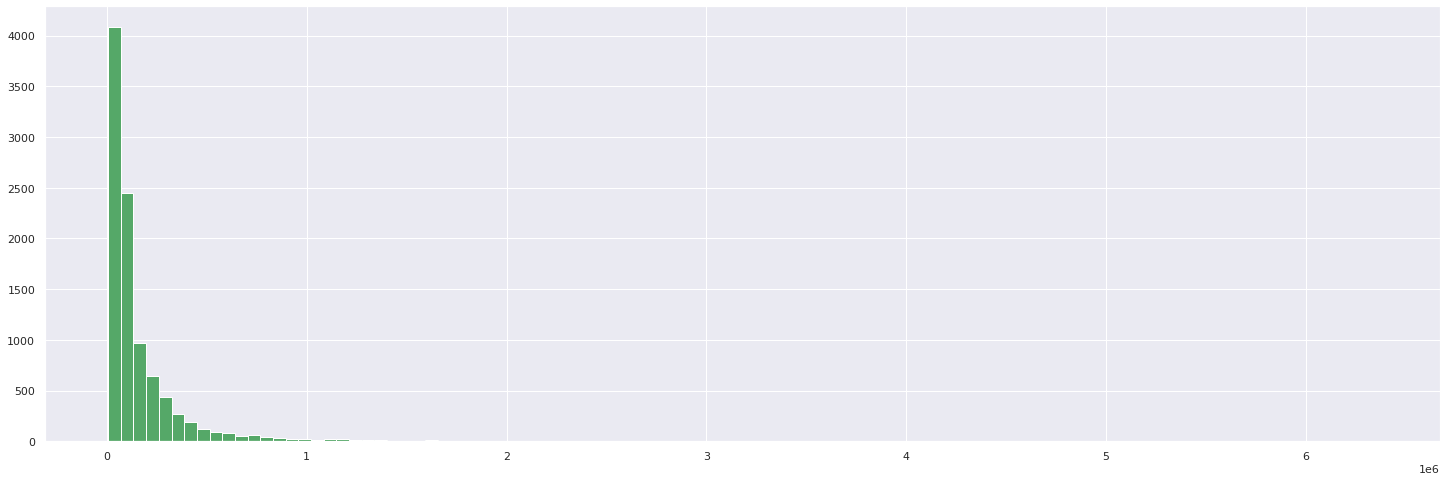

In [ ]:
n, bins, patches = plt.hist(test_df['floor_area'], 100, density=False, facecolor='g')

No handles with labels found to put in legend.


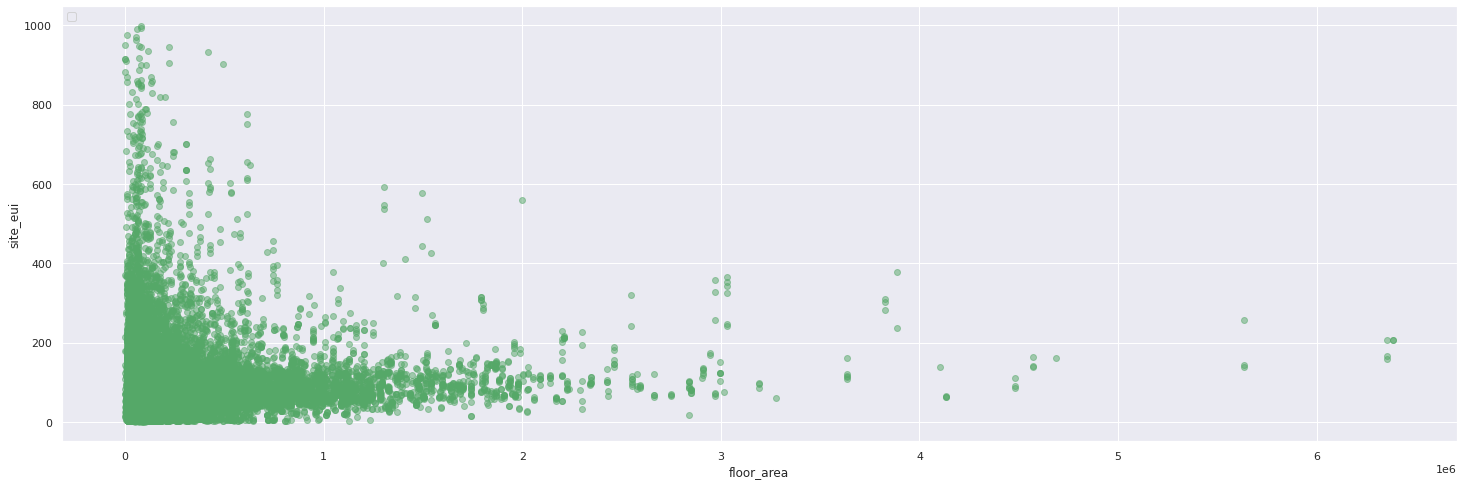

In [ ]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df['floor_area'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("floor_area")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

**2.6 Year built**

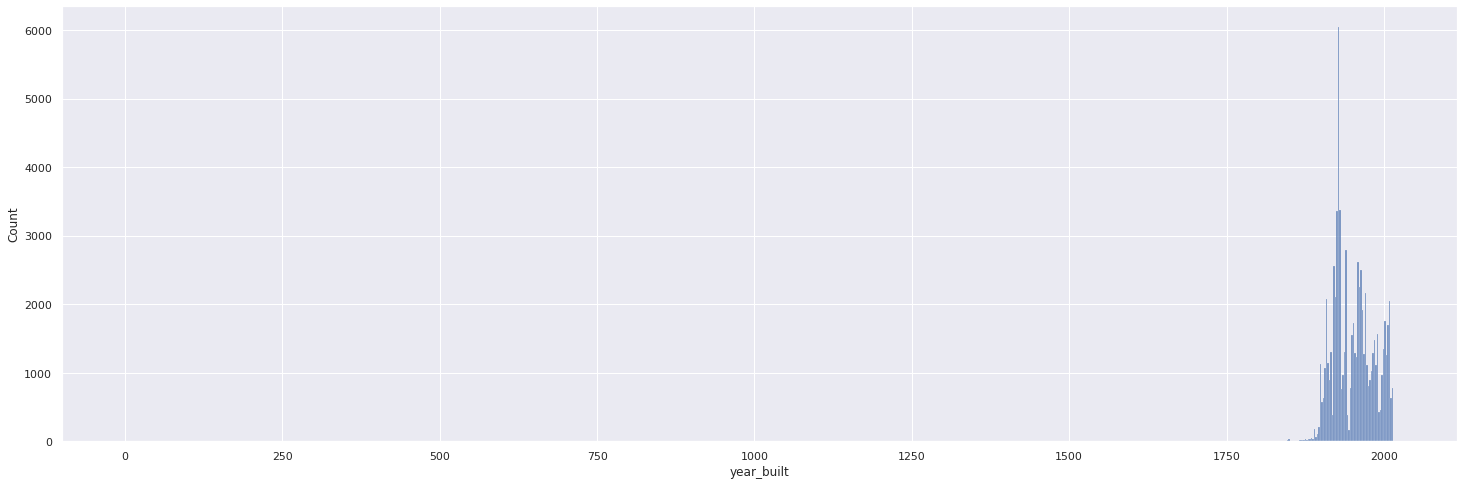

In [ ]:
sns.histplot(train_df['year_built'])

In [ ]:
train_df[train_df['year_built']== 0]

Year_Factor State_Factor  ...    id facility_type_reduced
353             1      State_1  ...   353         Lodging_Hotel
955             2      State_1  ...   955         Lodging_Hotel
2159            3      State_1  ...  2159         Lodging_Hotel
3415            4      State_1  ...  3415         Lodging_Hotel
4535            5      State_1  ...  4535         Lodging_Hotel
5571            6      State_1  ...  5571         Lodging_Hotel

[6 rows x 65 columns]

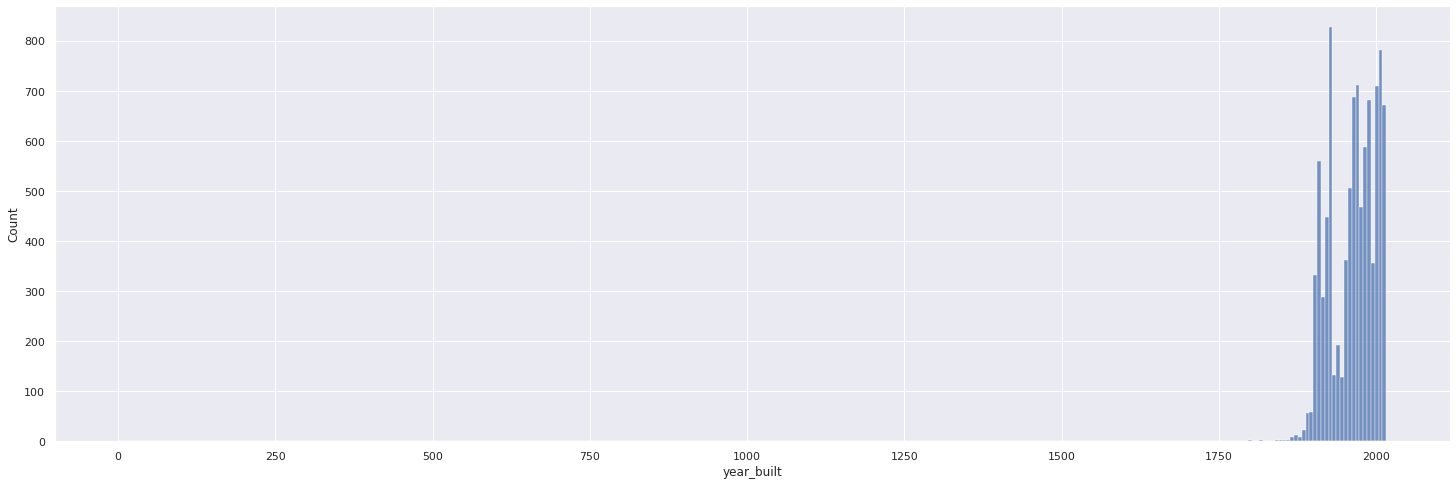

In [ ]:
sns.histplot(test_df['year_built'])

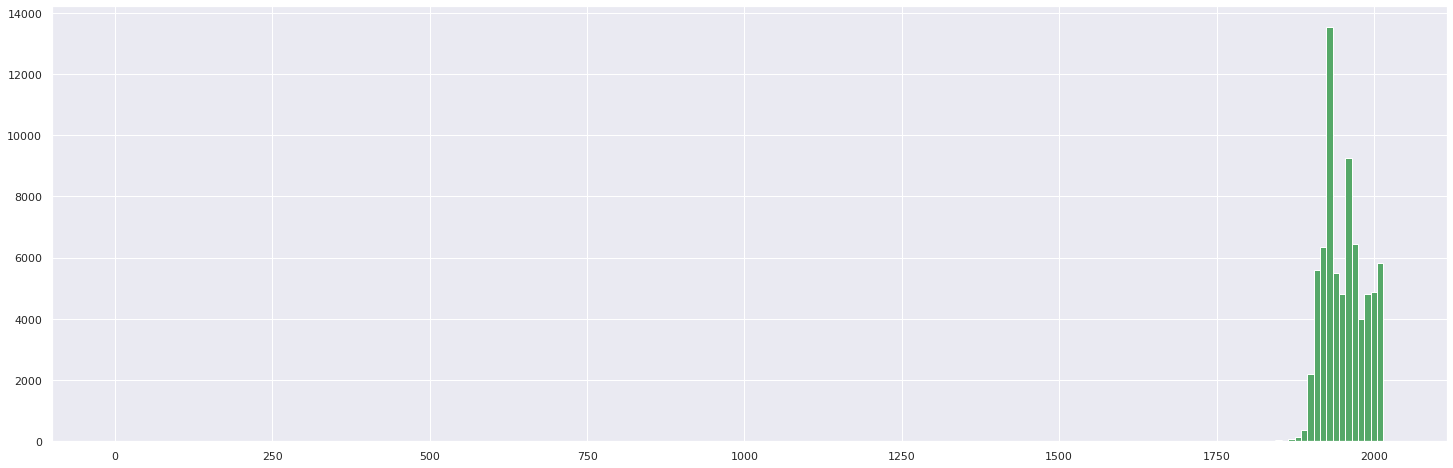

In [ ]:
# histogram of year built
n, bins, patches = plt.hist(train_df['year_built'], 200, density=False, facecolor='g')

In [ ]:
print(train_df.loc[train_df['year_built'] < 1600])

      Year_Factor State_Factor  ...    id facility_type_reduced
353             1      State_1  ...   353         Lodging_Hotel
955             2      State_1  ...   955         Lodging_Hotel
2159            3      State_1  ...  2159         Lodging_Hotel
3415            4      State_1  ...  3415         Lodging_Hotel
4535            5      State_1  ...  4535         Lodging_Hotel
5571            6      State_1  ...  5571         Lodging_Hotel

[6 rows x 65 columns]


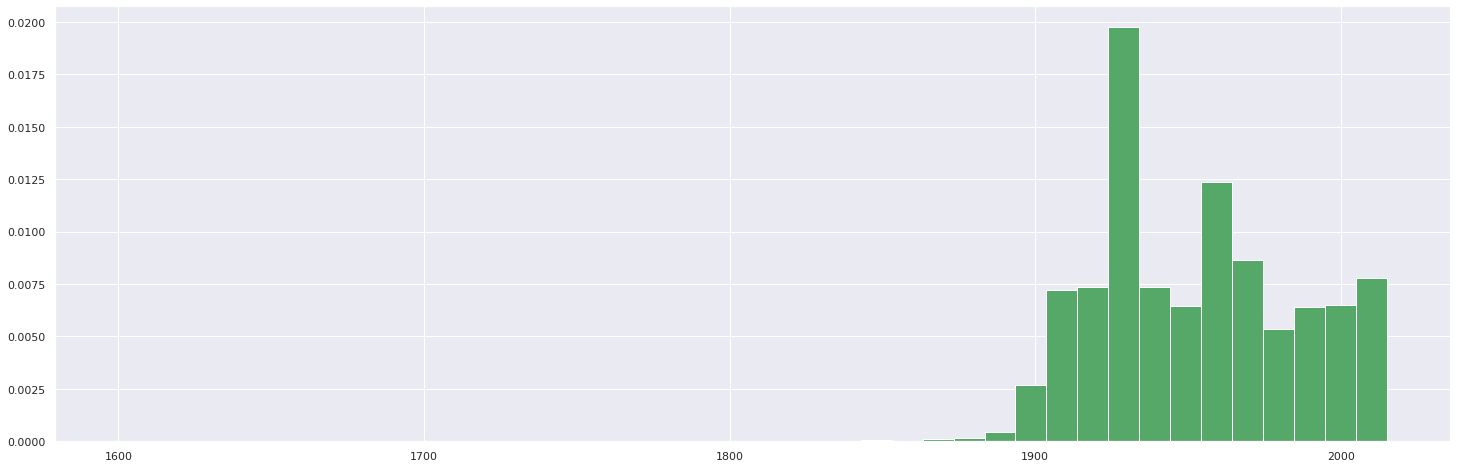

In [ ]:
n, bins, patches = plt.hist(train_df.loc[train_df['year_built'] >= 1600, 'year_built'], (2015 - 1600)//10, density=True, facecolor='g')


No handles with labels found to put in legend.


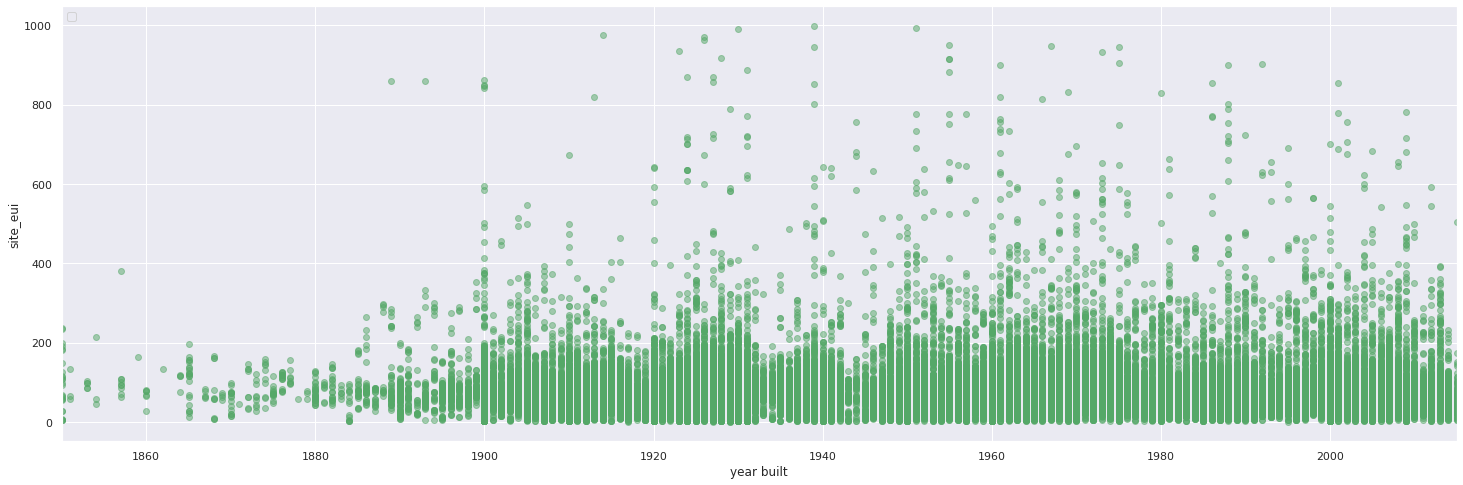

In [ ]:
# scatter plot to see correlation between year built and site_eui
plt.scatter(train_df['year_built'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("year built")
plt.ylabel("site_eui")
plt.xlim(1850, 2015)
plt.legend(loc='upper left')
plt.show()

**2.7 Energy Star Rating**

In [ ]:
train_df['energy_star_rating'].isnull().sum()

26709

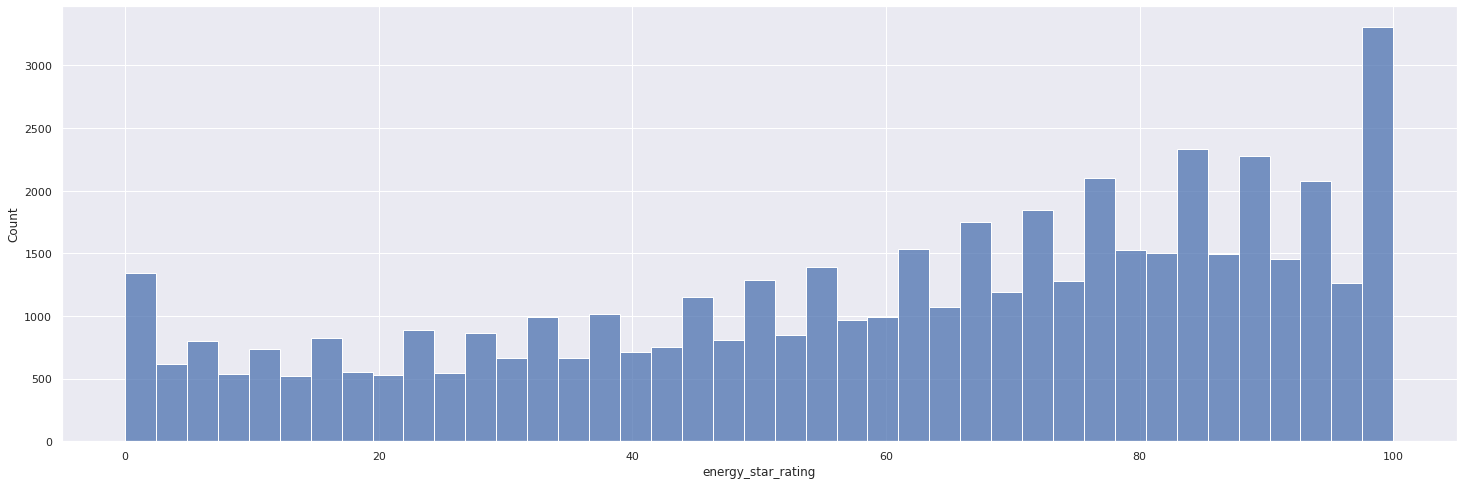

In [ ]:
sns.histplot(train_df['energy_star_rating'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


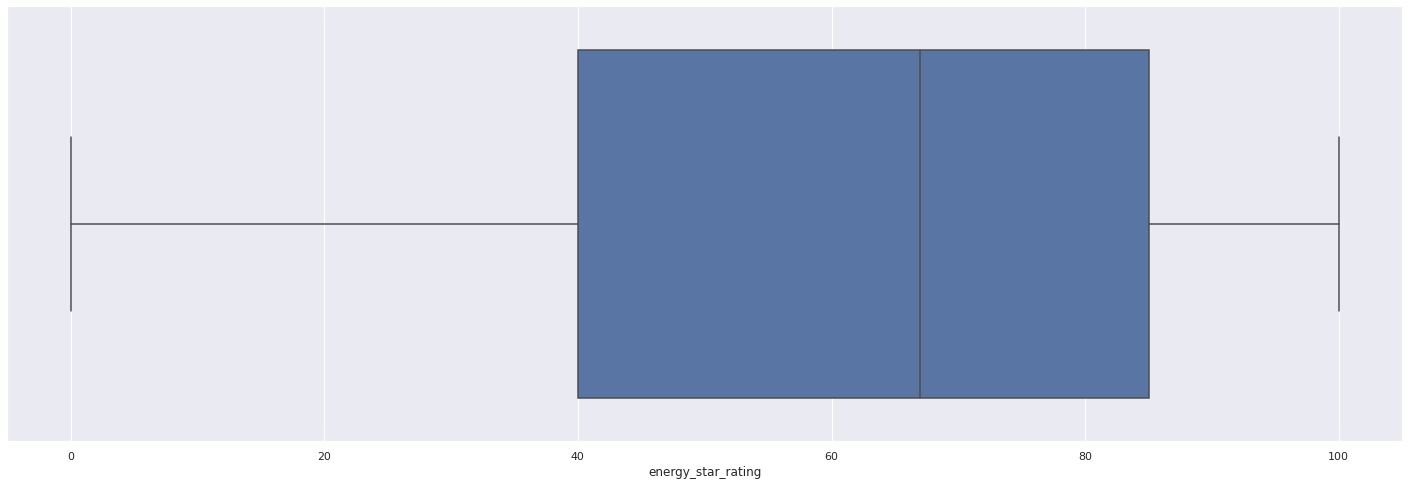

In [ ]:
sns.boxplot(train_df['energy_star_rating'])

In [ ]:
test_df['energy_star_rating'].isnull().sum()

2254

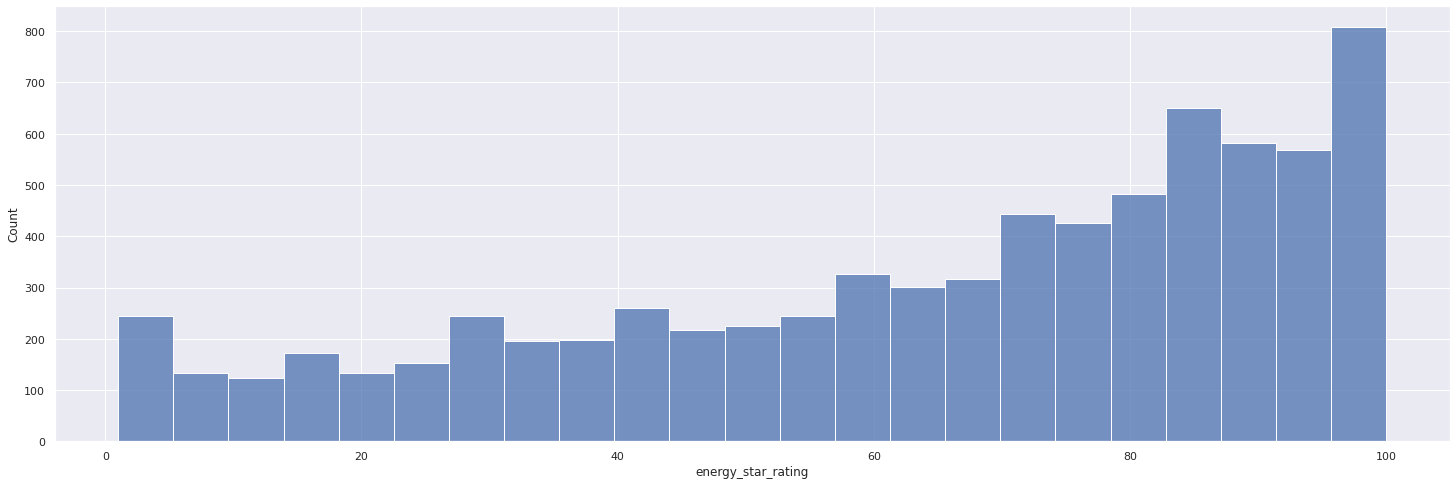

In [ ]:
sns.histplot(test_df['energy_star_rating'])

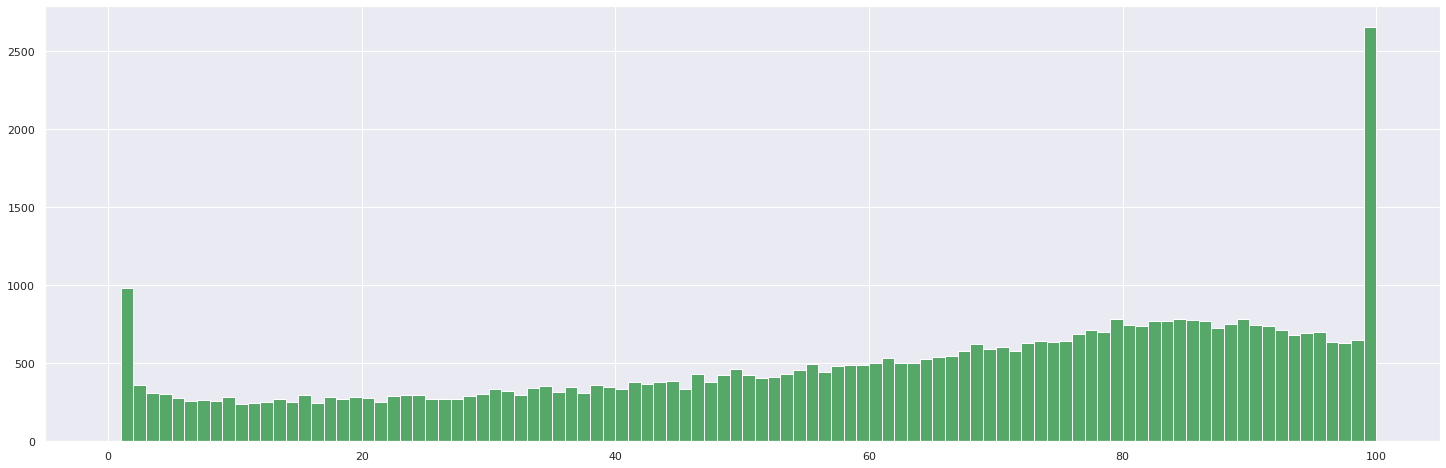

In [ ]:
n, bins, patches = plt.hist(train_df['energy_star_rating'], 100, density=False, facecolor='g')

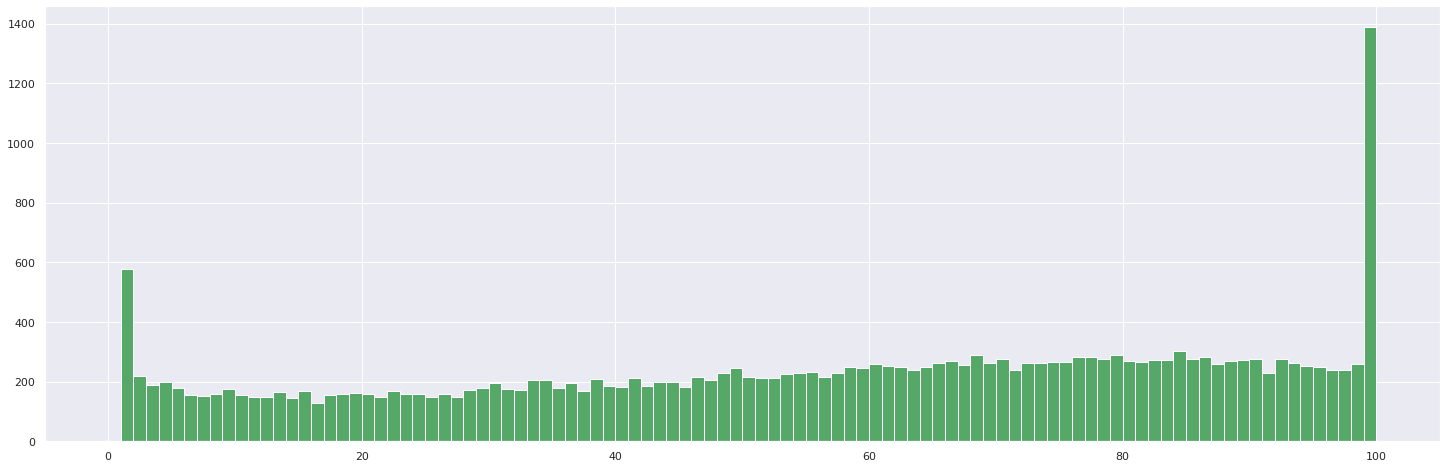

In [ ]:
cat_df = train_df.loc[train_df['facility_type'] == 'Multifamily_Uncategorized']
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')

7.516129032258065


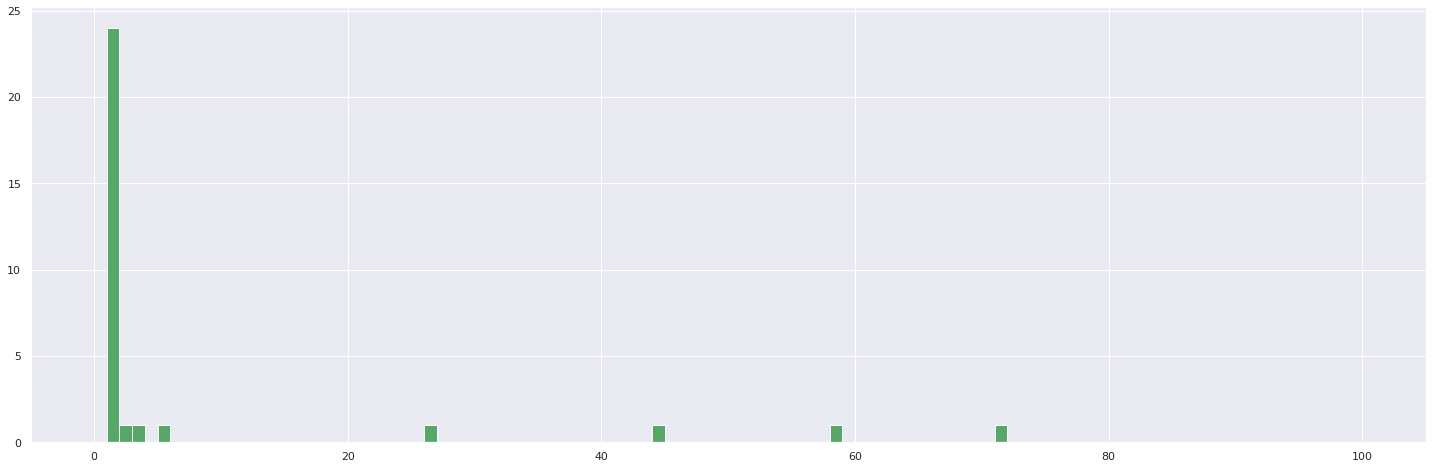

In [ ]:
cat_df = train_df.loc[(train_df['facility_type'] == 'Multifamily_Uncategorized') & (train_df['site_eui'] > 400)]
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')
print(np.mean(cat_df['energy_star_rating']))

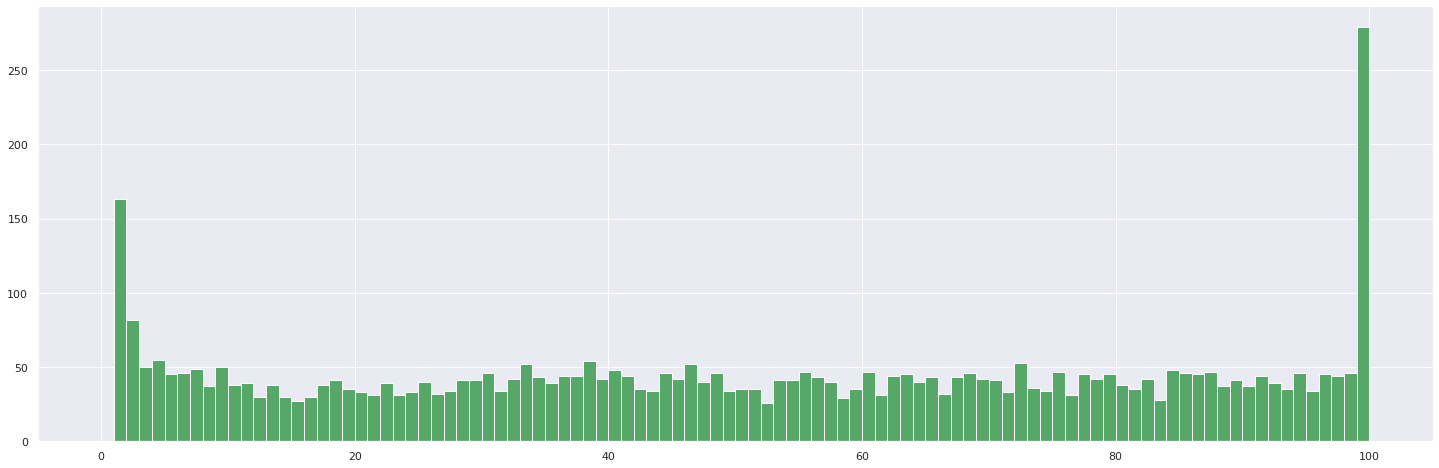

In [ ]:
cat_df = train_df.loc[(train_df['facility_type'] == 'Multifamily_Uncategorized') & (train_df['year_built'] > 1980)]
n, bins, patches = plt.hist(cat_df['energy_star_rating'], 100, range=(0, 100), density=False, facecolor='g')

No handles with labels found to put in legend.


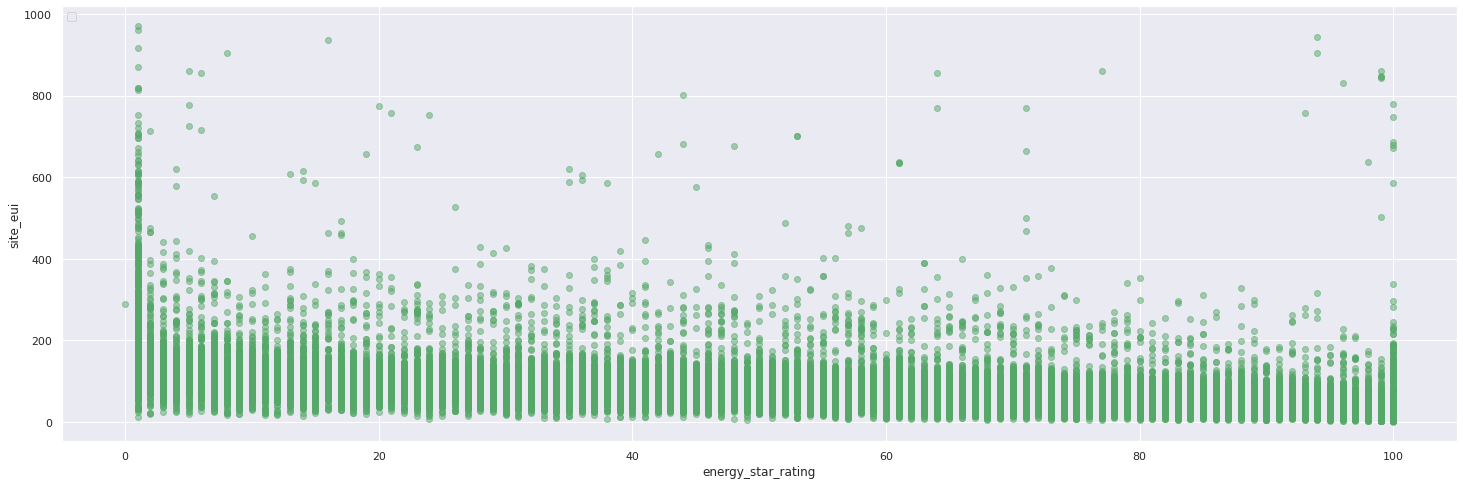

In [ ]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df['energy_star_rating'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


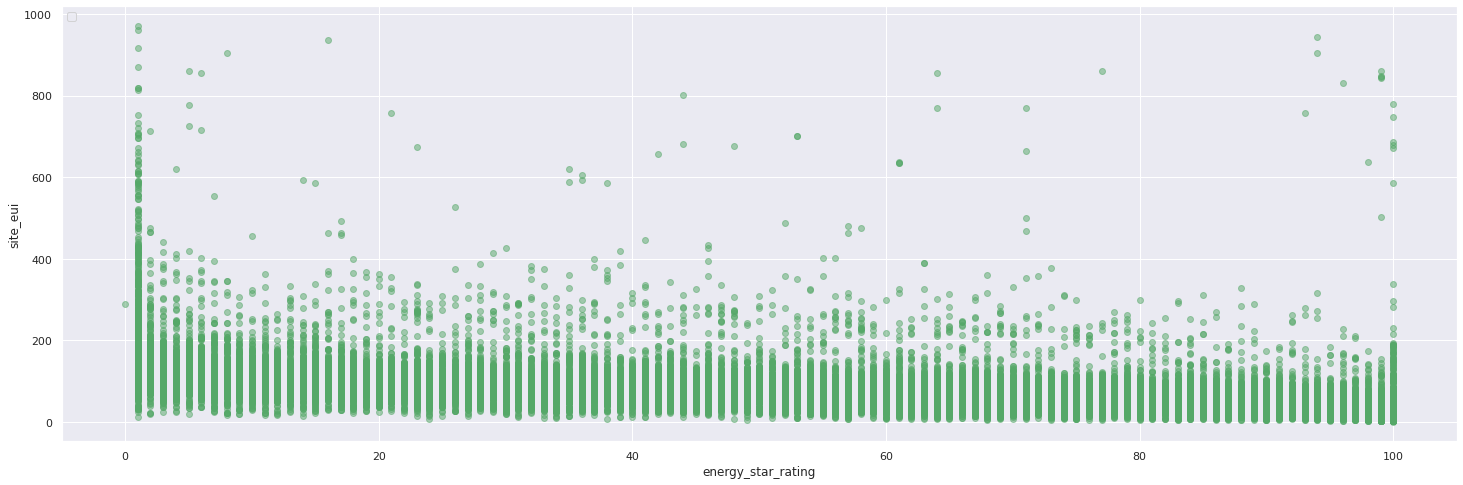

In [ ]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['floor_area'] < 0.5 * 1000000, 'energy_star_rating'], train_df.loc[train_df['floor_area'] < 0.5 * 1000000, 'site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

In [ ]:
train_df.loc[(train_df['energy_star_rating'] > 90) & (train_df['site_eui'] > 400)]

Year_Factor State_Factor  ...     id facility_type_reduced
14842            1      State_6  ...  14842           Data_Center
65650            3      State_8  ...  65650            Industrial
65691            3      State_8  ...  65691            Industrial
66100            3      State_8  ...  66100            Industrial
66463            4      State_8  ...  66463            Industrial
66506            4      State_8  ...  66506            Industrial
66913            4      State_8  ...  66913            Industrial
67344            5      State_8  ...  67344            Industrial
67797            5      State_8  ...  67797            Industrial
68253            6      State_8  ...  68253            Industrial
68903            6      State_8  ...  68903            Industrial
70942            5     State_11  ...  70942             Mixed_Use
72545            6     State_11  ...  72545            Commercial
73983            6     State_11  ...  73983            Commercial
74117            6     State_11  ...  74117            Commercial
74155            6     State_11  ...  74155             Mixed_Use

[16 rows x 65 columns]

No handles with labels found to put in legend.


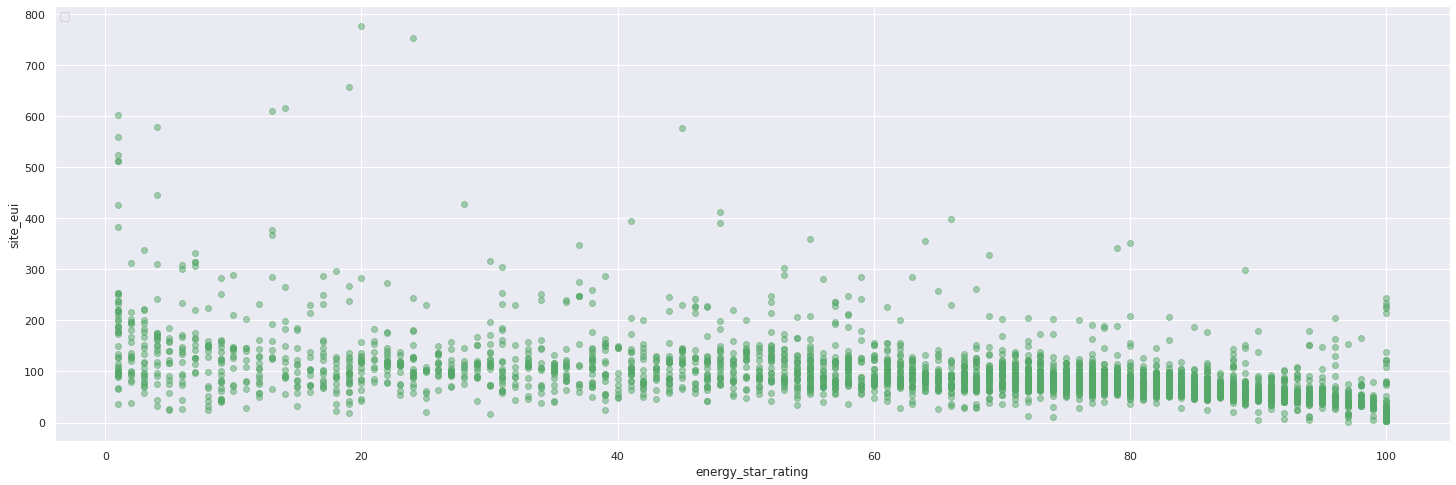

In [ ]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['floor_area'] > 0.5 * 1000000, 'energy_star_rating'], train_df.loc[train_df['floor_area'] > 0.5 * 1000000, 'site_eui'], c="g", alpha=0.5)
plt.xlabel("energy_star_rating")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

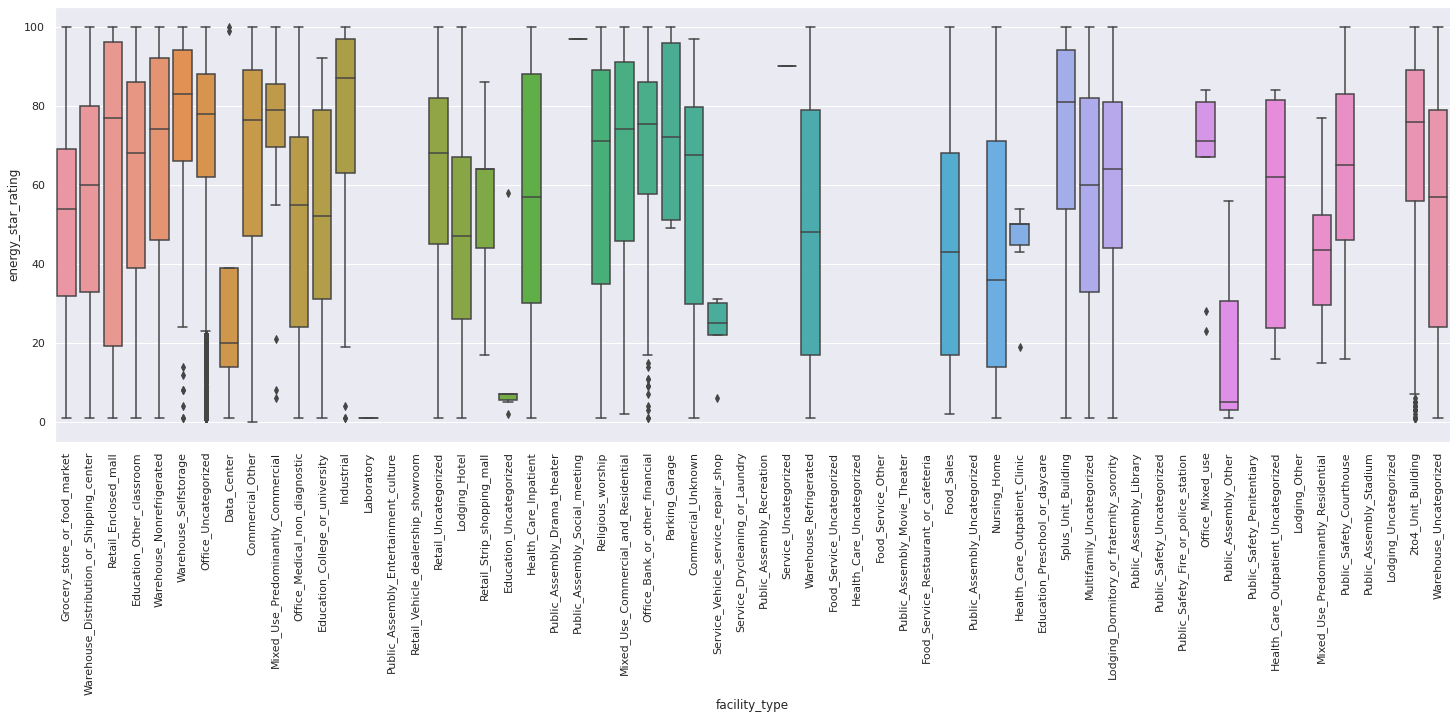

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='facility_type', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

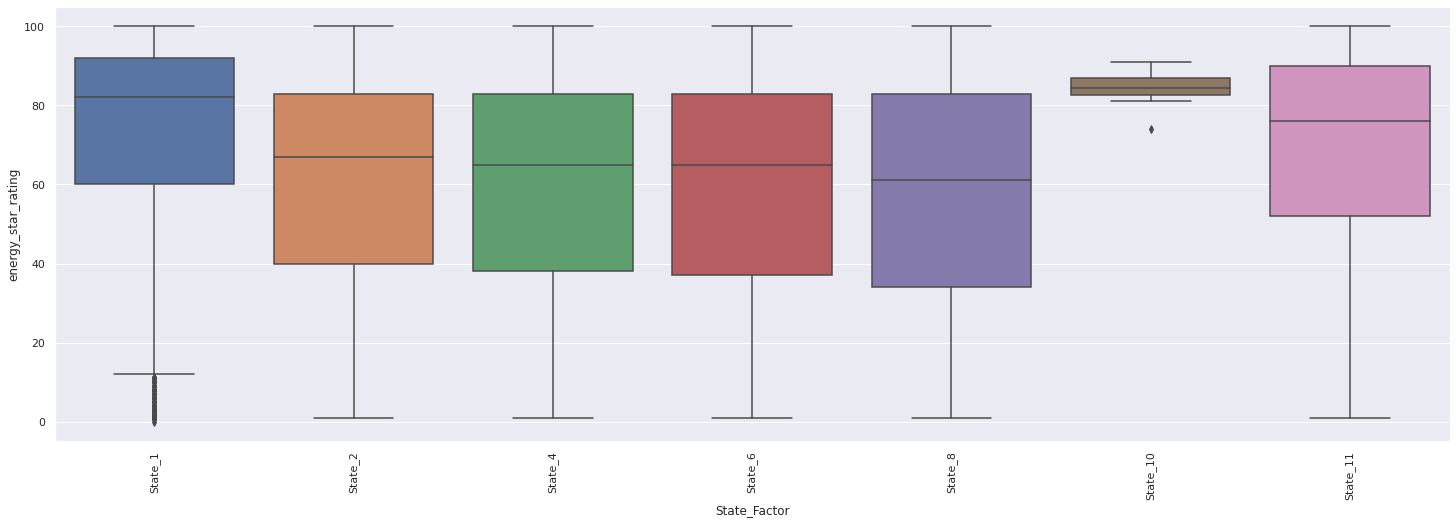

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='State_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

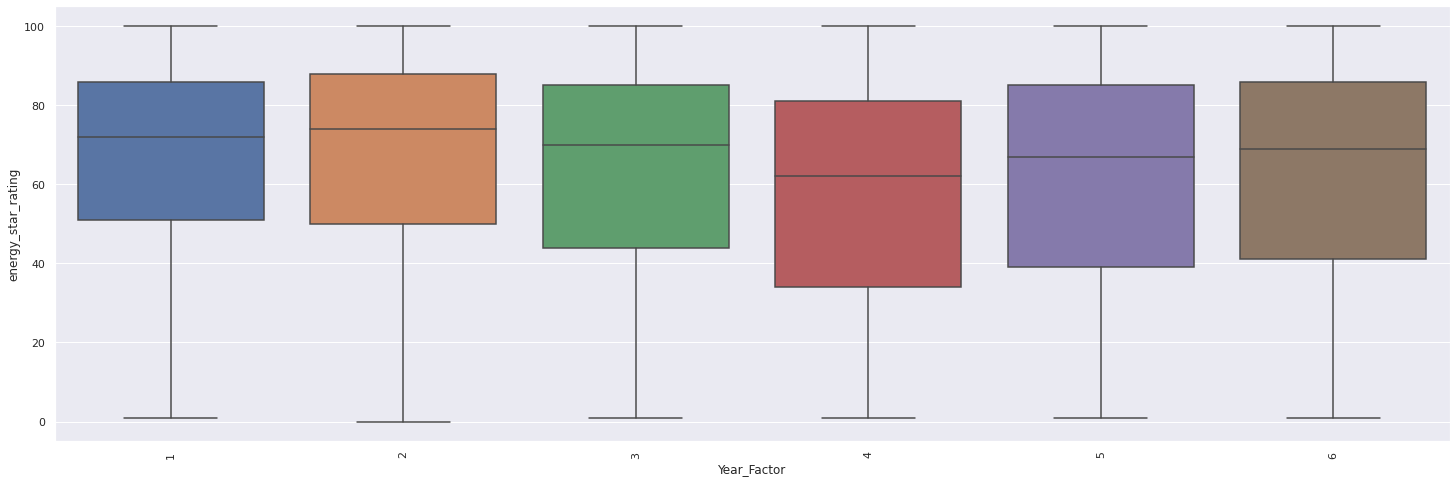

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=train_df, x='Year_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

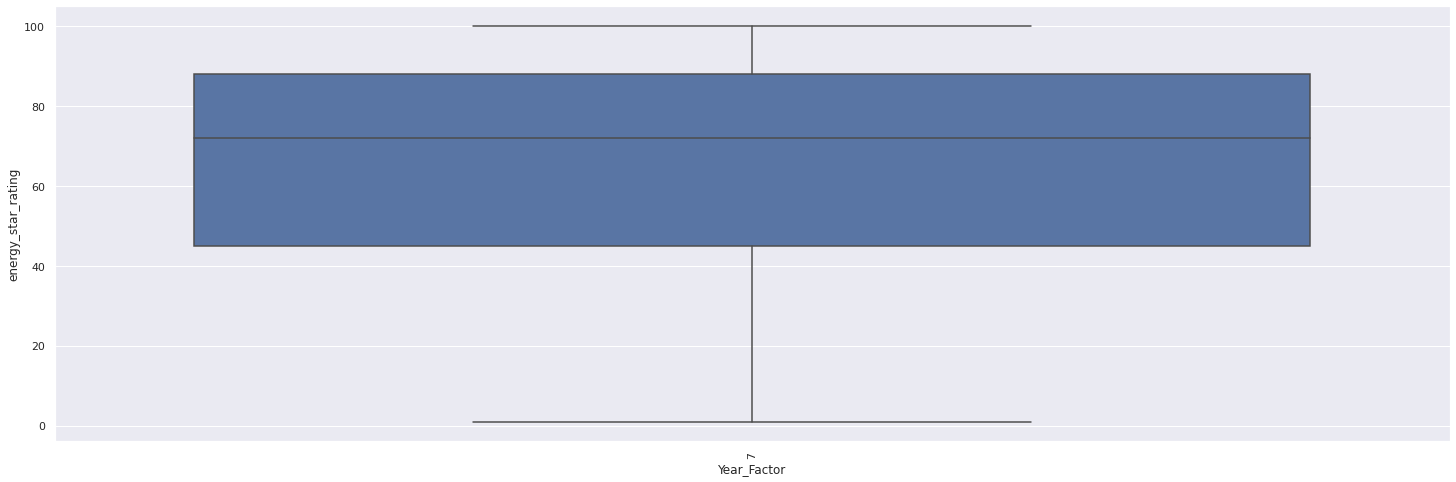

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})
ax = sns.boxplot(data=test_df, x='Year_Factor', y='energy_star_rating')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

No handles with labels found to put in legend.


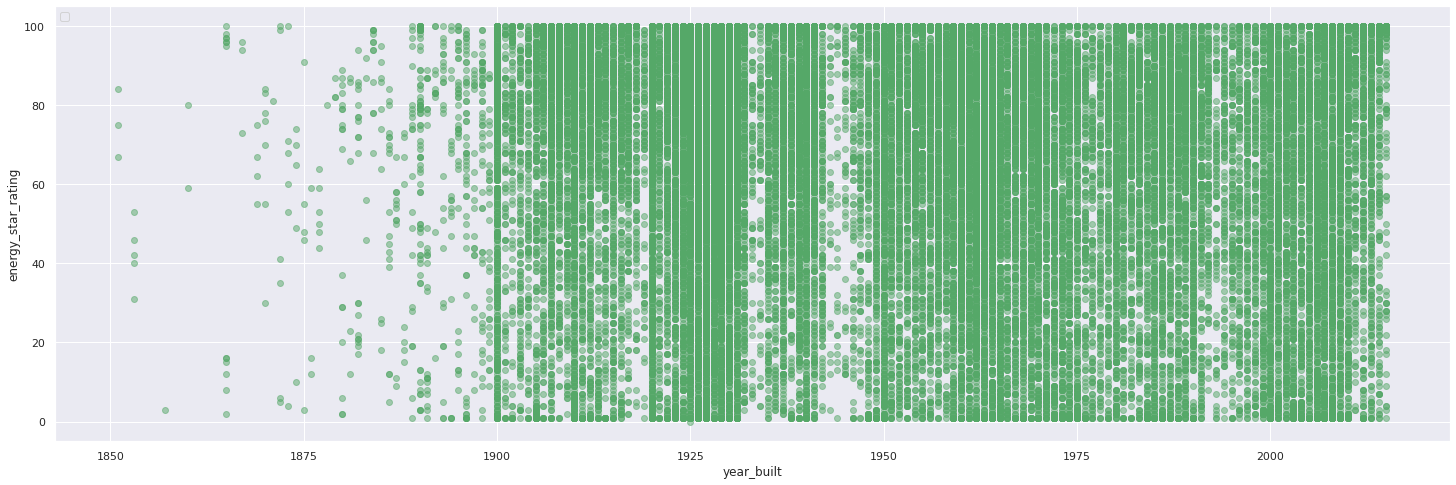

In [ ]:
# scatter plot to see correlation between year and site_eui
plt.scatter(train_df.loc[train_df['year_built'] > 1850, 'year_built'], train_df.loc[train_df['year_built'] > 1850, 'energy_star_rating'], c="g", alpha=0.5)
plt.xlabel("year_built")
plt.ylabel("energy_star_rating")
plt.legend(loc='upper left')
plt.show()

In [ ]:
x = train_df.loc[(train_df['year_built'] > 1850) & (train_df['energy_star_rating'].notnull()), 'year_built']
y = train_df.loc[(train_df['year_built'] > 1850) & (train_df['energy_star_rating'].notnull()), 'energy_star_rating']

In [ ]:
np.corrcoef(x, y)

array([[ 1.        , -0.08845305],
       [-0.08845305,  1.        ]])

In [ ]:
null_counts_df = train_df.groupby(['facility_type'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['facility_type'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='facility_type')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

facility_type   null  not_null  null_percentage
51         Retail_Vehicle_dealership_showroom     74         0         1.000000
41                    Public_Assembly_Stadium      9         0         1.000000
23                      Lodging_Uncategorized      5         0         1.000000
17                  Health_Care_Uncategorized     51         0         1.000000
36                    Public_Assembly_Library    160         0         1.000000
42              Public_Assembly_Uncategorized     25         0         1.000000
44       Public_Safety_Fire_or_police_station    157         0         1.000000
45                 Public_Safety_Penitentiary     37         0         1.000000
12                 Food_Service_Uncategorized     18         0         1.000000
11       Food_Service_Restaurant_or_cafeteria     64         0         1.000000
10                         Food_Service_Other     17         0         1.000000
46                Public_Safety_Uncategorized     43         0         1.000000
7              Education_Preschool_or_daycare    108         0         1.000000
35      Public_Assembly_Entertainment_culture    110         0         1.000000
34              Public_Assembly_Drama_theater     70         0         1.000000
37              Public_Assembly_Movie_Theater     39         0         1.000000
52             Service_Drycleaning_or_Laundry      9         0         1.000000
39                 Public_Assembly_Recreation     72         0         1.000000
22                              Lodging_Other     75         0         1.000000
8                     Education_Uncategorized    702         7         0.990127
40             Public_Assembly_Social_meeting     87         1         0.988636
53                      Service_Uncategorized     67         1         0.985294
19                                 Laboratory    105         2         0.981308
38                      Public_Assembly_Other    139         3         0.978873
33                             Parking_Garage    242         9         0.964143
54        Service_Vehicle_service_repair_shop    133         5         0.963768
5             Education_College_or_university    991        65         0.938447
58                      Warehouse_Selfstorage    524        53         0.908146
15              Health_Care_Outpatient_Clinic     50         6         0.892857
18                                 Industrial    341        43         0.888021
49                 Retail_Strip_shopping_mall    100        13         0.884956
48                       Retail_Enclosed_mall    104        16         0.866667
2                            Commercial_Other   1488       256         0.853211
25         Mixed_Use_Predominantly_Commercial    217        39         0.847656
16       Health_Care_Outpatient_Uncategorized     30         6         0.833333
3                          Commercial_Unknown     73        22         0.768421
24       Mixed_Use_Commercial_and_Residential    504       168         0.750000
4                                 Data_Center     18         9         0.666667
31                           Office_Mixed_use      9         9         0.500000
27                  Multifamily_Uncategorized  16411     23044         0.415942
50                       Retail_Uncategorized    281       849         0.248673
59                    Warehouse_Uncategorized     81       249         0.245455
56                  Warehouse_Nonrefrigerated    260       995         0.207171
47                          Religious_worship     76       323         0.190476
1                         5plus_Unit_Building    220      1053         0.172820
55  Warehouse_Distribution_or_Shipping_center    103       501         0.170530
9                                  Food_Sales     11        59         0.157143
20   Lodging_Dormitory_or_fraternity_sorority    105       564         0.156951
30              Office_Medical_non_diagnostic     66       381         0.147651
14                      Health_C

In [ ]:
sum(merge_df['null'])

26709

In [ ]:
null_counts_df = train_df.groupby(['State_Factor'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['State_Factor'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='State_Factor')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

State_Factor   null  not_null  null_percentage
5      State_6  20153     30687         0.396400
0      State_1   2069      3549         0.368281
6      State_8   1252      2449         0.338287
2     State_11   1517      4895         0.236588
3      State_2   1011      3860         0.207555
1     State_10      3        12         0.200000
4      State_4    704      3596         0.163721

In [ ]:
null_counts_df = train_df.groupby(['Year_Factor'])['energy_star_rating'].apply(lambda x: x.isnull().sum()).reset_index()
not_null_counts_df = train_df.groupby(['Year_Factor'])['energy_star_rating'].apply(lambda x: x.notnull().sum()).reset_index()
merge_df = null_counts_df.merge(not_null_counts_df, on='Year_Factor')
merge_df.rename({'energy_star_rating_x': 'null', 'energy_star_rating_y': 'not_null'}, axis=1, inplace=True)
merge_df['null_percentage'] = merge_df['null'] / (merge_df['null'] + merge_df['not_null'])
merge_df.sort_values(['null_percentage'], ascending=False)

Year_Factor  null  not_null  null_percentage
1            2  7154      1904         0.789799
2            3  8056      2823         0.740509
0            1   590      1527         0.278696
3            4  2880     10066         0.222463
5            6  4487     17962         0.199875
4            5  3542     14766         0.193467

**2.8 Elevation**

In [ ]:
elevation_df = train_df.groupby(['State_Factor', 'building_class', 'facility_type', 'floor_area'])['ELEVATION'].apply(list).reset_index()

In [ ]:
elevation_df.head(100)

State_Factor building_class  ... floor_area                      ELEVATION
0       State_1     Commercial  ...    10149.0            [45.7, 120.4, 59.1]
1       State_1     Commercial  ...    10755.0          [9.1, 9.1, 9.1, 45.7]
2       State_1     Commercial  ...    11446.0          [9.1, 9.1, 9.1, 45.7]
3       State_1     Commercial  ...    11730.0              [15.8, 15.8, 2.4]
4       State_1     Commercial  ...    13000.0                  [120.4, 59.1]
..          ...            ...  ...        ...                            ...
95      State_1     Commercial  ...    32654.0                     [9.1, 9.1]
96      State_1     Commercial  ...    33000.0          [9.1, 9.1, 9.1, 45.7]
97      State_1     Commercial  ...    35072.0              [45.7, 15.8, 2.4]
98      State_1     Commercial  ...    41000.0        [18.6, 52.7, 43.9, 9.1]
99      State_1     Commercial  ...    48556.0  [2.4, 45.7, 45.7, 59.1, 45.7]

[100 rows x 5 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


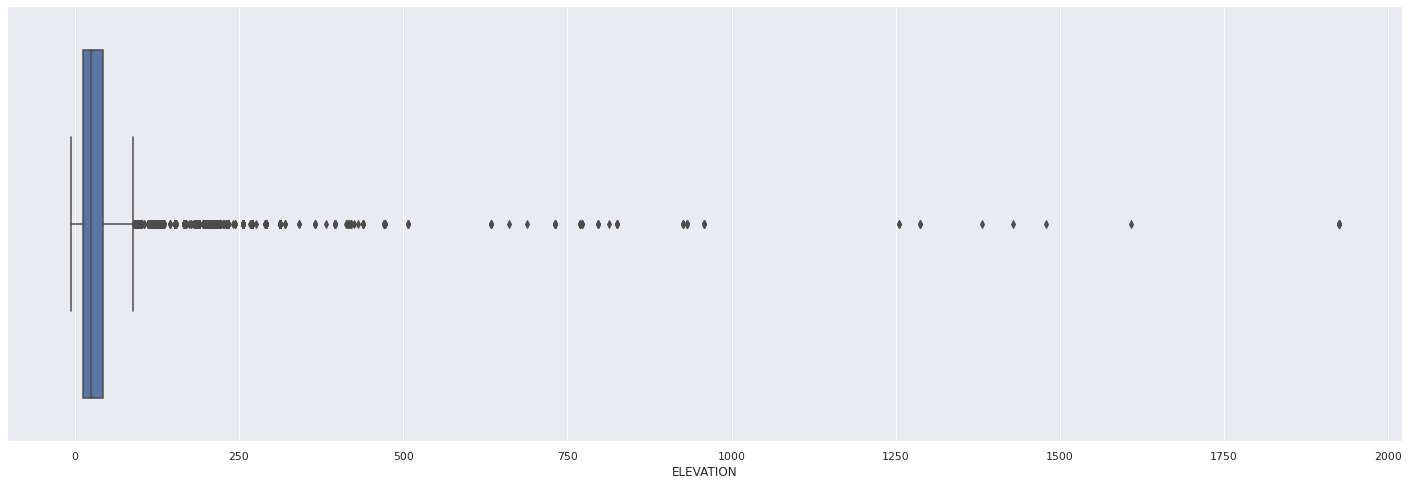

In [ ]:
sns.boxplot(train_df['ELEVATION'])

In [ ]:
train_df[train_df['ELEVATION']> 1000]

Year_Factor State_Factor  ...    id facility_type_reduced
383             2      State_1  ...   383      Education_others
1144            3      State_1  ...  1144      Education_others
2269            3      State_1  ...  2269      Education_others
2428            4      State_1  ...  2428      Education_others
2429            4      State_1  ...  2429      Education_others
2430            4      State_1  ...  2430      Education_others
2431            4      State_1  ...  2431      Education_others
2432            4      State_1  ...  2432      Education_others
3508            4      State_1  ...  3508      Education_others
3509            4      State_1  ...  3509      Education_others
3510            4      State_1  ...  3510      Education_others
3511            4      State_1  ...  3511      Education_others
3512            4      State_1  ...  3512      Education_others
3513            4      State_1  ...  3513      Education_others
3514            4      State_1  ...  3514      Education_others
3539            4      State_1  ...  3539      Education_others

[16 rows x 65 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


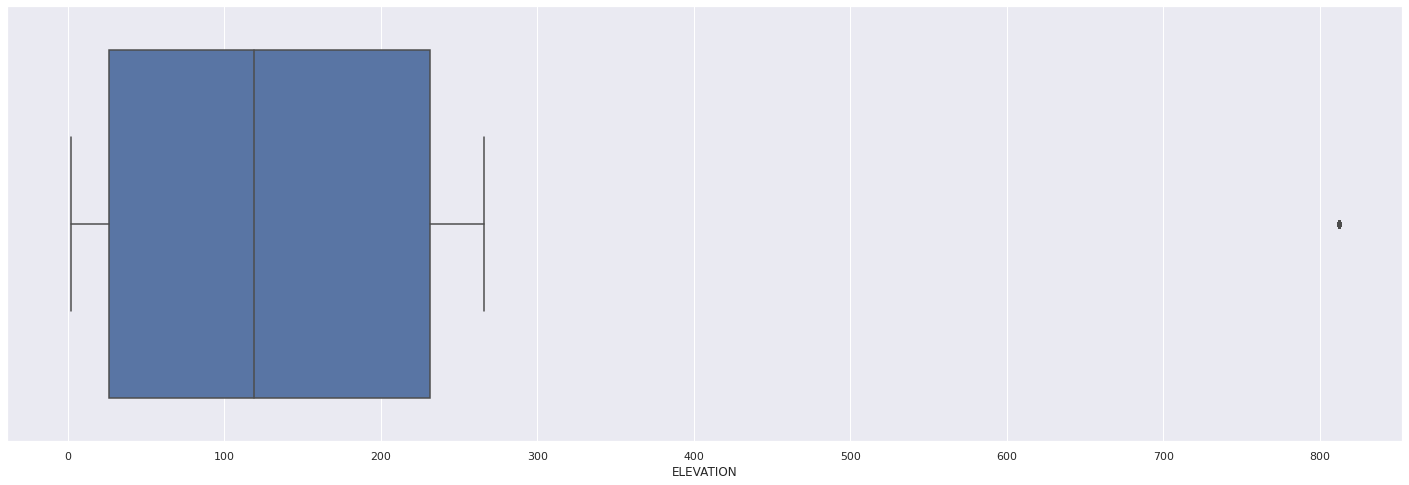

In [ ]:
sns.boxplot(test_df['ELEVATION'])

No handles with labels found to put in legend.


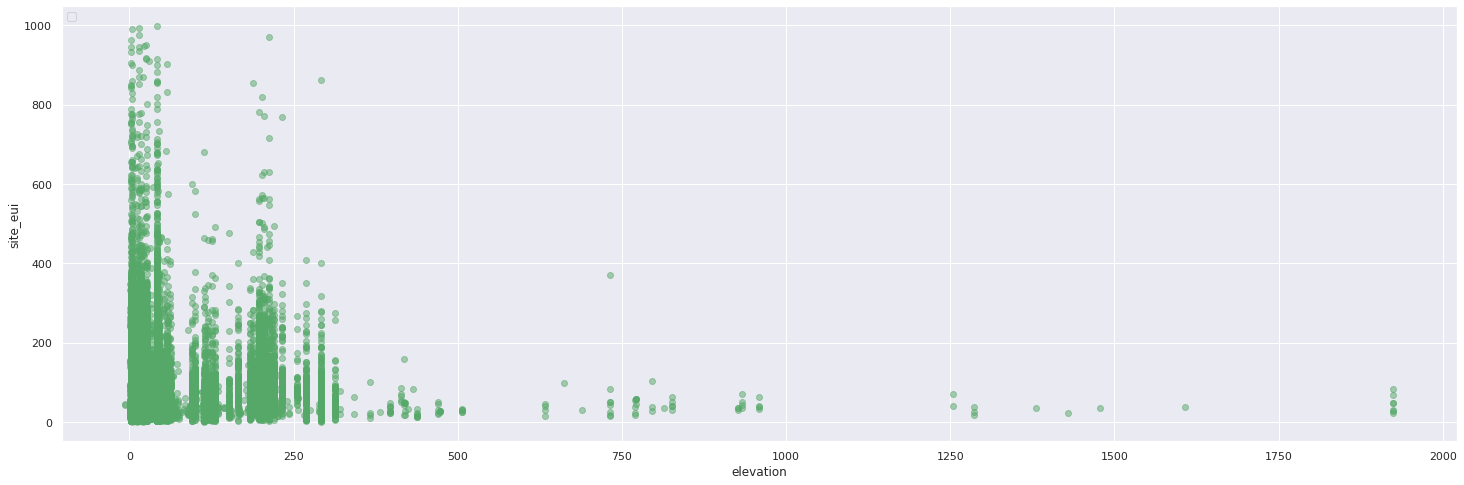

In [ ]:
# scatter plot to see correlation between elevation and site_eui
plt.scatter(train_df['ELEVATION'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel("elevation")
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

**2.9 Temperature**

In [ ]:
def box_plot_temperatures_by_state(df, p_month, p_stat):
    sns.set(rc={'figure.figsize':(25,8)})
    ax = sns.boxplot(data=df, x='State_Factor', y=f'{p_month}_{p_stat}_temp')
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
months_list = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
v = interactive(lambda month, stat: box_plot_temperatures_by_state(train_df, month, stat), month=months_list, stat=['min', 'avg', 'max'])
display(v)

interactive(children=(Dropdown(description='month', options=('january', 'february', 'march', 'april', 'may', '…

In [ ]:
def scatter_plot_site_eui_by_temperatures(df, p_month, p_stat):
    plt.scatter(train_df[f'{p_month}_{p_stat}_temp'], train_df['site_eui'], c="g", alpha=0.5)
    plt.xlabel(f'{p_month}_{p_stat}_temp')
    plt.ylabel("site_eui")
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
months_list = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
v = interactive(lambda month, stat: scatter_plot_site_eui_by_temperatures(train_df, month, stat), month=months_list, stat=['min', 'avg', 'max'])
display(v)

interactive(children=(Dropdown(description='month', options=('january', 'february', 'march', 'april', 'may', '…

**2.10 Cooling/Heating degree days**

In [ ]:
train_df[['cooling_degree_days', 'heating_degree_days']].describe()

cooling_degree_days  heating_degree_days
count         75757.000000         75757.000000
mean           1202.250446          4324.957390
std             391.561780           824.366727
min               0.000000           398.000000
25%            1128.000000          3978.000000
50%            1277.000000          4337.000000
75%            1489.000000          4670.000000
max            4948.000000          7929.000000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


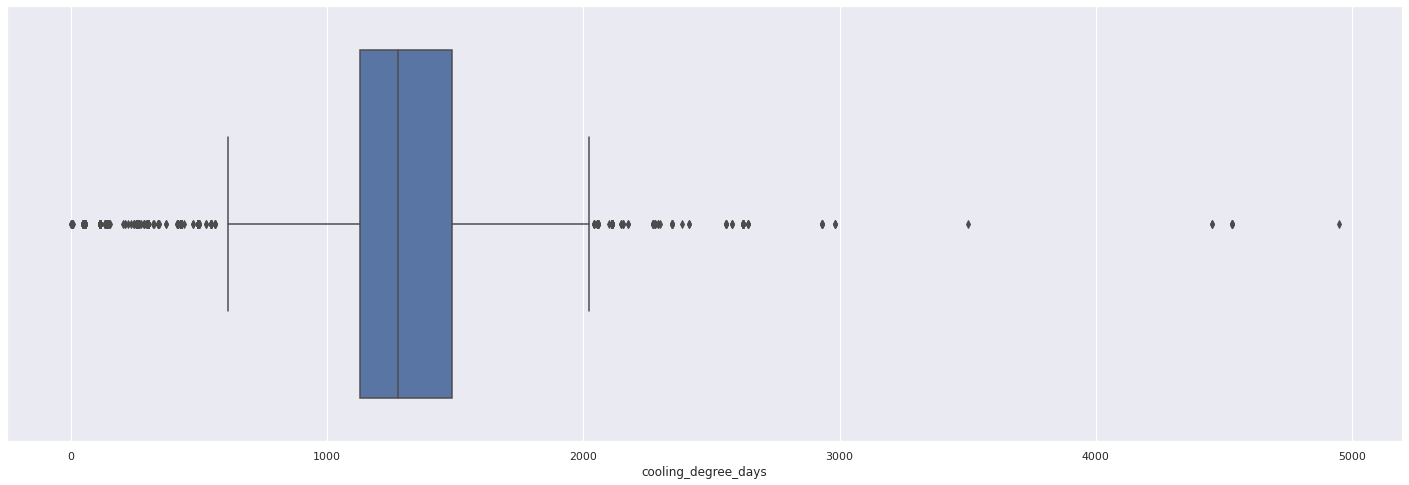

In [ ]:
sns.boxplot(train_df['cooling_degree_days'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


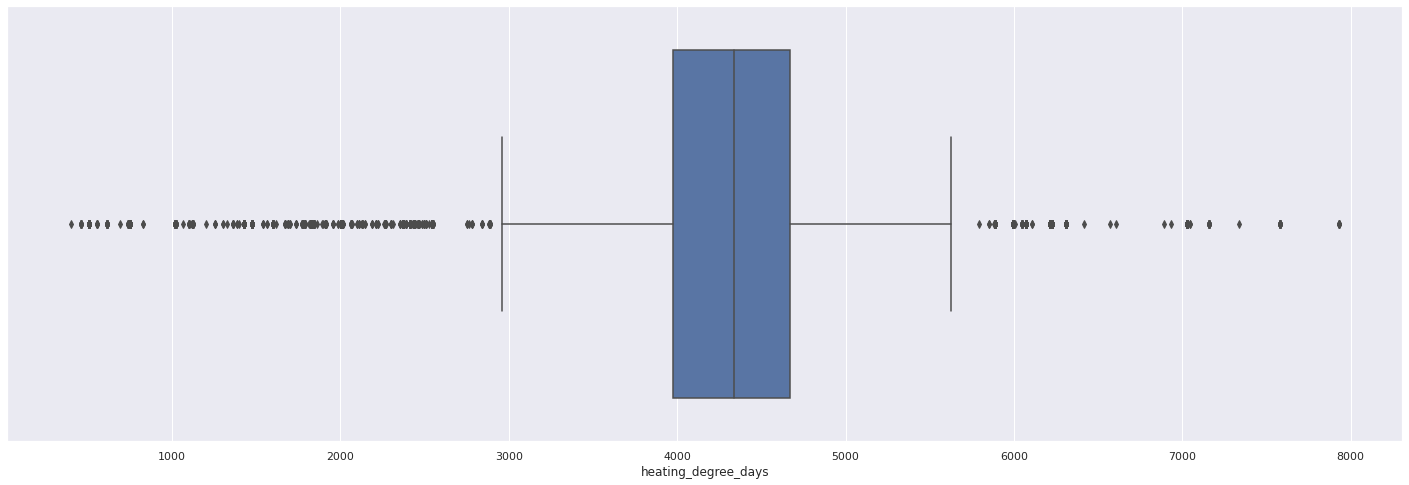

In [ ]:
sns.boxplot(train_df['heating_degree_days'])

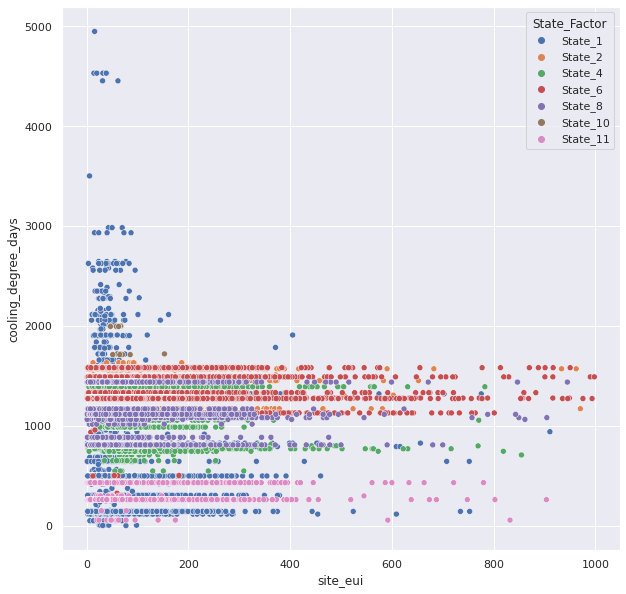

In [ ]:
plt.figure(figsize= (10, 10))
sns.scatterplot(x= 'site_eui', y= 'cooling_degree_days', hue= 'State_Factor', data= train_df)

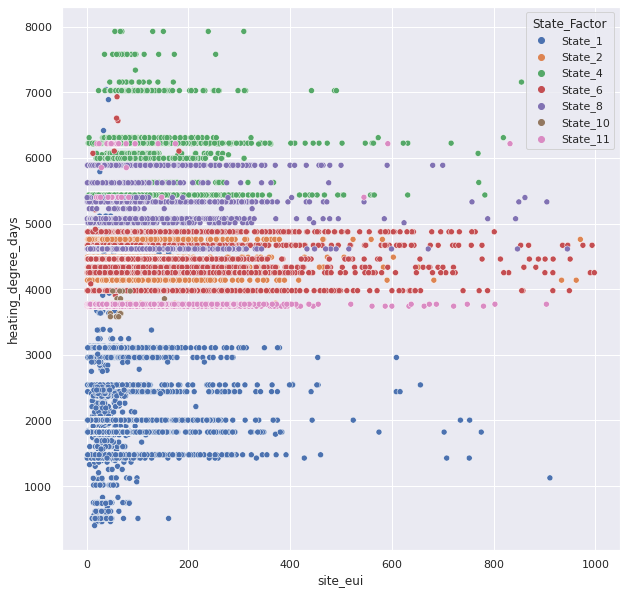

In [ ]:
plt.figure(figsize= (10, 10))
sns.scatterplot(x= 'site_eui', y= 'heating_degree_days', hue= 'State_Factor', data= train_df)

No handles with labels found to put in legend.


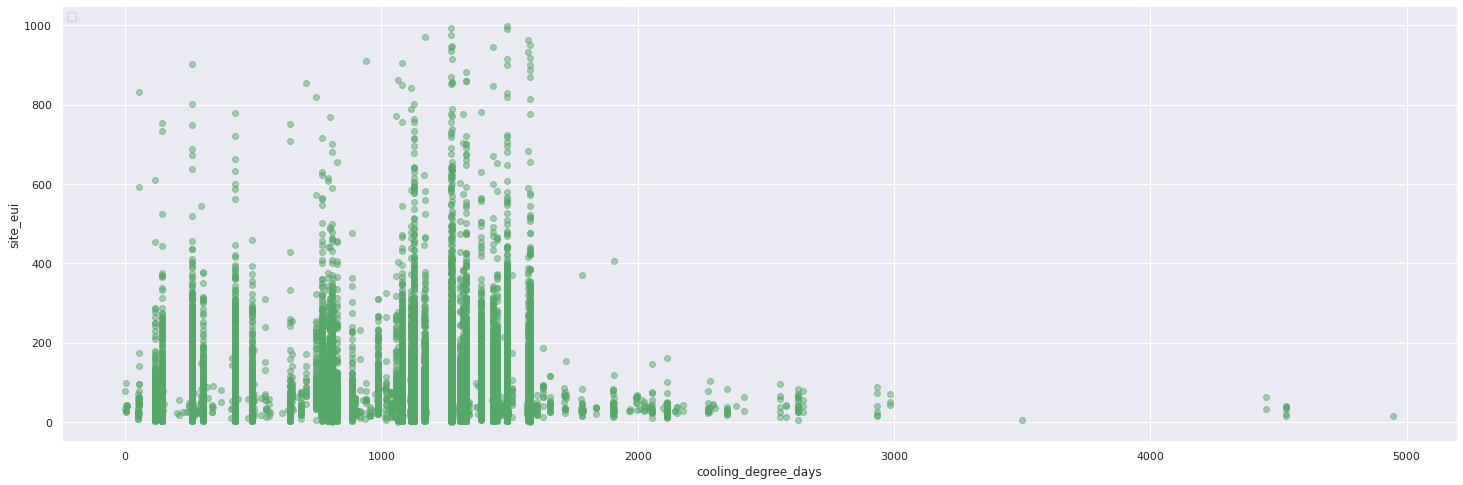

In [ ]:
plt.scatter(train_df[f'cooling_degree_days'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel(f'cooling_degree_days')
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


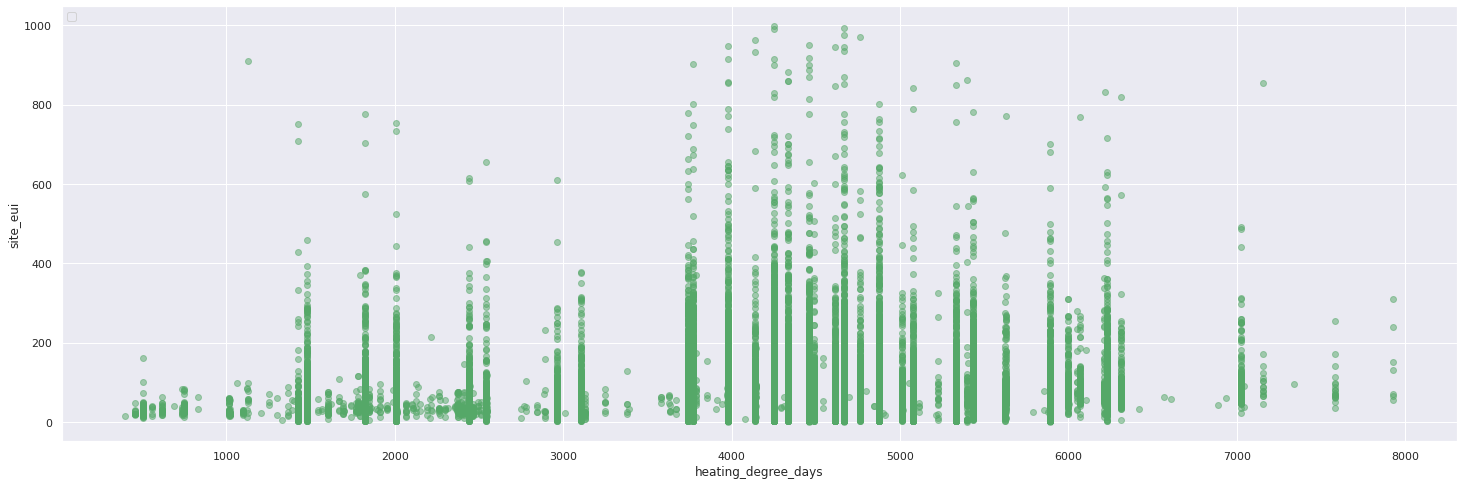

In [ ]:
plt.scatter(train_df[f'heating_degree_days'], train_df['site_eui'], c="g", alpha=0.5)
plt.xlabel(f'heating_degree_days')
plt.ylabel("site_eui")
plt.legend(loc='upper left')
plt.show()

**2.11 Precipitation/Snowfall/Snowdepth inches**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [ ]:
train_df['precipitation_inches'].describe()

count    75757.000000
mean        42.430651
std         10.592205
min          0.000000
25%         39.350000
50%         42.170000
75%         46.320000
max        107.690000
Name: precipitation_inches, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


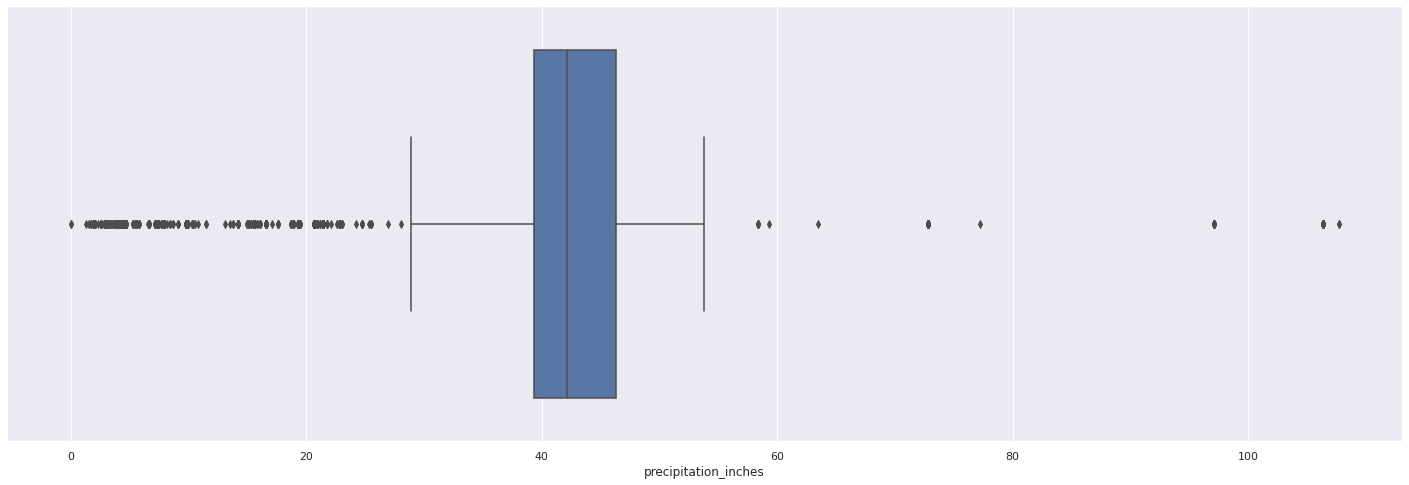

In [ ]:
sns.boxplot(train_df['precipitation_inches'])

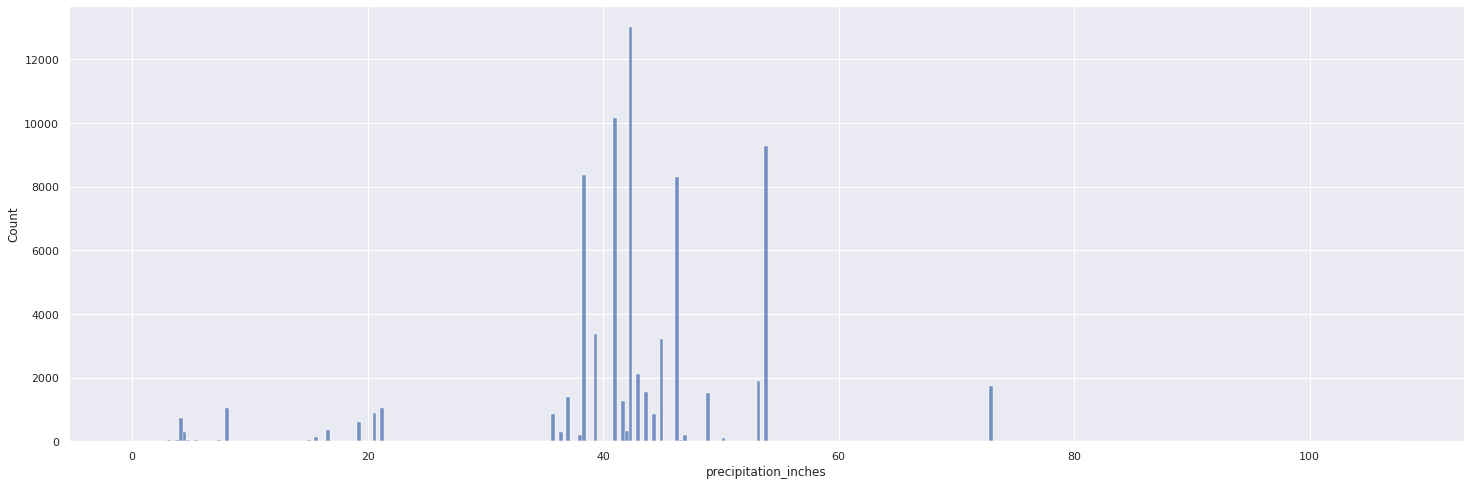

In [ ]:
sns.histplot(train_df['precipitation_inches'])

In [ ]:
for i in train_df.columns:
    print(f"{i}-> {train_df[i].nunique()}")

Year_Factor-> 6
State_Factor-> 7
building_class-> 2
facility_type-> 60
floor_area-> 20433
year_built-> 180
energy_star_rating-> 101
ELEVATION-> 193
january_min_temp-> 59
january_avg_temp-> 165
january_max_temp-> 49
february_min_temp-> 53
february_avg_temp-> 168
february_max_temp-> 43
march_min_temp-> 54
march_avg_temp-> 166
march_max_temp-> 42
april_min_temp-> 36
april_avg_temp-> 164
april_max_temp-> 33
may_min_temp-> 35
may_avg_temp-> 165
may_max_temp-> 39
june_min_temp-> 36
june_avg_temp-> 162
june_max_temp-> 43
july_min_temp-> 31
july_avg_temp-> 161
july_max_temp-> 41
august_min_temp-> 31
august_avg_temp-> 167
august_max_temp-> 42
september_min_temp-> 36
september_avg_temp-> 165
september_max_temp-> 39
october_min_temp-> 39
october_avg_temp-> 168
october_max_temp-> 37
november_min_temp-> 44
november_avg_temp-> 160
november_max_temp-> 38
december_min_temp-> 43
december_avg_temp-> 163
december_max_temp-> 39
cooling_degree_days-> 162
heating_degree_days-> 170
precipitation_inches-> 171

In [ ]:
count_features= ['days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

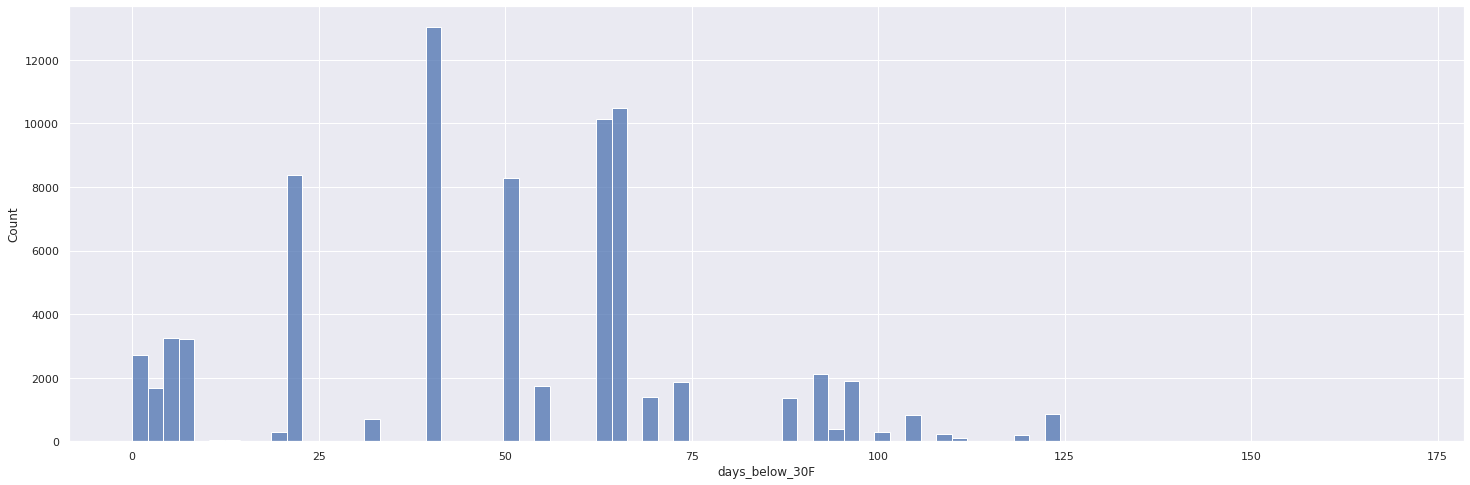

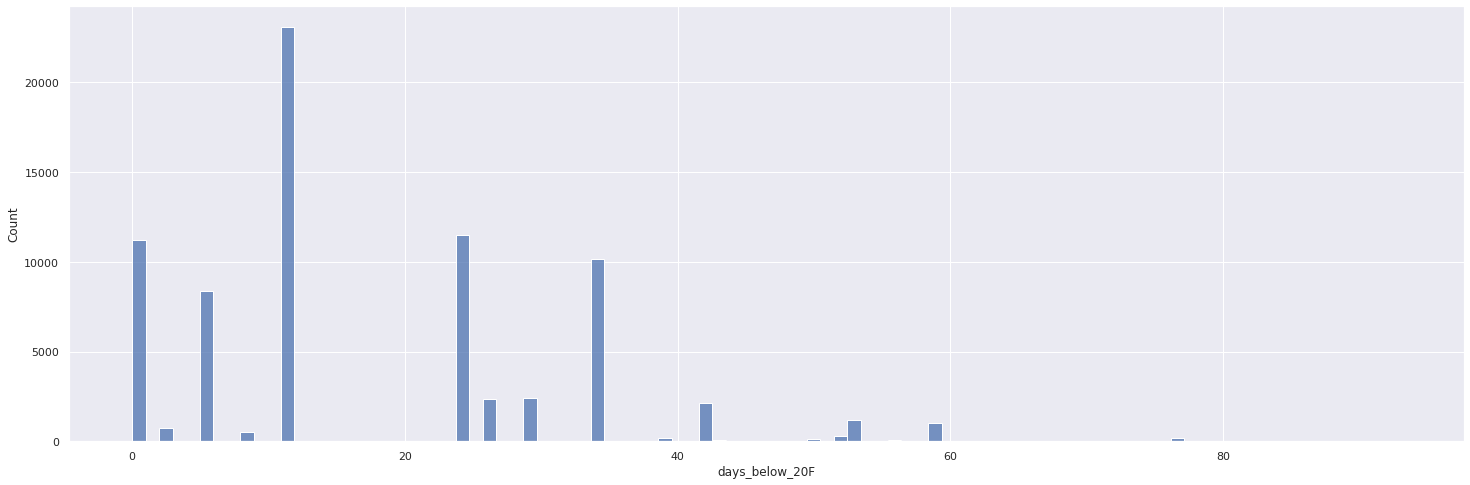

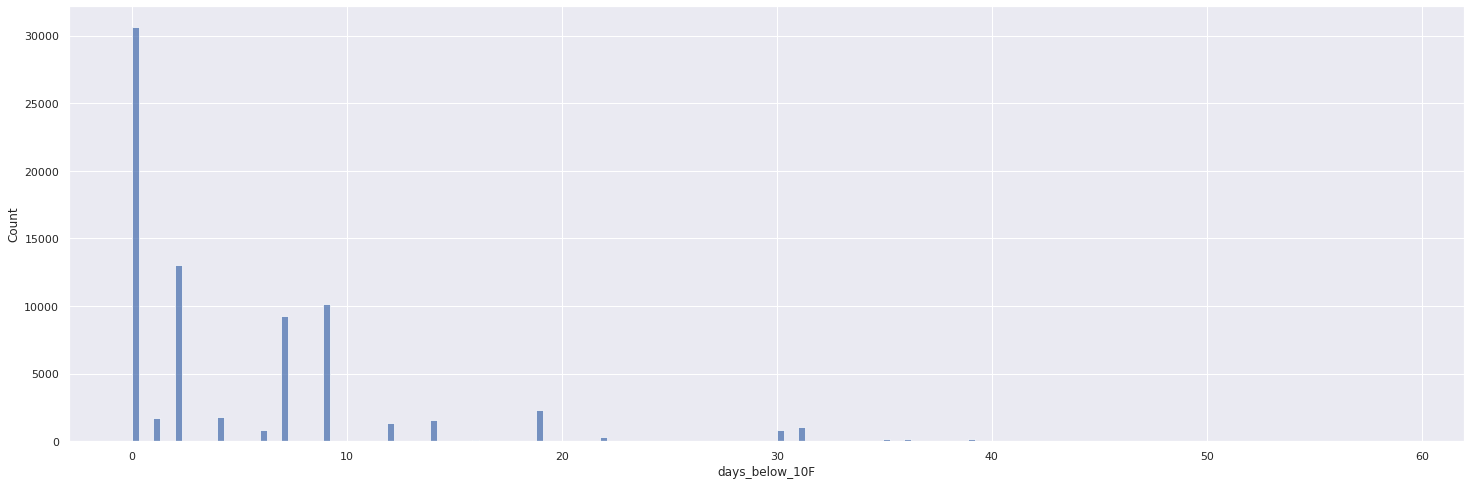

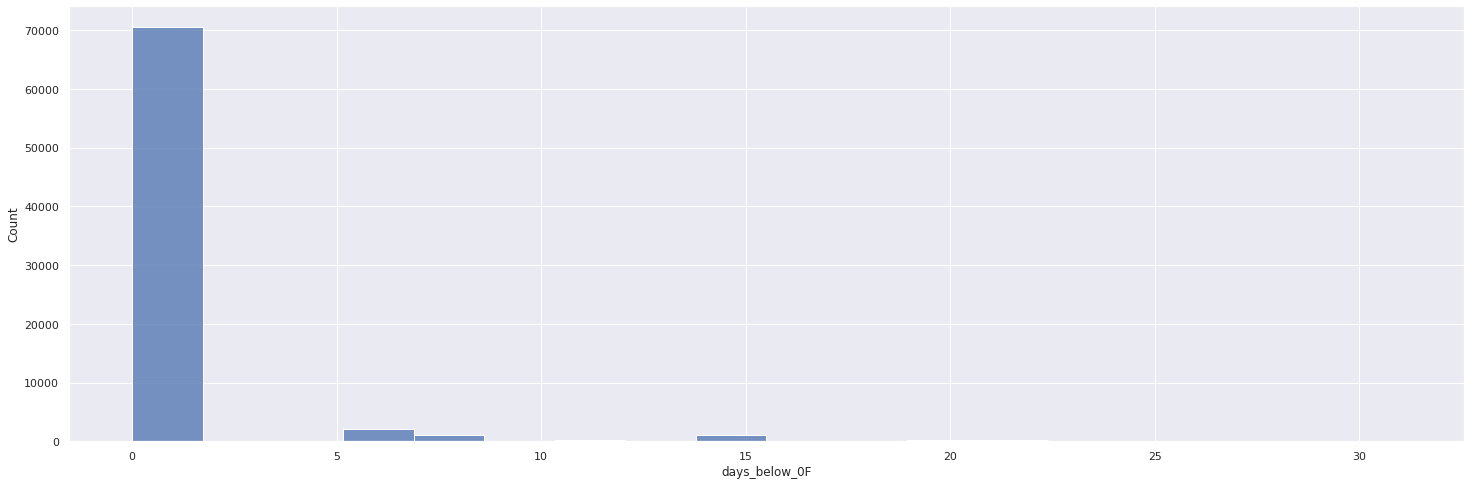

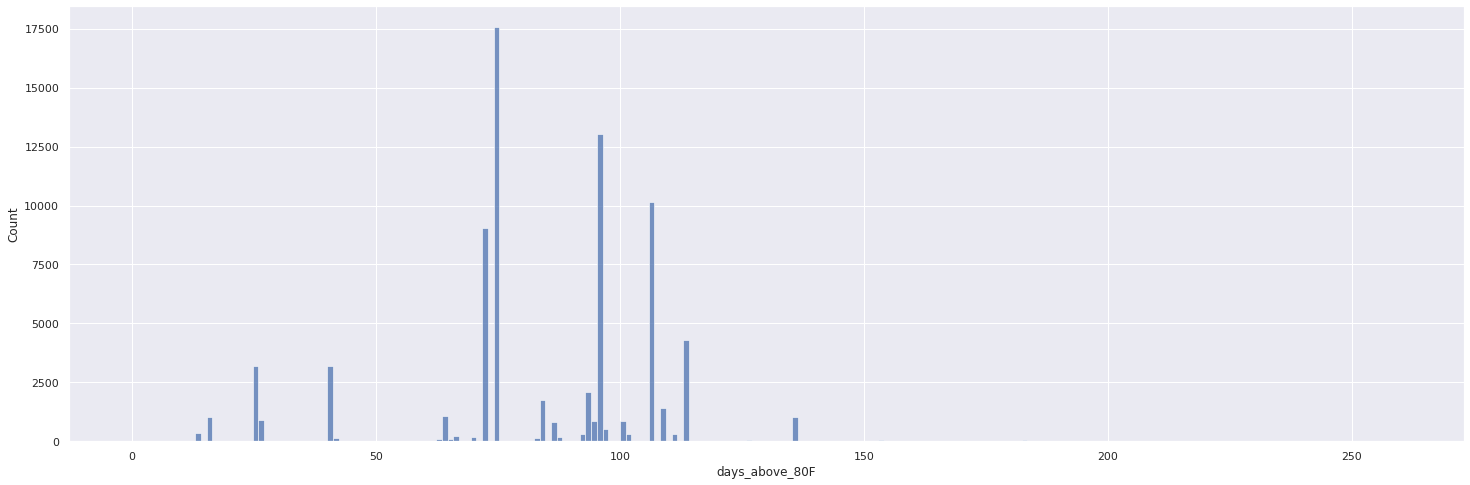

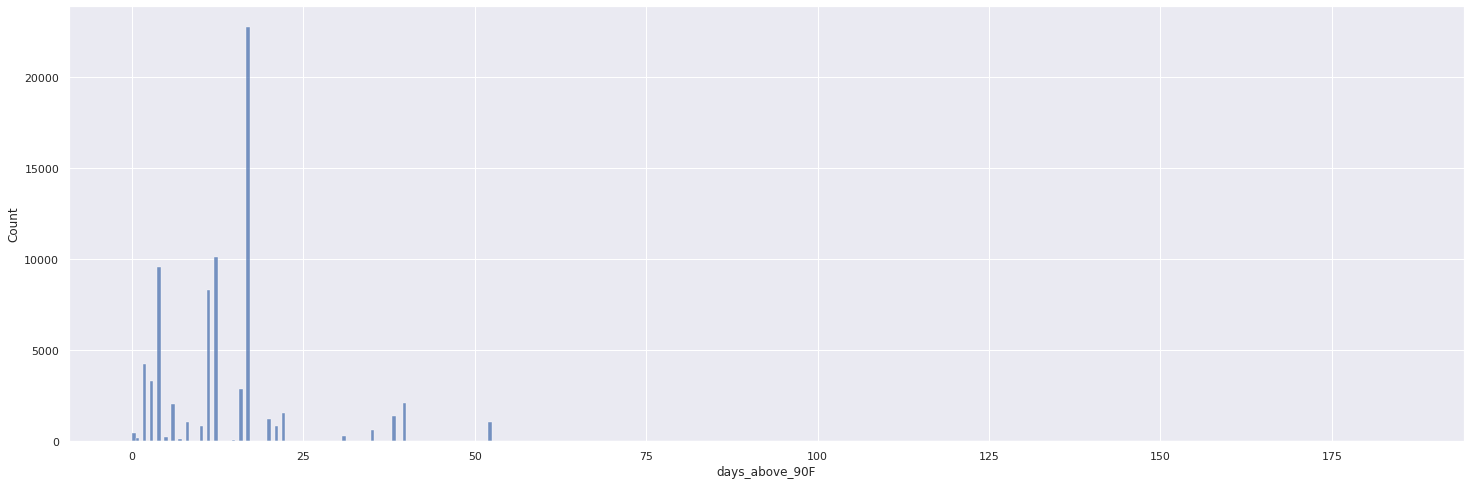

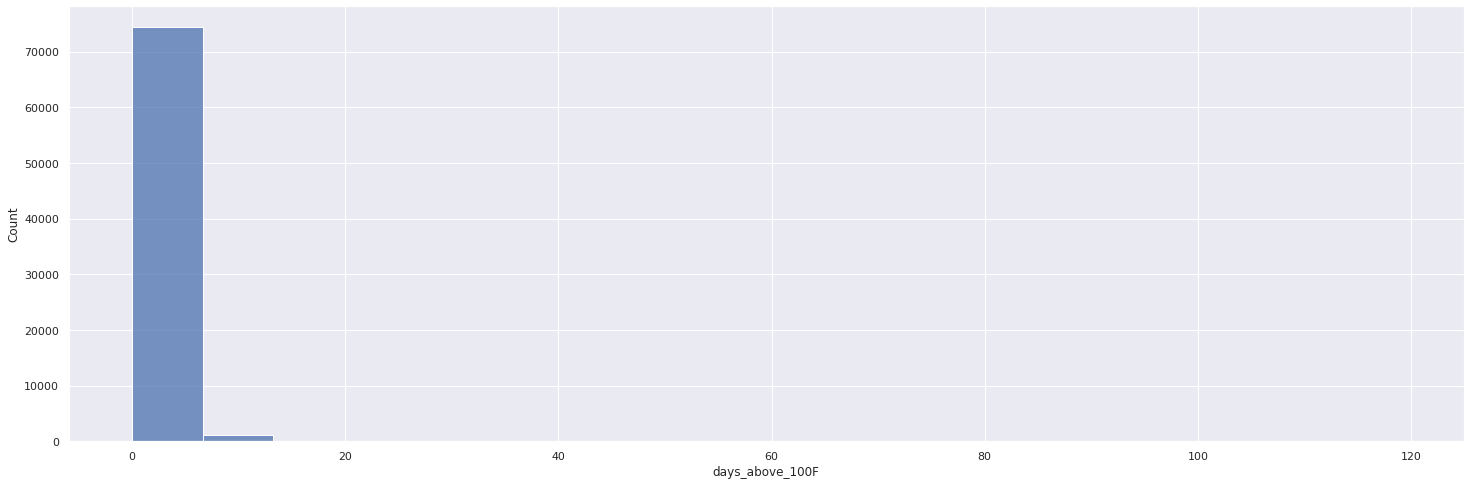

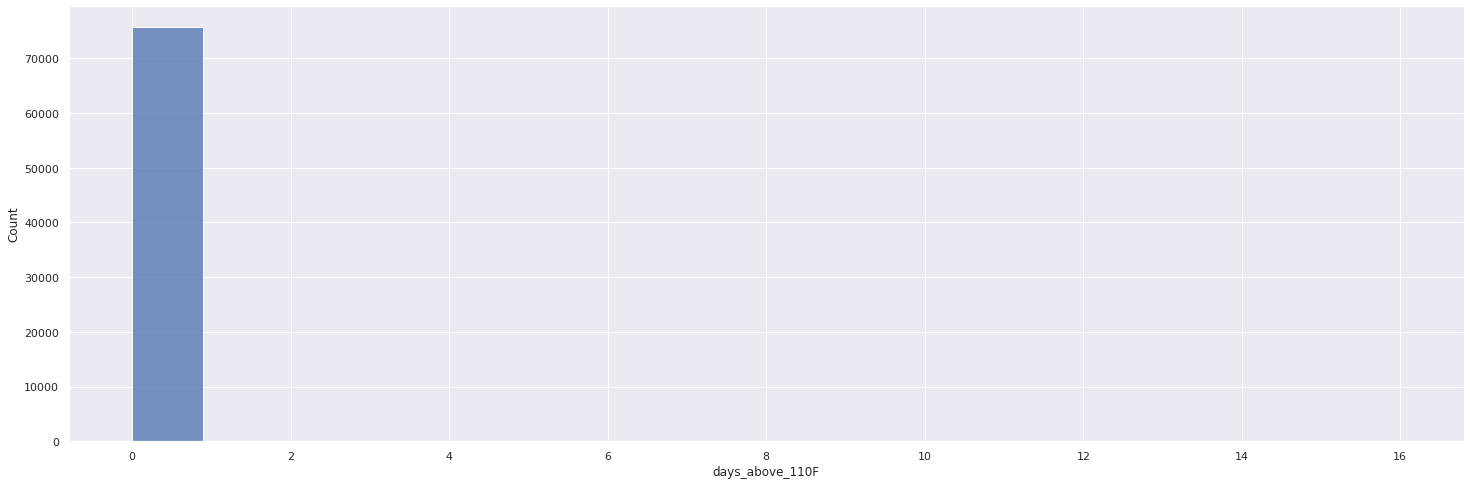

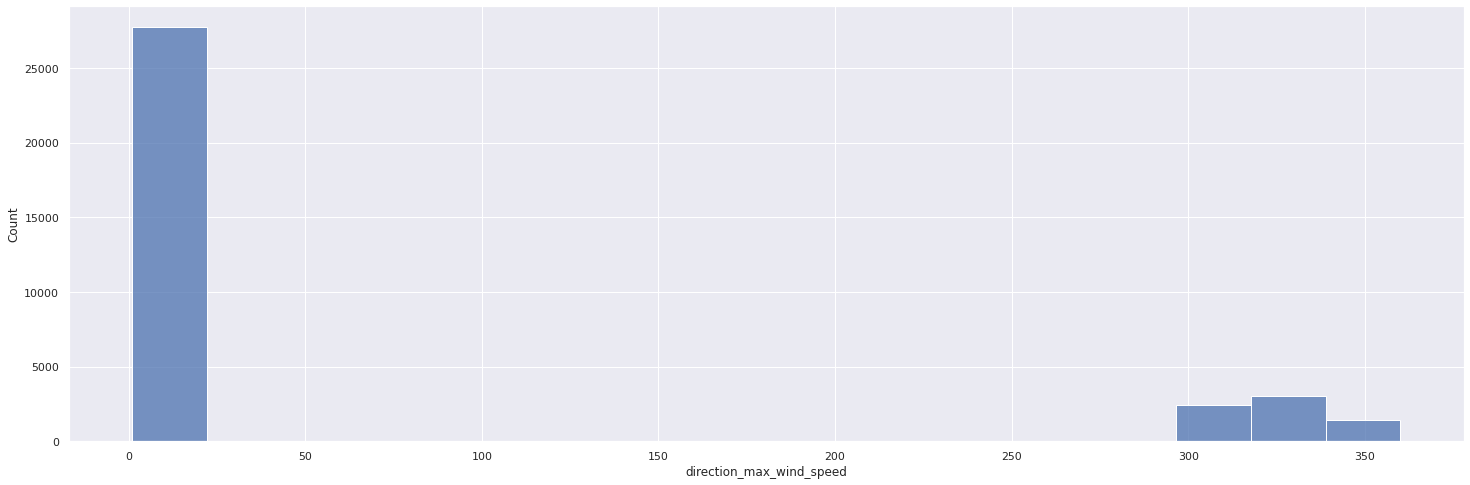

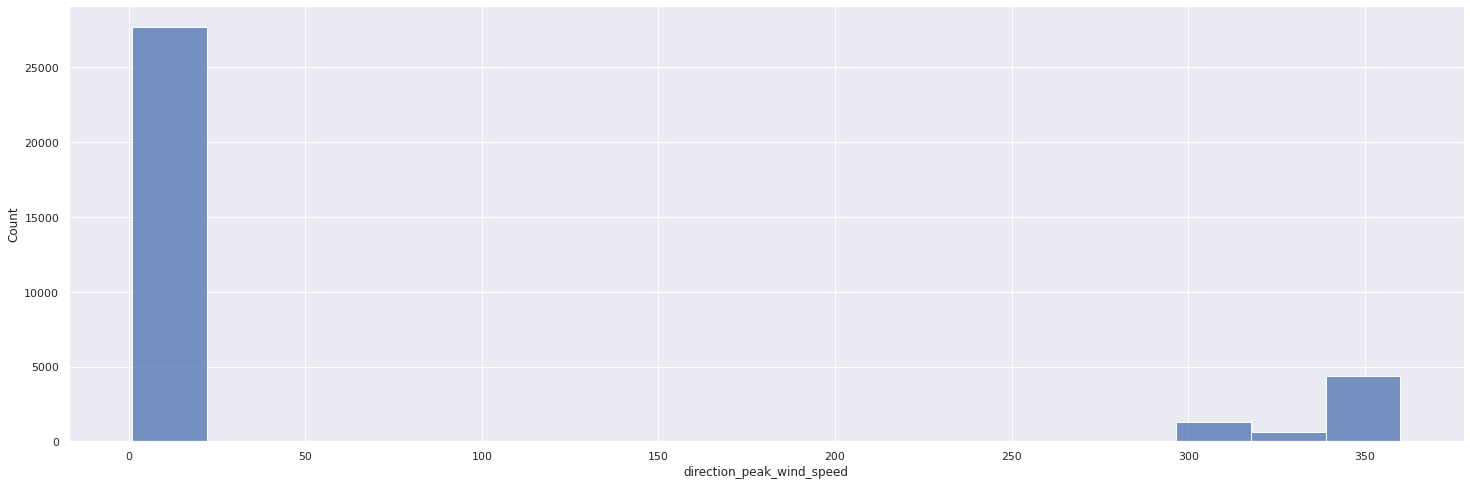

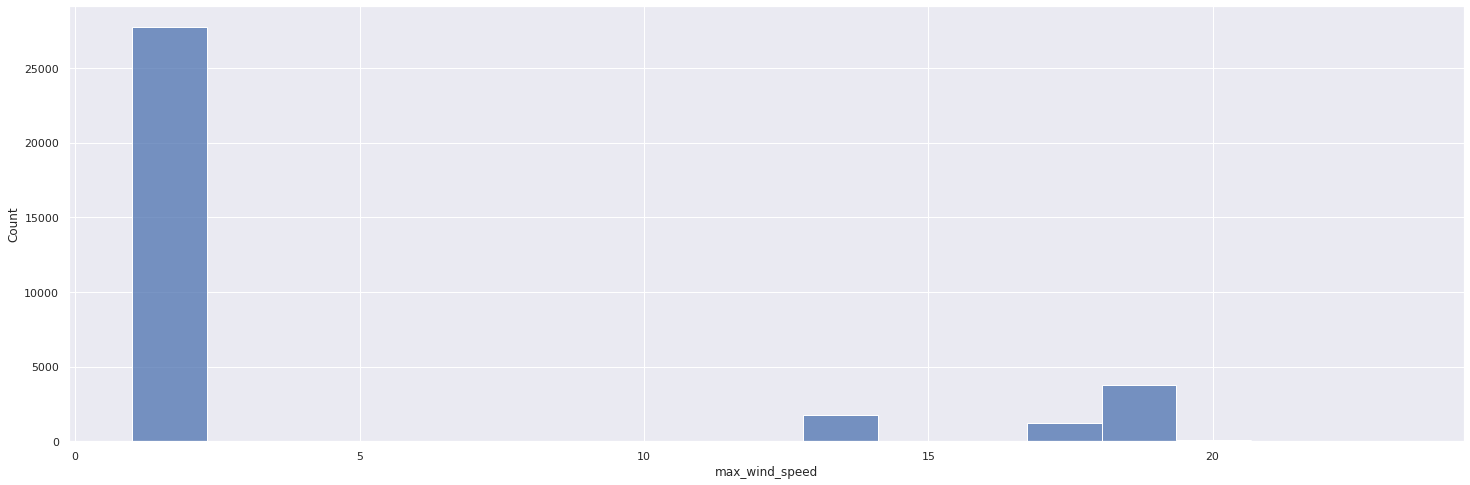

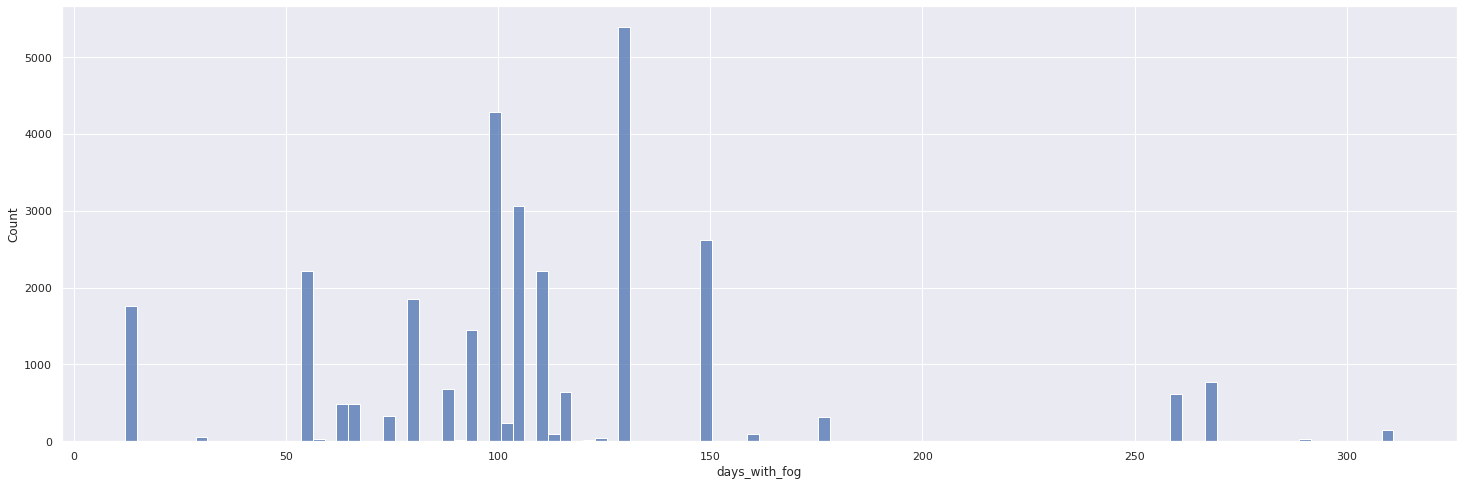

In [ ]:
for i in count_features:
#     plt.figure(figsize= (20, 5))
    sns.histplot(train_df[i])
    plt.show()

In [ ]:
corr= pd.DataFrame(train_df[train_df['site_eui']<200].corr())

In [ ]:
corr_target= pd.DataFrame(corr['site_eui'].sort_values(ascending= False))
corr_target.tail()

site_eui
february_min_temp  -0.253516
february_avg_temp  -0.256297
january_avg_temp   -0.268777
january_min_temp   -0.285412
energy_star_rating -0.632337

#####**How does Site EUI vary with year_built?**

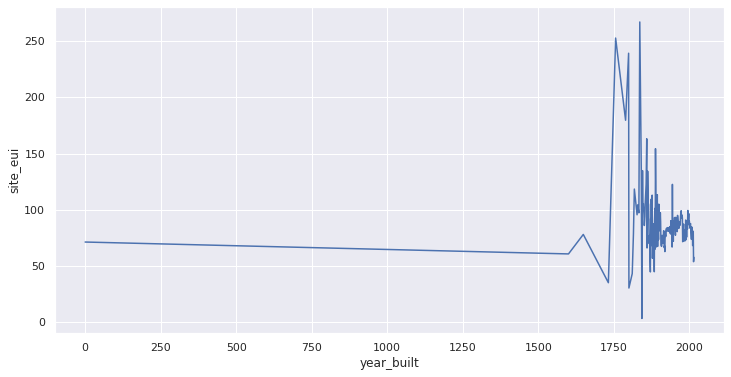

In [ ]:
df = pd.DataFrame(train_df.groupby('year_built')['site_eui'].agg('mean'), columns=['site_eui']).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year_built', y='site_eui')
plt.show()

##### **How does Site EUI vary with Year factor?**

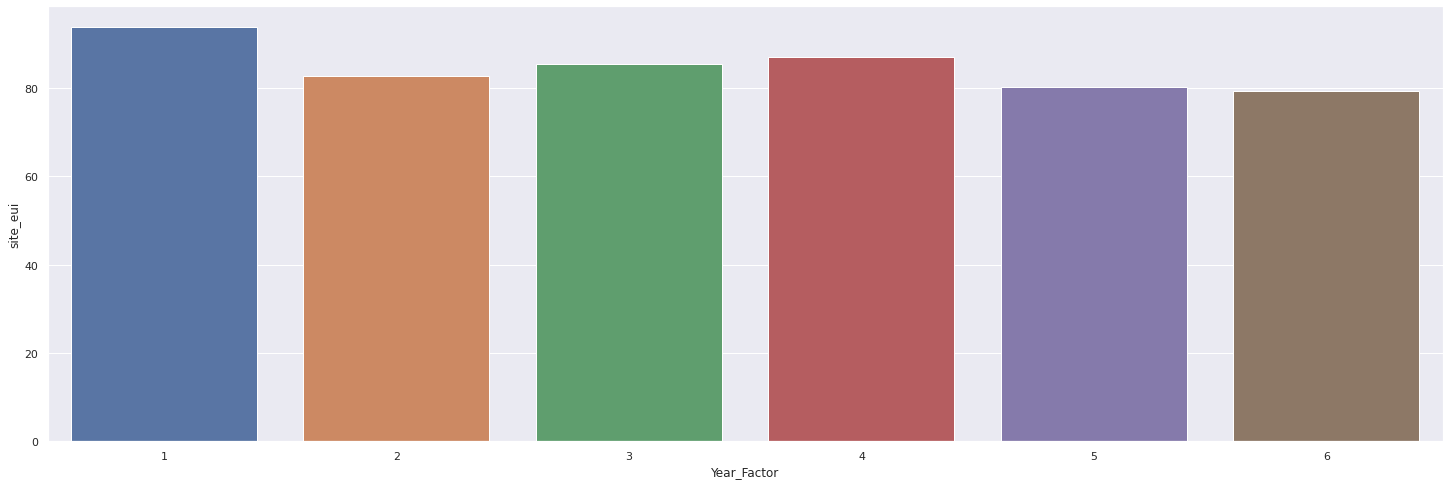

In [ ]:
# plt.figure(figsize=(12, 6))
df = pd.DataFrame(train_df.groupby('Year_Factor')['site_eui'].agg('mean')).reset_index()
sns.barplot(data=df, x='Year_Factor', y='site_eui')
plt.show()

##### **How does Site EUI vary with building class?**

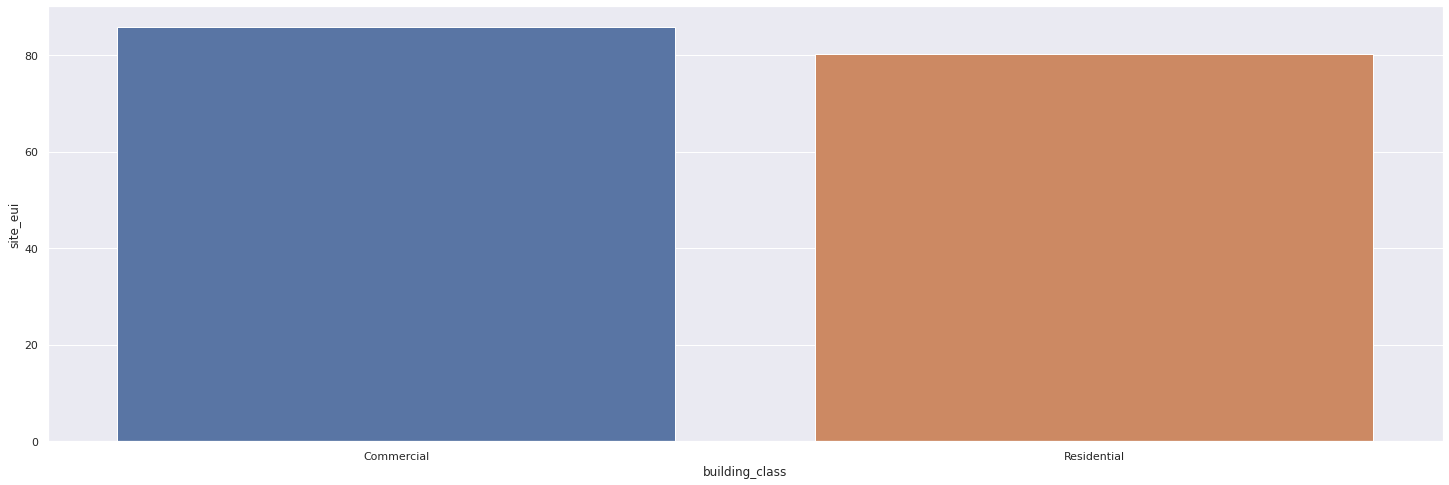

In [ ]:
df = pd.DataFrame(train_df.groupby('building_class')['site_eui'].agg('mean'), columns=['site_eui']).reset_index()

sns.barplot(data=df, x='building_class', y='site_eui')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


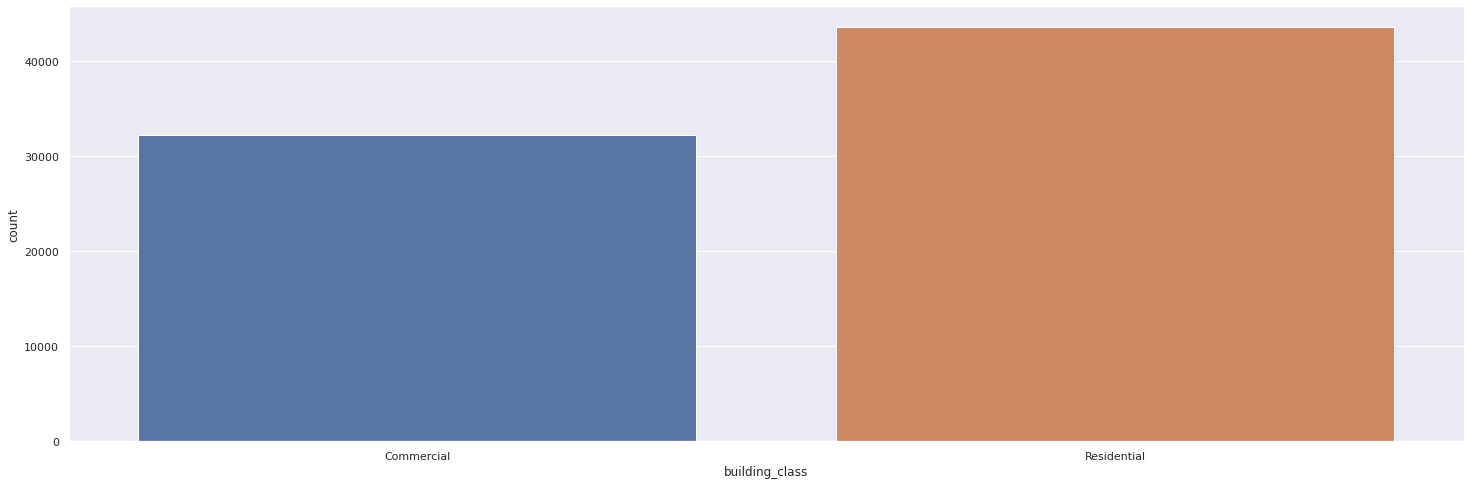

In [ ]:
sns.countplot(train_df['building_class'])

##### **How does Site EUI vary with state?**

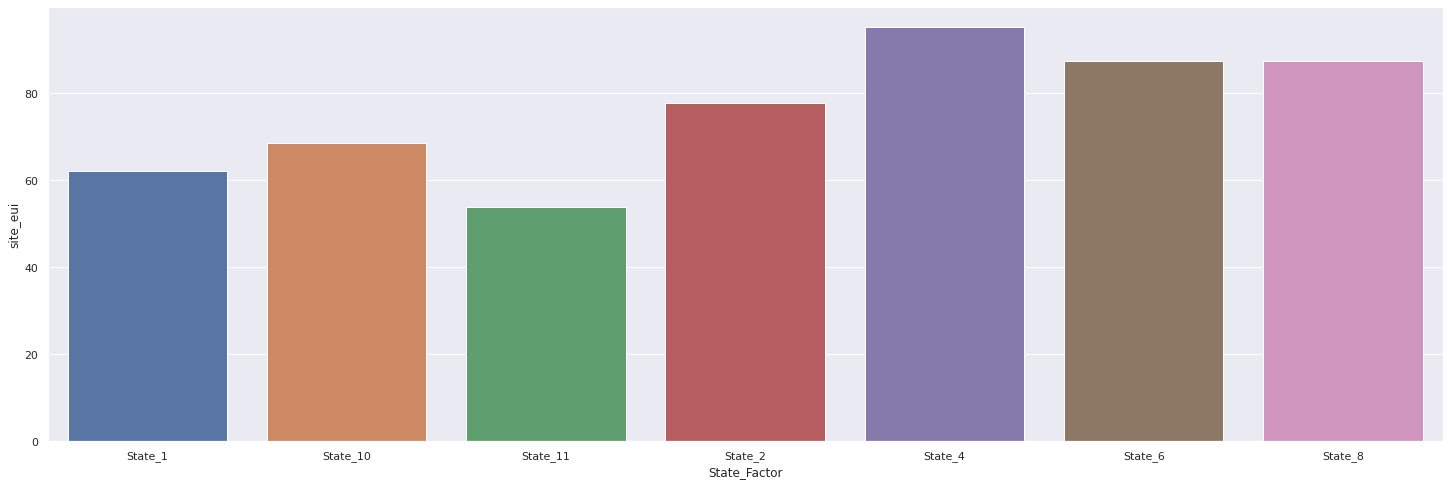

In [ ]:
# plt.figure(figsize=(12, 6))
df = pd.DataFrame(train_df.groupby('State_Factor')['site_eui'].agg('mean')).reset_index()
sns.barplot(data=df, x='State_Factor', y='site_eui')
plt.show()

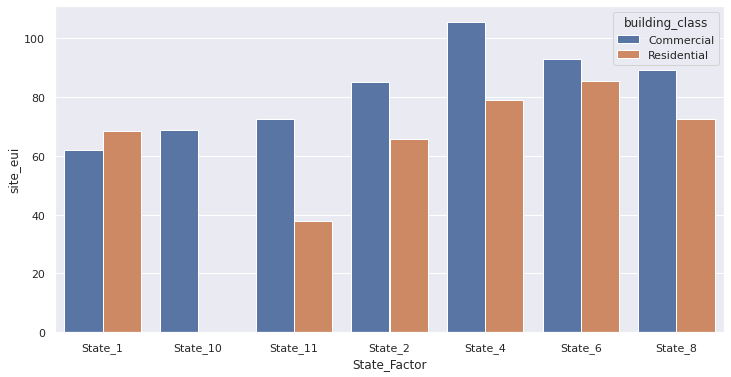

In [ ]:
plt.figure(figsize=(12, 6))
df = pd.DataFrame(train_df.groupby(['State_Factor', 'building_class'])['site_eui'].agg('mean')).reset_index()
sns.barplot(data=df, x='State_Factor', y='site_eui', hue='building_class')
plt.show()
# df.head()

##### **How does Site EUI vary with average temperature?**

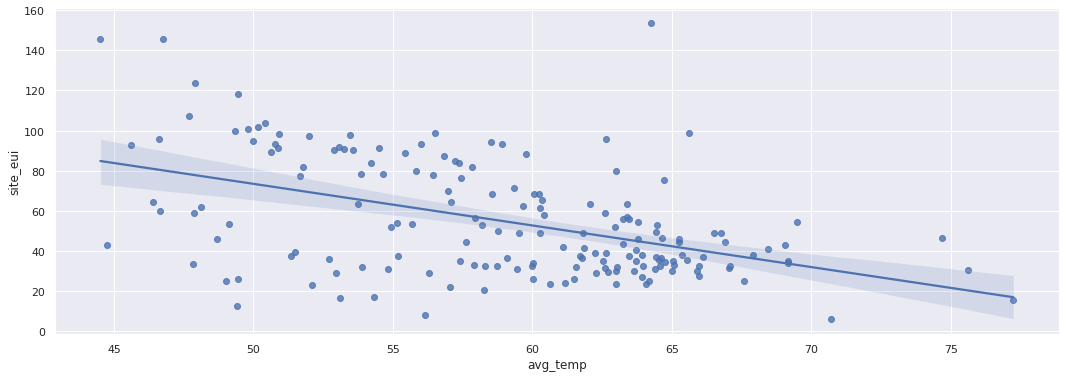

In [ ]:
plt.figure(figsize=(18, 6))
df = pd.DataFrame(train_df.groupby('avg_temp')['site_eui'].agg('mean')).reset_index()
sns.regplot(data=df, x='avg_temp', y='site_eui')
plt.show()

##### **How does Site EUI vary with precipitation?**

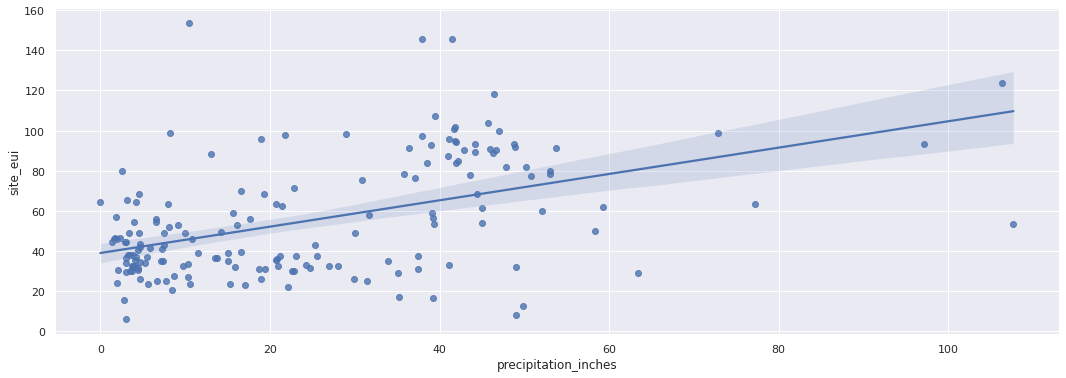

In [ ]:
plt.figure(figsize=(18, 6))
df = pd.DataFrame(train_df.groupby('precipitation_inches')['site_eui'].agg('mean')).reset_index()
sns.regplot(data=df, x='precipitation_inches', y='site_eui')
plt.show()

##### **How does Site EUI vary with snowfall?**

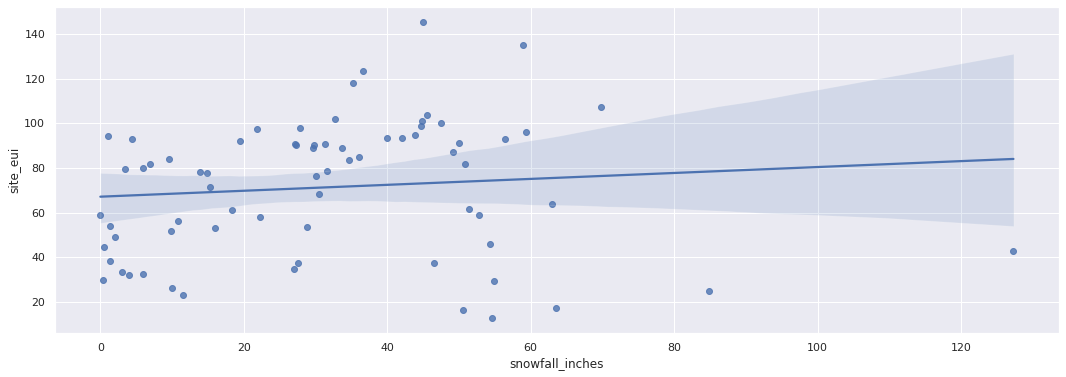

In [ ]:
plt.figure(figsize=(18, 6))
df = pd.DataFrame(train_df.groupby('snowfall_inches')['site_eui'].agg('mean')).reset_index()
sns.regplot(data=df, x='snowfall_inches', y='site_eui')
plt.show()

##### **How does Site EUI vary with elevation of the building?**

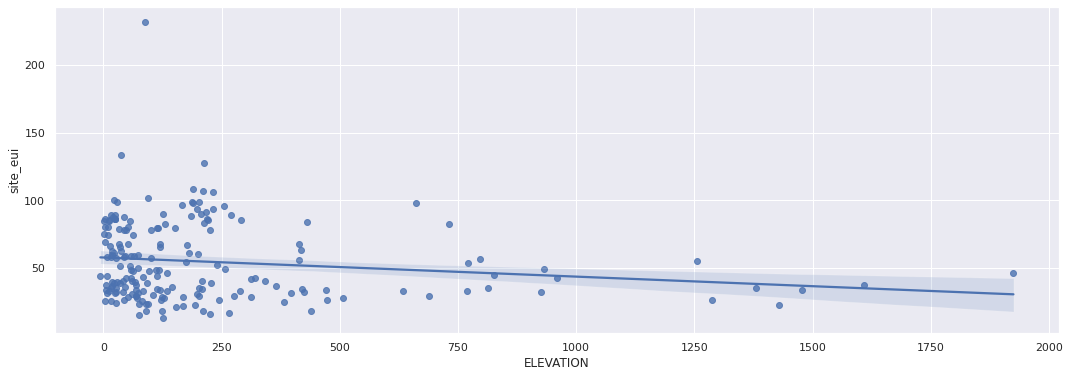

In [ ]:
plt.figure(figsize=(18, 6))
df = pd.DataFrame(train_df.groupby('ELEVATION')['site_eui'].agg('mean')).reset_index()
sns.regplot(data=df, x='ELEVATION', y='site_eui')
plt.show()

In [ ]:
num_cols = ['floor_area', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

nominal_cols = ['Year_Factor', 'State_Factor', 'building_class', 'facility_type']
ordinal_cols = ['year_built', 'energy_star_rating']

In [ ]:
feat = num_cols + ['site_eui']
corr = train_df[feat].corr()
corr.style.background_gradient(cmap='coolwarm')

##### **Missing Values**

Text(0.5, 1.0, 'Missing values in training Data')

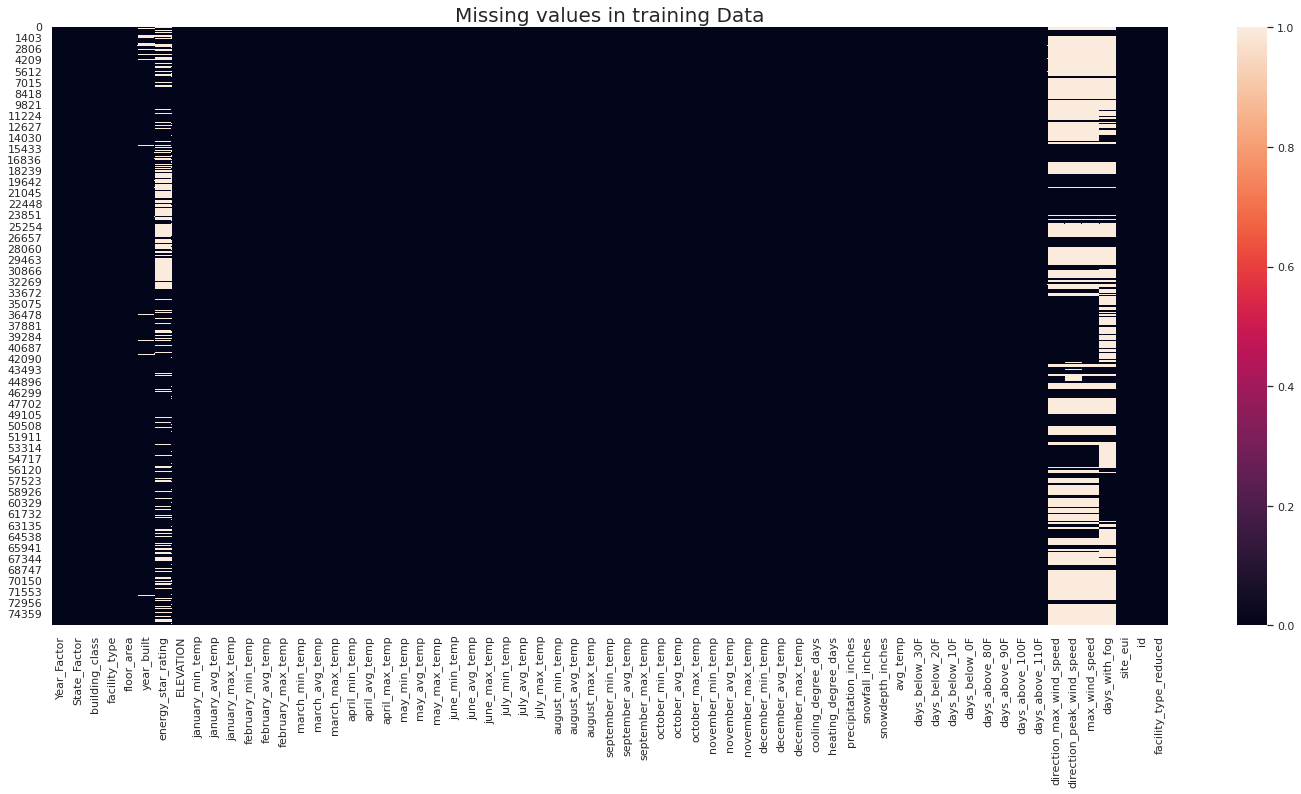

In [ ]:
plt.figure(figsize = (25,11))
sns.heatmap(train_df.isna().values, xticklabels=train_df.columns)
plt.title("Missing values in training Data", size=20)

**Missing value Imputation**

In [ ]:
from sklearn.impute import SimpleImputer
missing_columns = [col for col in train_df.columns if train_df[col].isnull().any()]
missingvalues_count =train_df.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

train_df['year_built'] =train_df['year_built'].replace(np.nan, 2022)
test_df['year_built'] =test_df['year_built'].replace(np.nan, 2022)
null_col=['energy_star_rating','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']
imputer = SimpleImputer()
imputer.fit(train_df[null_col])
data_transformed = imputer.transform(train_df[null_col])
train_df[null_col] = pd.DataFrame(data_transformed)
test_data_transformed = imputer.transform(test_df[null_col])
test_df[null_col] = pd.DataFrame(test_data_transformed)

Text(0.5, 1.0, 'Missing values in training Data')

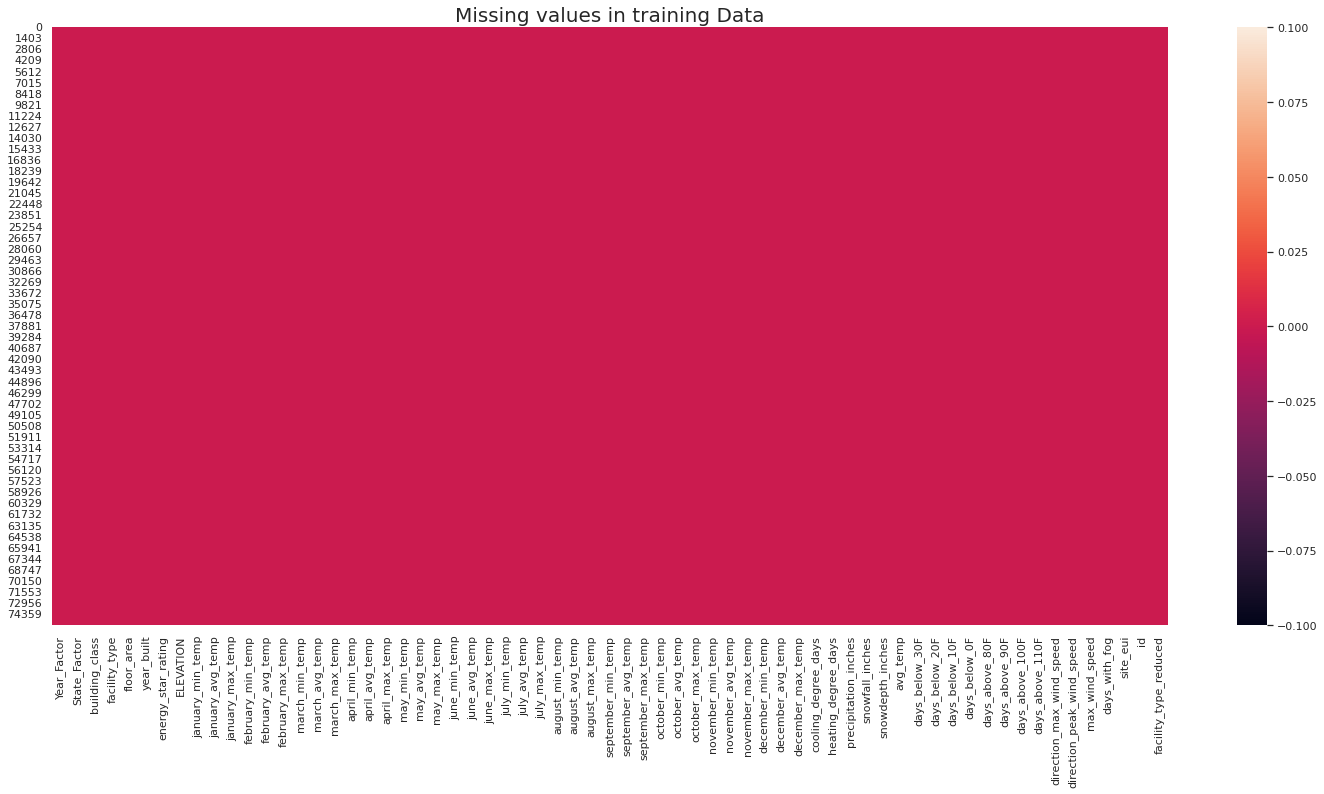

In [ ]:
plt.figure(figsize = (25,11))
sns.heatmap(train_df.isna().values, xticklabels=train_df.columns)
plt.title("Missing values in training Data", size=20)

**Label Encoding**

In [ ]:
categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features=train_df.select_dtypes('number').columns

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in categorical_features:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])

In [ ]:
train_df.head()

Year_Factor  State_Factor  ...  id         facility_type_reduced
0            1             0  ...   0  Grocery_store_or_food_market
1            1             0  ...   1              Warehouse_others
2            1             0  ...   2          Retail_Enclosed_mall
3            1             0  ...   3              Education_others
4            1             0  ...   4              Warehouse_others

[5 rows x 65 columns]

In [ ]:
train_df.describe().style.background_gradient()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

In [ ]:
from xgboost import XGBRegressor
import lightgbm as lgbm
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
from sklearn import model_selection

train_df["kfold"] = -1

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=train_df)):
    train_df.loc[valid_idx, 'kfold'] = fold

In [ ]:
feat = [col for col in train_df.columns if col not in ("id", "site_eui", "kfold")]
nominal_cols = ['Year_Factor', 'State_Factor', 'building_class', 'facility_type']
test_df = test_df[feat]

##### **Target Encoding**

In [ ]:
import sklearn.model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=train_df)):
    train_df.loc[valid_idx, 'kfold'] = fold# target encoding
for col in nominal_cols:
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        x_train = train_df[train_df.kfold!=fold].reset_index(drop=True)
        x_valid = train_df[train_df.kfold==fold].reset_index(drop=True)
        feat = x_train.groupby(col)["site_eui"].agg('mean')
        feat = feat.to_dict()
        x_valid.loc[:, f"tar_enc_{col}"] = x_valid[col].map(feat)
        temp_df.append(x_valid)
        if temp_test_feat is None:
            temp_test_feat = test_df[col].map(feat)
        else:
            temp_test_feat += test_df[col].map(feat)
            
    temp_test_feat /= 5
    test_df.loc[:, f"tar_enc_{col}"] = temp_test_feat
    train_df = pd.concat(temp_df)
    
feat = [col for col in train_df.columns if col not in ("id", "site_eui", "kfold")]

##### **L0-models**

##### **1. XGB Regressor**

In [ ]:
# parameters obtained by finetuning using optuna
xgb_params = {
    'learning_rate': 0.01246867934176147, 
    'reg_lambda': 1.5412806421547548e-05, 
    'reg_alpha': 1.2152973621220086e-07, 
    'subsample': 0.9813500259557678, 
    'colsample_bytree': 0.678482474847996, 
    'max_depth': 7
}

final_preds = []
valid_preds = {}
rmse_scores = []
for fold in range(5):
    print("Running...")
    x_train = train_df[train_df.kfold!=fold].reset_index(drop=True)
    x_valid = train_df[train_df.kfold==fold].reset_index(drop=True)
    y_train = x_train['site_eui']
    y_valid = x_valid['site_eui']
    
    valid_ids = x_valid.id.values.tolist()
    
    x_test = test_df[feat]
    
    x_train = x_train[feat]
    x_valid = x_valid[feat]
    
    # Label Encoding
    for col in nominal_cols:
        encoder = LabelEncoder()
        encoder.fit(x_train[col])
        x_train[col] = encoder.transform(x_train[col])
        
        for label in np.unique(x_valid[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_valid[col] = encoder.transform(x_valid[col])
        
        for label in np.unique(x_test[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_test[col] = encoder.transform(x_test[col])
    
    model = XGBRegressor(**xgb_params, random_state=42, n_estimators= 7000)
    model.fit(x_train, y_train)
    preds_valid = model.predict(x_valid)
    score = np.sqrt(mean_squared_error(y_valid, preds_valid))
    rmse_scores.append(score)
    valid_preds.update(dict(zip(valid_ids, preds_valid)))
    test_preds = model.predict(x_test)
    final_preds.append(test_preds)
    print(f"Fold: {fold}, RMSE: {score}")

In [ ]:
print(f"Mean RMSE: {np.mean(rmse_scores)}")

valid_preds = pd.DataFrame.from_dict(valid_preds, orient="index").reset_index()
valid_preds.columns = ["id", "pred_1"]
valid_preds.to_csv("train_pred_1.csv", index=False)

pred = pd.DataFrame(columns=["id", "pred_1"])
pred["id"] = sample["id"]
pred["pred_1"] = np.mean(np.column_stack(final_preds), axis=1)
pred.to_csv("test_pred_1.csv", index=False)

##### **2. LGBM Regressor**

In [ ]:
cat_indices=[]
for col in nominal_cols:
    idx = list(train_df.columns).index(col)
    cat_indices.append(idx)

In [ ]:
# parameters obtained by finetuning using optuna
lgbm_params = {
    'reg_alpha': 0.0030941143070654363, 
    'reg_lambda': 0.10290387055540112, 
    'colsample_bytree': 0.9, 
    'subsample': 0.5, 
    'learning_rate': 0.008, 
    'max_depth': 20, 
    'num_leaves': 566, 
    'min_child_samples': 22, 
    'min_data_per_groups': 12
}

lgbm_params['random_state'] = 42
lgbm_params['n_estimators'] = 7000 
lgbm_params['metric'] = 'rmse'
final_preds = []
valid_preds = {}
rmse_scores = []
for fold in range(5):
    x_train = train_df[train_df.kfold!=fold].reset_index(drop=True)
    x_valid = train_df[train_df.kfold==fold].reset_index(drop=True)
    y_train = x_train['site_eui']
    y_valid = x_valid['site_eui']
    
    valid_ids = x_valid.id.values.tolist()
    
    x_test = test_df[feat]
    
    x_train = x_train[feat]
    x_valid = x_valid[feat]
    
    # Label Encoding
    for col in nominal_cols:
        encoder = LabelEncoder()
        encoder.fit(x_train[col])
        x_train[col] = encoder.transform(x_train[col])
        
        for label in np.unique(x_valid[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_valid[col] = encoder.transform(x_valid[col])
        
        for label in np.unique(x_test[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_test[col] = encoder.transform(x_test[col])
        
    model = lgbm.LGBMRegressor(**lgbm_params)
    model.fit(x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            categorical_feature=cat_indices,
            early_stopping_rounds=300,
            verbose=1000
           )
    preds_valid = model.predict(x_valid)
    score = np.sqrt(mean_squared_error(y_valid, preds_valid))
    rmse_scores.append(score)
    valid_preds.update(dict(zip(valid_ids, preds_valid)))
    test_preds = model.predict(x_test)
    final_preds.append(test_preds)
    print(f"Fold: {fold}, RMSE: {score}")

In [ ]:
print(f"Mean RMSE: {np.mean(rmse_scores)}")

valid_preds = pd.DataFrame.from_dict(valid_preds, orient="index").reset_index()
valid_preds.columns = ["id", "pred_2"]
valid_preds.to_csv("train_pred_2.csv", index=False)

pred = pd.DataFrame(columns=["id", "pred_2"])
pred["id"] = sample["id"]
pred["pred_2"] = np.mean(np.column_stack(final_preds), axis=1)
pred.to_csv("test_pred_2.csv", index=False)

##### **3. Catboost Regressor**

In [ ]:
# after finetuning using optuna for 100 trials, we get the following best parameters:
cat_params = {
    'iterations': 5560, 
    'learning_rate': 0.17939560188605772, 
    'reg_lambda': 77.06051536287478, 
    'subsample': 0.999652394623833, 
    'random_strength': 39.31921955404816, 
    'depth': 8, 
    'min_data_in_leaf': 7, 
    'leaf_estimation_iterations': 10
}
cat_params['random_state'] = 42
cat_params['od_type'] = 'Iter'
cat_params['od_wait'] = 100

final_preds = []
valid_preds = {}
rmse_scores = []
for fold in range(5):
    x_train = train_df[train_df.kfold!=fold].reset_index(drop=True)
    x_valid = train_df[train_df.kfold==fold].reset_index(drop=True)
    y_train = x_train['site_eui']
    y_valid = x_valid['site_eui']
    
    valid_ids = x_valid.id.values.tolist()
    
    x_test = test_df[feat]
    
    x_train = x_train[feat]
    x_valid = x_valid[feat]
    
    # Label Encoding
    for col in nominal_cols:
        encoder = LabelEncoder()
        encoder.fit(x_train[col])
        x_train[col] = encoder.transform(x_train[col])
        
        for label in np.unique(x_valid[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_valid[col] = encoder.transform(x_valid[col])
        
        for label in np.unique(x_test[col]):
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)
        x_test[col] = encoder.transform(x_test[col])
    
    model = CatBoostRegressor(**cat_params, loss_function="RMSE")
    model.fit(x_train, y_train, verbose=1000)
    preds_valid = model.predict(x_valid)
    score = np.sqrt(mean_squared_error(y_valid, preds_valid))
    rmse_scores.append(score)
    valid_preds.update(dict(zip(valid_ids, preds_valid)))
    test_preds = model.predict(x_test)
    final_preds.append(test_preds)
    print(f"Fold: {fold}, RMSE: {score}")

In [ ]:
print(f"Mean RMSE: {np.mean(rmse_scores)}")

valid_preds = pd.DataFrame.from_dict(valid_preds, orient="index").reset_index()
valid_preds.columns = ["id", "pred_3"]
valid_preds.to_csv("train_pred_3.csv", index=False)

pred = pd.DataFrame(columns=["id", "pred_3"])
pred["id"] = sample["id"]
pred["pred_3"] = np.mean(np.column_stack(final_preds), axis=1)
pred.to_csv("test_pred_3.csv", index=False)

###### Mean RMSE: 37.70940578097995, Stadard Deviation: 0.8862534489670576

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgboost_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = trainnames.columns.tolist(), top=63)